In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from mhealth_anomaly_detection import format_axis as fa
from mhealth_anomaly_detection import plots
from predict_selfreport_items import predict_selfreport_CV as ps
from predict_selfreport_items import evaluate_model_performance as emp
from mhealth_feature_generation import dataloader as dl, generate_features
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import importlib
import shap

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.preprocessing import RobustScaler

fa.setup_style()

/Users/sakre/Library/Caches/pypoetry/virtualenvs/optima-sleep-quality-iuf0c8lK-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

## Parameters and definitions


In [2]:
# Survey responses
survey_data_path = Path(
    "/Users/sakre/Data/OPTIMA/OPTIMA_Surveys/survey_data_2024-04-26_ts.csv"
)

# Baseline data contains demographics
baseline_paths = list(
    Path(
        # "/Users/sakre/Data/OPTIMA/OPTIMA_REDCap/OPTIMA REDCap Data 09Feb2024_timestamps/"
        "/Users/sakre/Data/OPTIMA/OPTIMA_REDCap/OPTIMA REDCap Data 26Apr2024"
    ).glob("OPTIMAExternal-WLBase*.csv")
)

# Binary thresholds for survey items and total outcomes
thresholds_path = Path(
    "/Users/sakre/Data/OPTIMA/PHQ_PVSS_PSQI_binary_thresholds-Jan212024.xlsx"
)

# TestMyBrain path
tmb_path = Path(
    "/Users/sakre/Data/OPTIMA/ILIAD_TreatmentPrediction/WL - TMB 2024-04-27.xlsx"
)

# HealthKit data path
hk_path = Path("~/Data/OPTIMA/OPTIMA_HealthKit/HealthKit_Datastreams")

# Output path
cache_path = Path("./cache/")

In [3]:
final_user_ids = [
    65,
    71,
    79,
    94,
    117,
    123,
    124,
    149,
    150,
    152,
    178,
    209,
    220,
    245,
    254,
    269,
    271,
    273,
    279,
    293,
    314,
    326,
    328,
    352,
    364,
    397,
    73,
    74,
    95,
    98,
    102,
    105,
    165,
    177,
    194,
    202,
    210,
    257,
    292,
    300,
    301,
    325,
    331,
    344,
    367,
    369,
    379,
    381,
    384,
    392,
    62,
    84,
    106,
    119,
    128,
    139,
    148,
    166,
    182,
    204,
    211,
    217,
    237,
    275,
    306,
    327,
    343,
    348,
    366,
    376,
    380,
    386,
    395,
    44,
    52,
    66,
    81,
    82,
    113,
    130,
    141,
    143,
    155,
    219,
    242,
    255,
    262,
    263,
    272,
    282,
    287,
    308,
    311,
    323,
    324,
    346,
    357,
    368,
    400,
    41,
    48,
    55,
    57,
    68,
    77,
    93,
    109,
    151,
    169,
    176,
    184,
    186,
    188,
    212,
    226,
    249,
    259,
    261,
    274,
    284,
    316,
    337,
    359,
    371,
    49,
    63,
    72,
    87,
    91,
    92,
    96,
    111,
    118,
    174,
    187,
    190,
    241,
    252,
    253,
    265,
    278,
    288,
    296,
    313,
    315,
    320,
    329,
    347,
    350,
    355,
    363,
    385,
    60,
    69,
    86,
    115,
    116,
    140,
    145,
    146,
    153,
    180,
    181,
    192,
    196,
    197,
    198,
    234,
    244,
    250,
    297,
    302,
    354,
    356,
    365,
    370,
    372,
    38,
    76,
    78,
    104,
    114,
    129,
    147,
    168,
    173,
    200,
    214,
    215,
    221,
    222,
    225,
    277,
    318,
    321,
    351,
    375,
    377,
    382,
    387,
    396,
    46,
    53,
    75,
    99,
    103,
    108,
    122,
    126,
    137,
    216,
    218,
    228,
    230,
    276,
    291,
    298,
    299,
    312,
    340,
    353,
    361,
    388,
    389,
    390,
    394,
    39,
    40,
    54,
    83,
    127,
    132,
    156,
    158,
    159,
    171,
    201,
    213,
    229,
    239,
    268,
    280,
    285,
    305,
    360,
    373,
    378,
    393,
    322,
]
len(final_user_ids)

249

In [4]:
event_order = [
    "baseline_arm_1",
    "week_1_arm_1",
    "week_2_arm_1",
    "week_4_arm_1",
    "week_6_arm_1",
    "week_7_arm_1",
    "week_8_arm_1",
    "week_10_arm_1",
    "prescan_arm_1",
    "scan_arm_1",
]
psqi_aggs = [
    "psqi_slpqual",
    "psqi_laten",
    "psqi_durat",
    "psqi_hse",
    "psqi_distb",
    "psqi_meds_sleep",
    "psqi_daydys",
    "psqi_total",
]
race_map_short = {
    1: "White",
    2: "Black/African American",
    3: "Alaska Native or Native American",
    4: "Alaska Native or Native American",
    5: "Pacific Islander",
    6: "Pacific Islander",
    7: "Pacific Islander",
    8: "Pacific Islander",
    9: "Asian",
    10: "Asian",
    11: "Asian",
    12: "Asian",
    13: "Asian",
    14: "Asian",
    15: "Asian",
    16: "Some other race",
    17: "Don't know",
    18: "Prefer not to answer",
    20: "Multiple",
}
race_map = {
    1: "White",
    2: "Black/African American",
    3: "Native American",
    4: "Alaska Native",
    5: "Native Hawaiian",
    6: "Guamanian",
    7: "Samoan",
    8: "Other Pacific Islander",
    9: "Asian Indian",
    10: "Chinese",
    11: "Filipino",
    12: "Japanese",
    13: "Korean",
    14: "Vietnamese",
    15: "Other Asian",
    16: "Some other race",
    17: "Don't know",
    18: "Prefer not to answer",
    20: "Multiple",
}
income_map = {
    7: "Don't know",
    8: "Prefer not to answer",
    1: "Less than $10,000",
    2: "$10,000 - $19,999",
    3: "$20,000 - $39,999",
    4: "$40,000 - $59,999",
    5: "$60,000 - $99,999",
    6: "$100,000 +",
}
income_map_short = {
    1: "Less than $100,000",
    2: "Less than $100,000",
    3: "Less than $100,000",
    4: "Less than $100,000",
    5: "Less than $100,000",
    6: "$100,000 +",
}
gender_map = {
    0: "Female",
    1: "Male",
    2: "Transgender",
    3: "Other",
}
gender_map_short = {
    0: "Female",
    1: "Male",
}
ethnicity_map = {
    0: "No",
    1: "Yes",
    2: "Don't know",
    3: "Prefer not to answer",
}
ethnicity_map_short = {
    0: "No",
    1: "Yes",
}
ucla_darkest_blue = "#0B3C5D"
ucla_darker_blue = "#005587"
ucla_blue = "#2774AE"
ucla_lighter_blue = "#8BB8E8"
ucla_lightest_blue = "#DAEBFE"

ucla_darkest_gold = "#FFB81C"
ucla_darker_gold = "#FFC72C"
ucla_gold = "#FFD100"

ucla_blues = [
    ucla_darkest_blue,
    ucla_darker_blue,
    ucla_blue,
    ucla_lighter_blue,
    ucla_lightest_blue,
]

psqi_pallette = {
    "laten": "#78e08f",
    "hse": "#6a89cc",
    "meds_sleep": "#079992",
    "slpqual": "#60a3bc",
    "durat": "#8e44ad",
    "daydys": "#e58e26",
    "distb": "#b71540",
    "total": "#0c2461",
}
item_map = {
    "phq14_total_score": "PHQ-8 Total Score",
    "phq_1": "Little interest or pleasure in doing things",
    "phq_10": "Trouble concentrating on things",
    "phq_11": "Moving or speaking slowly",
    "phq_12": "Being fidgety or restless",
    "phq_13": "Feeling irritable",
    "phq_14": "Little interest in sex",
    "phq_2": "Feeling down, depressed",
    "phq_3": "Feeling hopeless",
    "phq_4": "Trouble falling asleep or staying asleep",
    "phq_5": "Sleeping too much",
    "phq_6": "Feeling tired or having little energy",
    "phq_7": "Poor appetite",
    "phq_8": "Overeating",
    "phq_9": "Feeling bad about yourself",
    "psqi_bathroom": "Bathroom use",
    "psqi_bedtime": "Bedtime",
    "psqi_cannot_breathe": "Cannot breathe comfortably",
    "psqi_cannot_sleep_30mins": "Cannot get to sleep within 30 minutes",
    "psqi_cold": "Feel too cold",
    "psqi_cough": "Cough or snore loudly",
    "psqi_daydys": "Daytime dysfunction due to sleepiness",
    "psqi_distb": "Sleep Disturbance Domain",
    "psqi_durat": "Sleep duration",
    "psqi_enthusiasm": "Keep up enough enthusiasm",
    "psqi_hot": "Feel too hot",
    "psqi_hours_sleep": "Hours of Sleep",
    "psqi_hse_tmphse": "Sleep Efficiency",
    "psqi_laten": "Sleep Latency",
    "psqi_meds_sleep": "Medication for sleep",
    "psqi_nightmares": "Nightmares",
    "psqi_othr_reasons": "Other reasons",
    "psqi_pain": "Have pain",
    "psqi_rate_sleep": "Sleep rating",
    "psqi_sleep_dur": "Duration of sleep",
    "psqi_time_fall_asleep": "Time to Fall Asleep (minutes)",
    "psqi_total": "PSQI total score",
    "psqi_trouble_awake": "Trouble staying awake",
    "psqi_wakeup": "Wakeup time",
    "psqi_wakeup_night": "Wake up at night",
    "psqi_hse": "Habitual Sleep Efficiency",
    "pvss_total": "PVSS total score",
}

sleep_quality_pairings = [
    ("sleep_sleepDuration_day_median", "hours_sleep"),
    ("sleep_bedrestOnsetHours_day_median", "bedtime"),
    ("sleep_sleepOffsetHours_day_median", "wakeup"),
    ("sleep_sleepEfficiency_day_median", "hse"),
    ("sleep_sleepOnsetLatency_day_median", "time_fall_asleep"),
    ("sleep_Awake_count", "wakeup_night"),
]


phq_question_order = [
    "phq14_total_score",
    "phq_1",
    "phq_2",
    "phq_3",
    "phq_4",
    "phq_5",
    "phq_6",
    "phq_7",
    "phq_8",
    "phq_9",
    "phq_10",
    "phq_11",
    "phq_12",
    "phq_13",
    "phq_14",
]
phq_q_order_map = {q: i for i, q in enumerate(phq_question_order)}
main_features = [
    "sleep_sleepDuration_day_min",
    "sleep_sleepDuration_day_max",
    "sleep_sleepDuration_day_median",
    "sleep_sleepDuration_day_std",
    "sleep_sleepEfficiency_day_min",
    "sleep_sleepEfficiency_day_max",
    "sleep_sleepEfficiency_day_median",
    "sleep_sleepEfficiency_day_std",
    "sleep_Awake_mean",
    "sleep_Awake_count",
    "sleep_sleepOnsetLatency_day_min",
    "sleep_sleepOnsetLatency_day_max",
    "sleep_sleepOnsetLatency_day_median",
    "sleep_sleepOnsetLatency_day_std",
    "sleep_sleepOnsetHours_day_std",
    "sleep_sleepOnsetHours_day_median",
    "sleep_sleepOffsetHours_day_std",
    "sleep_sleepOffsetHours_day_median",
    "sleep_bedrestOffsetHours_day_std",
    "sleep_bedrestOffsetHours_day_median",
    "sleep_bedrestOnsetHours_day_std",
    "sleep_bedrestOnsetHours_day_median",
    "sleep_bedrestDuration_day_median",
    "sleep_bedrestDuration_day_min",
    "sleep_bedrestDuration_day_max",
    "sleep_bedrestDuration_day_std",
    "bedrest_audioExposure_mean",
]
median_feats = [c for c in main_features if "median" in c or "sum" in c]

tx_rename = {
    "tx_hist_psychotherapy": "History of Psychotherapy",
    "tx_hist_depression": "Depression diagnosis",
    "tx_hist_psychother_4wk": "Psychotherapy (in past 4 weeks)",
    "tx_hist_curr_med": "Currently using medication for mental health",
}
demog_features = [
    "Age",
    "tx_hist_psychotherapy",
    "tx_hist_depression",
    "tx_hist_psychother_4wk",
    "tx_hist_curr_med",
]

feature_set_map = {
    "passive": "Passive Only",
    "prior_response": "Prior Response",
    "passive_w_prior_response": "Passive + Prior Response",
    "passive_demog": "Passive + Demographics",
}

psqi_relabel_long = {
    "daydys": "PSQI Daytime Dysfunction",
    "distb": "PSQI Disturbance",
    "durat": "PSQI Duration",
    "hse": "PSQI Efficiency",
    "laten": "PSQI Latency",
    "meds_sleep": "PSQI Sleep Medication",
    "slpqual": "PSQI Sleep Quality",
    "total": "PSQI Total Score",
}
psqi_relabel = {
    "daydys": "Daytime\nDysfunction",
    "distb": "Disturbance",
    "durat": "Duration",
    "hse": "Efficiency",
    "laten": "Latency",
    "meds_sleep": "Sleep\nMedication",
    "slpqual": "Sleep\nQuality",
    "total": "Total Score",
}
survey_map = {
    "phq14": "PHQ-14",
    "psqi": "PSQI",
    "pvss": "PVSS",
}
main_features_map = {
    "ActiveEnergyBurned_sum": "Sum Active Energy Burned",
    "ActiveEnergyBurned_mean": "Mean Active Energy Burned",
    "ActiveEnergyBurned_duration": "Active Energy Burned Duration",
    "BasalEnergyBurned_mean": "Mean Basal Energy Burned",
    "BasalEnergyBurned_duration": "Basal Energy Burned Duration",
    "StepCount_sum": "Sum Step Count",
    "HeartRate_median": "Median Heart Rate",
    "HeartRate_bedrest_median": "Median Sleep Heart Rate",
    "HeartRate_circadian_period": "Circadian Period Heart Rate",
    "HeartRateVariabilitySDNN_median": "Median HRV",
    "HeartRateVariabilitySDNN_bedrest_median": "Median Sleep HRV",
    "HeartRateVariabilitySDNN_circadian_period": "Circadian Period HRV",
    "RespiratoryRate_median": "Median Respiratory Rate",
    "RespiratoryRate_bedrest_median": "Median Sleep Respiratory Rate",
    "RespiratoryRate_circadian_period": "Circadian Period Respiratory Rate",
    "OxygenSaturation_median": "Median Oxygen Sat.",
    "OxygenSaturation_bedrest_median": "Median Sleep Oxygen Sat.",
    "OxygenSaturation_circadian_period": "Circadian Period Oxygen Sat.",
    "sleep_sleepDuration_day_min": "Min. Sleep Duration",
    "sleep_sleepDuration_day_max": "Max Sleep Duration",
    "sleep_sleepDuration_day_median": "Median Sleep Duration",
    "sleep_sleepDuration_day_std": "Std. Sleep Duration",
    "sleep_sleepEfficiency_day_min": "Min. Sleep Efficiency",
    "sleep_sleepEfficiency_day_max": "Max Sleep Efficiency",
    "sleep_sleepEfficiency_day_median": "Median Sleep Efficiency",
    "sleep_sleepEfficiency_day_std": "Std. Sleep Efficiency",
    "sleep_Awake_mean": "Mean Awake Time",
    "sleep_Awake_count": "Awake Count",
    "sleep_sleepOnsetLatency_day_min": "Min. Sleep Onset Latency",
    "sleep_sleepOnsetLatency_day_max": "Max Sleep Onset Latency",
    "sleep_sleepOnsetLatency_day_median": "Median Sleep Onset Latency",
    "sleep_sleepOnsetLatency_day_std": "Std. Sleep Onset Latency",
    "sleep_sleepOnsetHours_day_std": "Std. Sleep Onset",
    "sleep_sleepOnsetHours_day_median": "Median Sleep Onset",
    "sleep_sleepOffsetHours_day_std": "Std. Sleep Offset",
    "sleep_sleepOffsetHours_day_median": "Median Sleep Offset",
    "sleep_bedrestOffsetHours_day_std": "Std. Bedrest Offset",
    "sleep_bedrestOffsetHours_day_median": "Median Bedrest Offset",
    "sleep_bedrestOnsetHours_day_std": "Std. Bedrest Onset",
    "sleep_bedrestOnsetHours_day_median": "Median Bedrest Onset",
    "sleep_bedrestDuration_day_median": "Median Bedrest Duration",
    "sleep_bedrestDuration_day_min": "Min. Bedrest Duration",
    "sleep_bedrestDuration_day_max": "Max Bedrest Duration",
    "sleep_bedrestDuration_day_std": "Std. Bedrest Duration",
    "bedrest_audioExposure_mean": "Mean Bedrest Ambient Noise",
}

tmb_map = {
    "tmb_crt_rate_correct_score": "CRT Rate Correct",
    "tmb_dsc_rate_correct_score": "DSC Rate Correct",
    "tmb_emorecog_accuracy": "Emotion Recognition Accuracy",
    "tmb_gradcpt_crit": "GradCPT Crit",
    "tmb_gradcpt_dprime": "GradCPT Dprime",
    "tmb_mot_correct": "MOT Correct",
    "tmb_vocab_accuracy": "Vocab Accuracy",
    "tmb_vpt_score": "VPT Score",
}
model_map = {
    "rf": "Random Forest",
    "lr": "Logistic Regression",
    "gb": "Gradient Boosting",
    "dummy": "Dummy",
}
stratify_map = {
    "anhed": "Anhedonia",
    "dep": "Depression",
    "is_white": "White",
    "is_female": "Female",
}
hk_unit_map = {
    "sleep_sleepDuration_day_median": "hours",
    "sleep_sleepOnsetLatency_day_median": "hours",
    "sleep_Awake_mean": "hours",
    "sleep_Awake_count": "sum over 28 days",
    "sleep_sleepEfficiency_day_median": "%",
    "sleep_bedrestOnsetHours_day_median": "hours since prior midnight",
    "sleep_sleepOffsetHours_day_median": "hours since prior midnight",
}

len(main_features)

27

## Functions


In [5]:
importlib.reload(generate_features)


def mergeTwoSurveys(surveys: pd.DataFrame, survey_1: str, survey_2: str):
    surv1 = surveys[surveys.survey == survey_1]
    surv2 = surveys[surveys.survey == survey_2]

    piv_surv1 = surv1.pivot_table(
        index=["record_id", "redcap_event_name"],
        columns="question",
        values="response",
    )
    piv_surv2 = surv2.pivot_table(
        index=["record_id", "redcap_event_name"],
        columns="question",
        values="response",
    )
    merged = piv_surv1.merge(piv_surv2, left_index=True, right_index=True)
    return merged


def gatherUserMetrics(user_id, t_df, windows):
    loader = dl.DataLoader()
    user_hk = loader.loadOPTIMAParticipantData(
        data_folder=hk_path,
        user_id=user_id,
    )
    metrics = []
    if user_hk.empty:
        return pd.DataFrame()
    for window in windows:
        for ts in t_df.survey_start:
            metrics.append(
                generate_features.generateHKFeatures(user_hk, user_id, ts, window)
            )
    return pd.concat(metrics)


def healthKitQCFillNan(
    df,
    watch_on_threshold: float = 0.8,
    duration_threshold: float = 0.8,
    no_na_features: list = [],
) -> pd.DataFrame:
    qc_df = df.copy()
    qc_df = qc_df[qc_df.QC_watch_on_percent >= watch_on_threshold]
    print(f"Watch on threshold removed {df.shape[0] - qc_df.shape[0]} rows")
    qc_df["duration_percent"] = (
        qc_df["QC_duration_days"] / qc_df["QC_expected_duration_days"]
    )
    nrows = qc_df.shape[0]
    qc_df = qc_df[qc_df.duration_percent >= duration_threshold]
    print(f"Duration threshold removed {nrows - qc_df.shape[0]} rows")
    # Remove where no sleep duration logged during full duration
    """
    if "sleep_sleepDuration_day_median" in qc_df.columns:
        nrows = qc_df.shape[0]
        qc_df = qc_df.dropna(subset=["sleep_sleepDuration_day_median"])
        print(
            f"Dropped {nrows - qc_df.shape[0]} rows with no sleep duration logged"
        )
    """

    # drop any activity value > 10**6
    qc_df.loc[
        qc_df.ActiveEnergyBurned_sum / qc_df.QC_duration_days > 10**5,
        "ActiveEnergyBurned_sum",
    ] = np.nan

    # drop any step value > 10**5
    qc_df.loc[
        qc_df.StepCount_sum / qc_df.QC_duration_days > 10**5, "StepCount_sum"
    ] = np.nan

    # drop any step value  == 0
    qc_df.loc[qc_df.StepCount_sum == 0, "StepCount_sum"] = np.nan

    # Fill in missing values for sleep
    sleep_cat_cols = [
        "sleep_sleep_day_count",
        "sleep_bedrest_day_count",
        "sleep_Asleep_count",
        "sleep_Asleep_mean",
        "sleep_Asleep_sum",
        "sleep_Awake_count",
        "sleep_Awake_mean",
        "sleep_Awake_sum",
        "sleep_InBed_count",
        "sleep_InBed_mean",
        "sleep_InBed_sum",
        "sleep_CategoryValueUnknown_count",
        "sleep_CategoryValueUnknown_mean",
        "sleep_CategoryValueUnknown_sum",
    ]
    qc_df[sleep_cat_cols] = qc_df[sleep_cat_cols].fillna(0)

    # Drop rows with missing values for main features
    if len(no_na_features) > 0:
        nrows = qc_df.shape[0]
        qc_df = qc_df.dropna(subset=no_na_features)
        print(
            f"Dropped {nrows - qc_df.shape[0]} rows with missing values for main features"
        )

    print(
        f"QC removed {df.shape[0] - qc_df.shape[0]} rows ({100 - 100*round(qc_df.shape[0]/df.shape[0], 2)}%)"
    )
    return qc_df


def plot_performance(
    performance_df,
    metric,
    hue_col: str | None = None,
    palette="Blues_r",
    ax=None,
    ylim=None,
    hline: int | None = None,
    hue_order=None,
    rotate_x=0,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    sns.boxplot(
        y=f"test_{metric}",
        x="outcome",
        hue=hue_col,
        hue_order=hue_order,
        palette=palette,
        data=performance_df,
        fliersize=0,
        ax=ax,
    )
    sns.stripplot(
        y=f"test_{metric}",
        x="outcome",
        hue=hue_col,
        hue_order=hue_order,
        color="black",
        data=performance_df,
        dodge=True,
        jitter=False,
        alpha=0.5,
        ax=ax,
    )

    if ylim is not None:
        ax.set(ylim=ylim)
    xlims = ax.get_xlim()
    if hline is not None:
        ax.hlines(hline, *xlims, color="black", linestyle="--", alpha=0.5)
        ax.set_xlim(*xlims)

    ax.set_xlabel("")
    ax.set_ylabel(f"{metric}")
    fa.despine_thicken_axes(ax, fontsize=15, x_rotation=rotate_x)

    # remove stripplot from legend
    if hue_order is not None:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[: len(hue_order)], labels[: len(hue_order)])
    return ax


def plot_performance_T(
    performance_df,
    metric,
    hue_col: str | None = None,
    palette="Blues_r",
    ax=None,
    xlim=None,
    vline: int | None = None,
    hue_order=None,
    order=None,
    dodge=True,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    sns.boxplot(
        x=f"test_{metric}",
        y="outcome",
        hue=hue_col,
        hue_order=hue_order,
        palette=palette,
        data=performance_df,
        order=order,
        dodge=dodge,
        fliersize=0,
        ax=ax,
    )
    sns.stripplot(
        x=f"test_{metric}",
        y="outcome",
        hue=hue_col,
        hue_order=hue_order,
        color="black",
        data=performance_df,
        order=order,
        dodge=dodge,
        jitter=False,
        alpha=0.5,
        ax=ax,
    )

    if xlim is not None:
        ax.set(xlim=xlim)
    ylims = ax.get_ylim()
    if vline is not None:
        ax.vlines(vline, *ylims, color="black", linestyle="--", alpha=0.5)
        ax.set_ylim(*ylims)

    ax.set_ylabel("")
    ax.set_xlabel(f"{metric}")
    fa.despine_thicken_axes(ax, fontsize=15)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    # remove stripplot from legend
    if hue_order is not None:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[: len(hue_order)], labels[: len(hue_order)])
    return ax


def testBinaryPerformance(performance_df, groupby: list[str]) -> pd.DataFrame:
    binary_perf_results = []
    for it, it_df in tqdm(
        performance_df.groupby(groupby),
        desc="Testing performance",
    ):
        # test that test_roc_auc is > 0 with p value of 0.05 or less
        if it_df.test_roc_auc.max() == 0.5:
            auroc_result = pd.DataFrame({"p-val": [1]})
            print(auroc_result)
        else:
            auroc_result = pg.wilcoxon(
                it_df.test_roc_auc, [0.5] * it_df.shape[0], alternative="greater"
            )
            print(auroc_result)
        for i, col in enumerate(groupby):
            auroc_result[col] = it[i]
        auroc_result["mean_auroc"] = it_df.test_roc_auc.mean()
        auroc_result["median_auroc"] = it_df.test_roc_auc.median()
        auroc_result["max_auroc"] = it_df.test_roc_auc.max()
        auroc_result["min_auroc"] = it_df.test_roc_auc.min()
        # Add average precision stats
        auroc_result["mean_average_precision"] = it_df.test_average_precision.mean()
        auroc_result["median_average_precision"] = it_df.test_average_precision.median()
        auroc_result["max_average_precision"] = it_df.test_average_precision.max()
        auroc_result["min_average_precision"] = it_df.test_average_precision.min()
        # Add normality test
        auroc_result["normality"] = pg.normality(it_df.test_roc_auc)["normal"].iloc[0]
        binary_perf_results.append(auroc_result)

    binary_performance_test = pd.concat(binary_perf_results)
    return binary_performance_test


def comparePerformanceByGroup(prediction_df, label_col, n_boot=100):
    binary_performance_df = emp.get_bootstrapped_performance(
        prediction_df,
        groupby=["duration", "model", "survey", "outcome", "fold", label_col],
        unit="user_id",
        n_boot=n_boot,
    )
    (
        best_model_performance,
        _,
        _,
    ) = emp.get_best_model_performance_and_predictions(
        binary_performance_df,
        prediction_df,
        metric="test_roc_auc",
        groupby=["outcome", label_col],
    )

    groupby = ["duration", "outcome"]
    comp_diff = []
    for g, g_df in best_model_performance.groupby(groupby):
        g_0 = g_df[g_df[label_col] == 0]
        g_1 = g_df[g_df[label_col] == 1]
        if g_0.shape[0] == 0 or g_1.shape[0] == 0:
            print(f"No data for one group in {g}")
            continue
        res = pg.mwu(g_0.test_roc_auc, g_1.test_roc_auc)
        res["mean_diff"] = g_1.test_roc_auc.mean() - g_0.test_roc_auc.mean()
        for i, col in enumerate(groupby):
            res[col] = g[i]
        res["g1_mean"] = g_1.test_roc_auc.mean()
        res["g0_mean"] = g_0.test_roc_auc.mean()
        comp_diff.append(res)
    comp_diff = pd.concat(comp_diff)
    comp_diff["label"] = comp_diff["outcome"].map(item_map)
    return comp_diff


def adjust_pval(group):
    group["p_adj"] = pg.multicomp(group["p-val"], method="fdr_bh")[1]
    return group

In [6]:
model_paramgrid = [
    (
        "rf",
        RandomForestClassifier(),
        {
            "model__n_estimators": [100, 200, 500],
            "model__max_depth": [5, 10, 20],
            "model__min_samples_leaf": [2, 5, 10],
            "model__max_features": [None, "sqrt", "log2"],
            "model__random_state": [42],
            "feature_select__k": [10, "all"],
            "feature_select__score_func": [mutual_info_classif, f_classif],
        },
    ),
    (
        "gb",
        GradientBoostingClassifier(),
        {
            "model__n_estimators": [100, 200, 500],
            "model__max_depth": [5, 10, 20],
            "model__min_samples_leaf": [2, 5, 10],
            "model__max_features": [None, "sqrt", "log2"],
            "model__random_state": [42],
            "feature_select__k": [10, "all"],
            "feature_select__score_func": [mutual_info_classif, f_classif],
        },
    ),
    (
        "lr",
        LogisticRegression(),
        {
            "feature_select__k": [10, "all"],
            "feature_select__score_func": [mutual_info_classif, f_classif],
        },
    ),
    ("dummy", DummyClassifier(), {}),
]

## Load and Format

### Pre-process survey data


In [7]:
surveys = pd.read_csv(survey_data_path, parse_dates=["survey_start"]).dropna(
    subset=["survey_start"]
)
surveys = surveys[surveys.survey.isin(["phq14", "psqi", "pvss", "demographics"])]
surveys["survey_start"] = pd.to_datetime(surveys["survey_start"])

# Load file with cutoffs to convert survey responses to b
binary_thresholds = pd.read_excel(thresholds_path)

surveys["redcap_event_order"] = surveys.redcap_event_name.map(
    lambda x: event_order.index(x)
)

# Filter to relevant
surveys = surveys[surveys.survey.isin(["phq14", "psqi", "pvss"])].sort_values(
    ["user_id", "survey", "redcap_event_order"]
)
print(surveys.groupby("redcap_event_name").user_id.nunique())

# Convert response to numeric
surveys["response"] = surveys.response.astype(float).astype(int)

# Convert response to binary
surveys = binary_thresholds[["survey", "question", "threshold", "label"]].merge(
    surveys, on=["survey", "question"], validate="1:m", how="outer"
)[
    [
        "user_id",
        "record_id",
        "survey",
        "question",
        "threshold",
        "label",
        "response",
        "redcap_event_order",
        "redcap_event_name",
        "survey_start",
        "duration",
    ]
]
surveys["response_binary"] = surveys.response >= surveys.threshold
surveys.loc[surveys.survey == "phq14", "duration"] = "7D"

# Add prior survey response
surveys["prior_response"] = surveys.groupby(["user_id", "survey", "question"])[
    "response"
].shift(1)
surveys["prior_event_order"] = surveys.groupby(["user_id", "survey", "question"])[
    "redcap_event_order"
].shift(1)
surveys["prior_survey_start"] = surveys.groupby(["user_id", "survey", "question"])[
    "survey_start"
].shift(1)
surveys["days_since_prior_survey"] = (
    surveys.survey_start - surveys.prior_survey_start
) / pd.Timedelta(days=1)

# QC based on time since last survey
phq_prior_range = [4, 17]
psqi_prior_range = [30, 60]


surveys["pass_qc"] = False
surveys.loc[
    (surveys.redcap_event_name != "baseline_arm_1")
    & (surveys.survey == "phq14")
    & (surveys.days_since_prior_survey.between(*phq_prior_range, inclusive="both")),
    "pass_qc",
] = True
surveys.loc[
    (surveys.redcap_event_name != "baseline_arm_1")
    & (surveys.survey == "psqi")
    & (surveys.days_since_prior_survey.between(*psqi_prior_range, inclusive="both")),
    "pass_qc",
] = True
surveys.loc[
    (surveys.redcap_event_name == "baseline_arm_1") & (surveys.prior_response.isna()),
    "pass_qc",
] = True

error_psqis = surveys.loc[
    (surveys.survey == "psqi")
    & (surveys.question == "psqi_total")
    & (surveys.response < 0),
    ["record_id", "redcap_event_name", "survey"],
]
for i, row in error_psqis.drop_duplicates().iterrows():
    surveys.loc[
        (surveys.redcap_event_name == row.redcap_event_name)
        & (surveys.record_id == row.record_id)
        & (surveys.survey == "psqi"),
        "pass_qc",
    ] = False


# Strip psqi_ from psqi questions
surveys["question"] = surveys.question.str.replace("psqi_", "")
print(surveys.user_id.nunique())
surveys = surveys[surveys.user_id.isin(final_user_ids)]
print(surveys.user_id.nunique())


surveys[
    ["user_id", "survey", "redcap_event_name", "pass_qc"]
].drop_duplicates().groupby(["survey"]).pass_qc.value_counts()

redcap_event_name
baseline_arm_1    342
prescan_arm_1     310
scan_arm_1        304
week_10_arm_1     308
week_1_arm_1      308
week_2_arm_1      308
week_4_arm_1      313
week_6_arm_1      307
week_7_arm_1      301
week_8_arm_1      304
Name: user_id, dtype: int64
343
249


survey  pass_qc
phq14   True       2162
        False       163
psqi    True        674
        False       254
pvss    False      2061
        True        248
Name: count, dtype: int64

Text(0.5, 1.0, 'PVSS Total Score <= 5:\n163 (65.7%)')

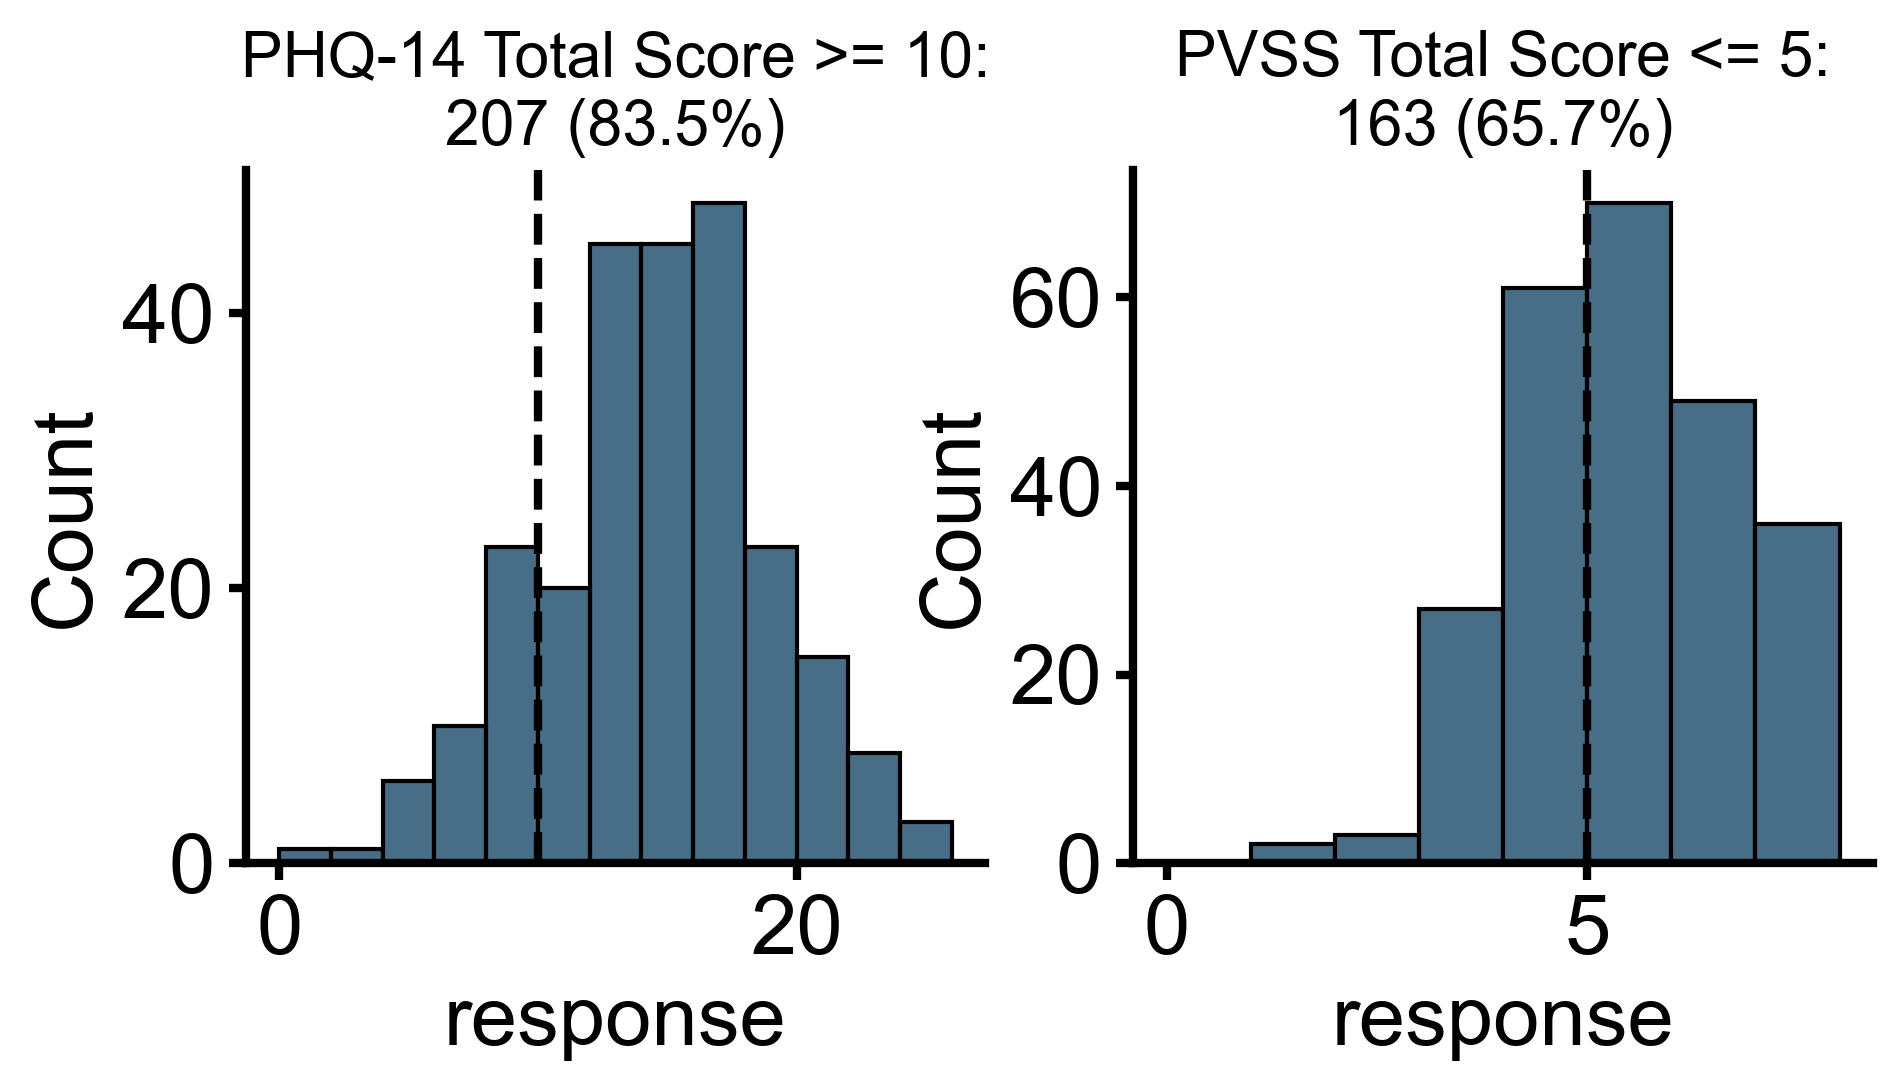

In [8]:
# Histogram of baseline PHQ-14 total score

phq14_baseline = surveys.loc[
    (surveys.question == "phq14_total_score")
    & (surveys.redcap_event_name == "baseline_arm_1")
]
pvss_baseline = surveys.loc[
    (surveys.question == "pvss_total") & (surveys.redcap_event_name == "baseline_arm_1")
]

fig, axes = plt.subplots(figsize=(7, 3), nrows=1, ncols=2)
ax = axes[0]

sns.histplot(
    phq14_baseline,
    x="response",
    bins=range(0, 28, 2),
    color=ucla_darkest_blue,
    ax=ax,
)
# Add vertical line at threshold of 10
ylims = ax.get_ylim()
ax.vlines(10, *ylims, color="black", linestyle="--", lw=2)
ax.set_ylim(*ylims)
fa.despine_thicken_axes(ax)

count_geq_10 = (phq14_baseline.response >= 10).sum()
percent_geq_10 = (phq14_baseline.response >= 10).mean()
percent_geq_10
ax.set_title(
    f"PHQ-14 Total Score >= 10:\n{count_geq_10} ({percent_geq_10:.1%})",
    fontsize=15,
)

ax = axes[1]
sns.histplot(
    pvss_baseline,
    x="response",
    bins=range(0, 9, 1),
    color=ucla_darkest_blue,
    ax=ax,
)
# Add vertical line at threshold of 10
ylims = ax.get_ylim()
ax.vlines(5, *ylims, color="black", linestyle="--", lw=2)
ax.set_ylim(*ylims)
fa.despine_thicken_axes(ax)

count_leq_6 = (pvss_baseline.response <= 5).sum()
percent_leq_6 = (pvss_baseline.response <= 5).mean()
percent_leq_6
ax.set_title(
    f"PVSS Total Score <= 5:\n{count_leq_6} ({percent_leq_6:.1%})",
    fontsize=15,
)

### Load Demographic data


In [9]:
baseline_paths

[PosixPath('/Users/sakre/Data/OPTIMA/OPTIMA_REDCap/OPTIMA REDCap Data 26Apr2024/OPTIMAExternal-WLBaseline_1of2_DATA_2024-04-26_1737.csv'),
 PosixPath('/Users/sakre/Data/OPTIMA/OPTIMA_REDCap/OPTIMA REDCap Data 26Apr2024/OPTIMAExternal-WLBaseline2of2_DATA_2024-04-26_1825.csv')]

In [10]:
baseline_data = pd.concat([pd.read_csv(p) for p in baseline_paths]).merge(
    surveys[["record_id", "user_id"]].drop_duplicates(),
    how="inner",
    validate="m:1",
)
demog_cols = [c for c in baseline_data.columns if "demog" in c]
tx_hist_cols = [
    "tx_hist_psychotherapy",
    "tx_hist_depression",
    "tx_hist_psychother_4wk",
    "tx_hist_curr_med",
]
tx_hist = (
    baseline_data[["user_id", "record_id"] + tx_hist_cols]
    .drop_duplicates()
    .dropna(subset="tx_hist_depression")
)
demographics = (
    baseline_data[["user_id", "record_id"] + demog_cols]
    .drop_duplicates()
    .dropna(subset="demog_survey_start")
    .merge(tx_hist, how="left", on=["user_id", "record_id"], validate="1:1")
)
race_cols = [c for c in demog_cols if "race" in c]
race_melt = demographics[["user_id"] + race_cols].melt(
    id_vars="user_id",
)
race_melt = race_melt[race_melt.value == 1]
race_melt["race_int"] = race_melt["variable"].str.split("___").str[1].astype(int)
race_melt["Race"] = race_melt["race_int"].map(race_map)
n_races = race_melt.groupby("user_id").Race.nunique().reset_index()
multiple_races = n_races[n_races.Race > 1]
multi_race_info = race_melt[race_melt.user_id.isin(multiple_races.user_id)].sort_values(
    "user_id"
)
race_melt.loc[
    race_melt.user_id.isin(multiple_races.user_id),
    "Race",
] = "Multiple"
race_melt.loc[
    race_melt.user_id.isin(multiple_races.user_id),
    "race_int",
] = 20
race_data = race_melt[["user_id", "Race", "race_int"]].drop_duplicates()
demographics = demographics.merge(race_data, how="left", on="user_id", validate="1:1")
demographics["Family Income"] = demographics["demog_fam_income"].map(income_map)
demographics["Family Income <100k"] = (demographics["demog_fam_income"] != 6).map(
    {True: "Yes", False: "No"}
)
demographics["Current Gender"] = demographics["demog_gender_curr"].map(gender_map)
demographics["Sex"] = demographics["demog_gender"].map(gender_map)
demographics["Sex - Female"] = (demographics["Sex"] == "Female").map(
    {True: "Yes", False: "No"}
)
demographics["Male or Female"] = demographics["demog_gender_curr"].map(gender_map_short)
demographics["Age"] = demographics["demog_age"]
demographics.loc[demographics.Age == "thirty-four ", "Age"] = 34
demographics["Age"] = demographics["Age"].astype("int")
demographics["Hispanic"] = demographics["demog_hispanic"].map(ethnicity_map)
demographics["Hispanic Yes/No"] = demographics["demog_hispanic"].map(
    ethnicity_map_short
)
demographics["Non-Hispanic White"] = (
    (demographics["demog_hispanic"] != 1) & (demographics["Race"] == "White")
).map({True: "No", False: "Yes"})
tx_cols = list(tx_rename.values())
for col, val in tx_rename.items():
    demographics[val] = demographics[col].map({0: "No", 1: "Yes"})
# demographics[['Non-Hispanic White', 'Sex', 'Family Income', 'Hispanic', *tx_cols]].describe(include='all').T.to_clipboard()
d_cols = [
    "Sex - Female",
    "Family Income <100k",
    "Non-Hispanic White",
    *tx_cols,
]
counts_list = []
for col in d_cols:
    counts = demographics[col].value_counts()
    counts.name = col
    counts_list.append(counts)
demog_counts = pd.concat(counts_list, axis=1).T
demog_counts["Yes (%)"] = (demog_counts["Yes"] / demog_counts.sum(axis=1)).map(
    "{:.1%}".format
)
demog_counts["No (%)"] = (
    demog_counts["No"] / demog_counts[["Yes", "No"]].sum(axis=1)
).map("{:.1%}".format)
demog_counts = demog_counts[["Yes", "Yes (%)", "No", "No (%)"]]
demog_counts["Yes"] = (
    demog_counts["Yes"].astype(str) + " (" + demog_counts["Yes (%)"] + ")"
)
demog_counts["No"] = (
    demog_counts["No"].astype(str) + " (" + demog_counts["No (%)"] + ")"
)
demog_counts = demog_counts[["Yes", "No"]]
demog_counts.to_clipboard()
demog_counts

Yes           No
Sex - Female                                  160 (64.5%)   88 (35.5%)
Family Income <100k                           125 (50.4%)  123 (49.6%)
Non-Hispanic White                            142 (57.3%)  106 (42.7%)
History of Psychotherapy                      201 (81.0%)   47 (19.0%)
Depression diagnosis                          172 (69.4%)   76 (30.6%)
Psychotherapy (in past 4 weeks)               112 (45.2%)  136 (54.8%)
Currently using medication for mental health  116 (46.8%)  132 (53.2%)

In [11]:
[c for c in final_user_ids if c not in demographics["user_id"].unique()]

[226]

<Axes: title={'center': 'Age'}, xlabel='Age', ylabel='count'>

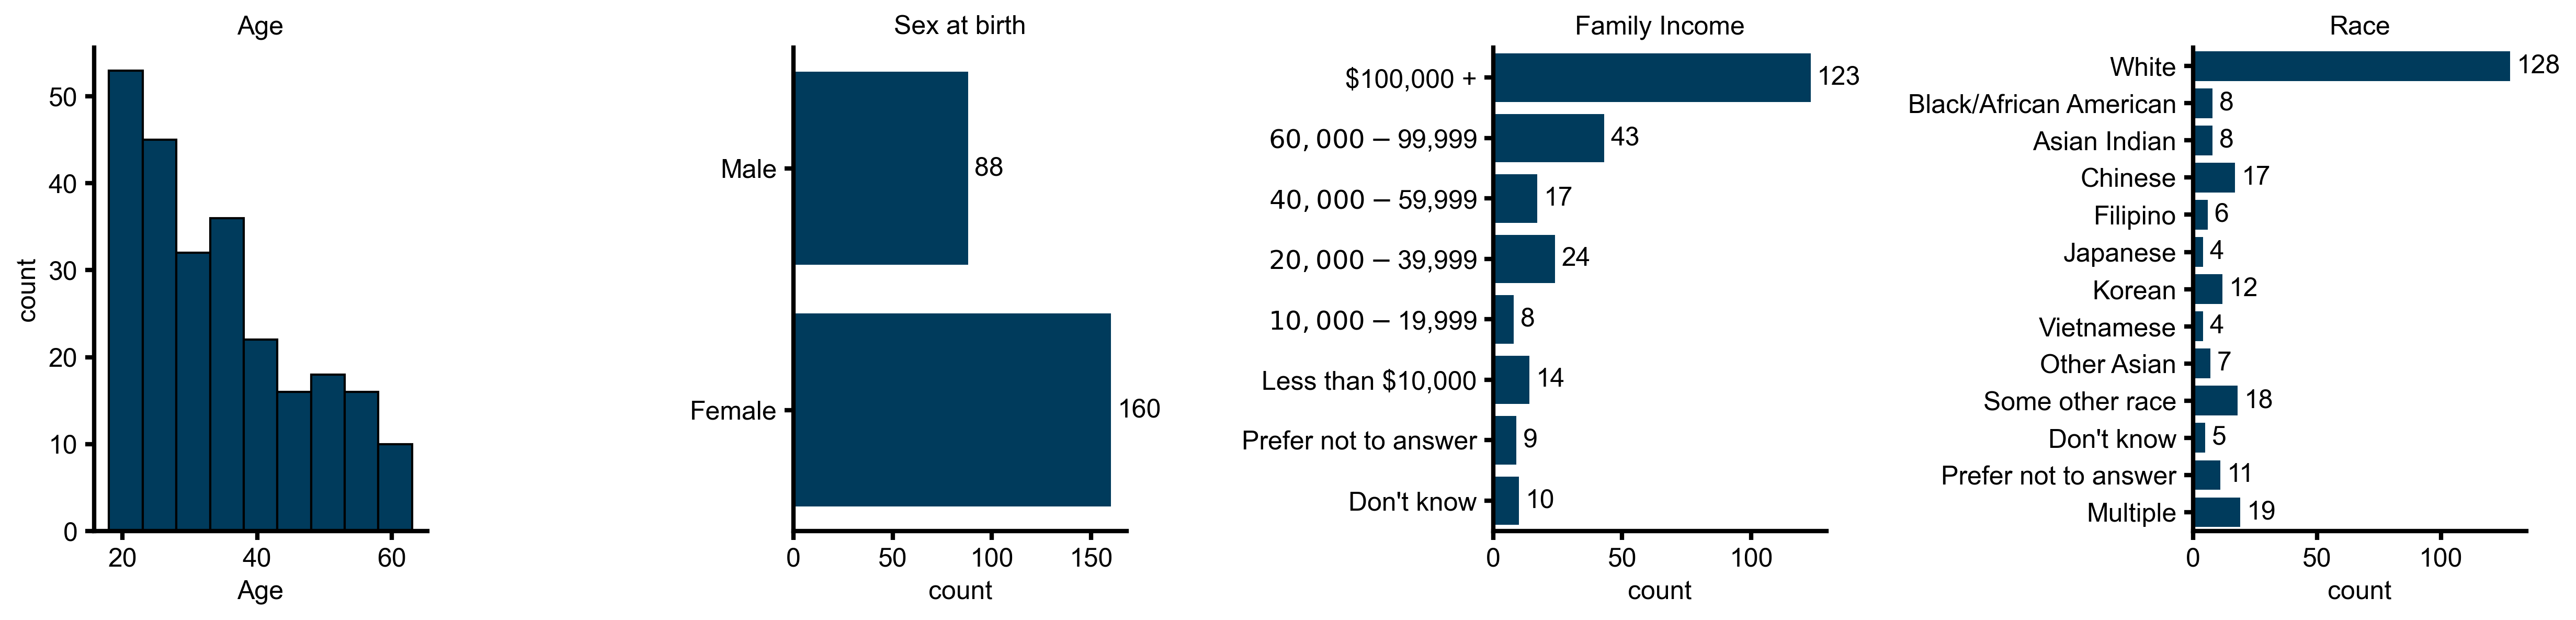

In [12]:
fa.setup_style()
fig, axes = plt.subplots(figsize=(20, 4), ncols=4)
plt.subplots_adjust(wspace=1.1)

ax = axes[1]
# Annotate countplot with values
sns.countplot(
    data=demographics,
    y="Sex",
    ax=ax,
    color="#003B5C",
    saturation=1,
    # order=gender_map.values(),
)
for p in ax.patches:
    ax.annotate(
        format(p.get_width(), ".0f"),  # Format the count as a string
        xy=(p.get_width(), p.get_y() + p.get_height() / 2),
        xytext=(3, 0),  # Distance from the bars
        textcoords="offset points",
        ha="left",
        va="center",
        fontsize=12,
    )
ax.set_ylabel("")
ax.set_title("Sex at birth")
fa.despine_thicken_axes(ax, fontsize=12)

ax = axes[2]
sns.countplot(
    data=demographics,
    y="Family Income",
    ax=ax,
    color="#003B5C",
    order=list(income_map.values())[::-1],
    saturation=1,
)
for p in ax.patches:
    ax.annotate(
        format(p.get_width(), ".0f"),  # Format the count as a string
        xy=(p.get_width(), p.get_y() + p.get_height() / 2),
        xytext=(3, 0),  # Distance from the bars
        textcoords="offset points",
        ha="left",
        va="center",
        fontsize=12,
    )
ax.set_ylabel("")
ax.set_title("Family Income")
fa.despine_thicken_axes(ax, fontsize=12)


ax = axes[3]
sns.countplot(
    data=demographics.sort_values(by="race_int"),
    y="Race",
    ax=ax,
    color="#003B5C",
    saturation=1,
)
for p in ax.patches:
    ax.annotate(
        format(p.get_width(), ".0f"),  # Format the count as a string
        xy=(p.get_width(), p.get_y() + p.get_height() / 2),
        xytext=(3, 0),  # Distance from the bars
        textcoords="offset points",
        ha="left",
        va="center",
        fontsize=12,
    )
ax.set_ylabel("")
ax.set_title("Race")
fa.despine_thicken_axes(ax, fontsize=12)

ax = axes[0]
sns.histplot(demographics["Age"], ax=ax, color="#003B5C", alpha=1)

ax.set_ylabel("count")
ax.set_title("Age")
fa.despine_thicken_axes(ax, fontsize=12)

### Load TestMyBrain


In [13]:
tmb = pd.read_excel(tmb_path).dropna(how="all")
tmb["ID"] = tmb.record_id.str.split("_").str[1].astype("int")
tmb_feats = [c for c in tmb.columns if c not in ["record_id", "ID"]]
tmb_remove_cols = ["tmb_dsc_medianrtc", "tmb_crt_medianrtc"]
tmb_feats = [f for f in tmb_feats if f not in tmb_remove_cols]
tmb_feats = tmb_map.keys()
tmb = tmb.set_index("ID")[tmb_feats]

## Describe Survey responses

### Distribution of PSQI


mean   std  threshold  percent_true  count
question                                                       
Daytime Dysfunction  1.70  0.71        2.0          0.61  705.0
Disturbance          1.58  0.63        2.0          0.54  705.0
Duration             0.70  0.85        1.0          0.50  705.0
Efficiency           0.69  0.97        1.0          0.41  705.0
Latency              1.67  1.02        2.0          0.57  705.0
Sleep Medication     0.90  1.22        1.0          0.41  705.0
Sleep Quality        1.64  0.72        2.0          0.57  705.0
Total Score          8.89  3.46        5.0          0.90  705.0

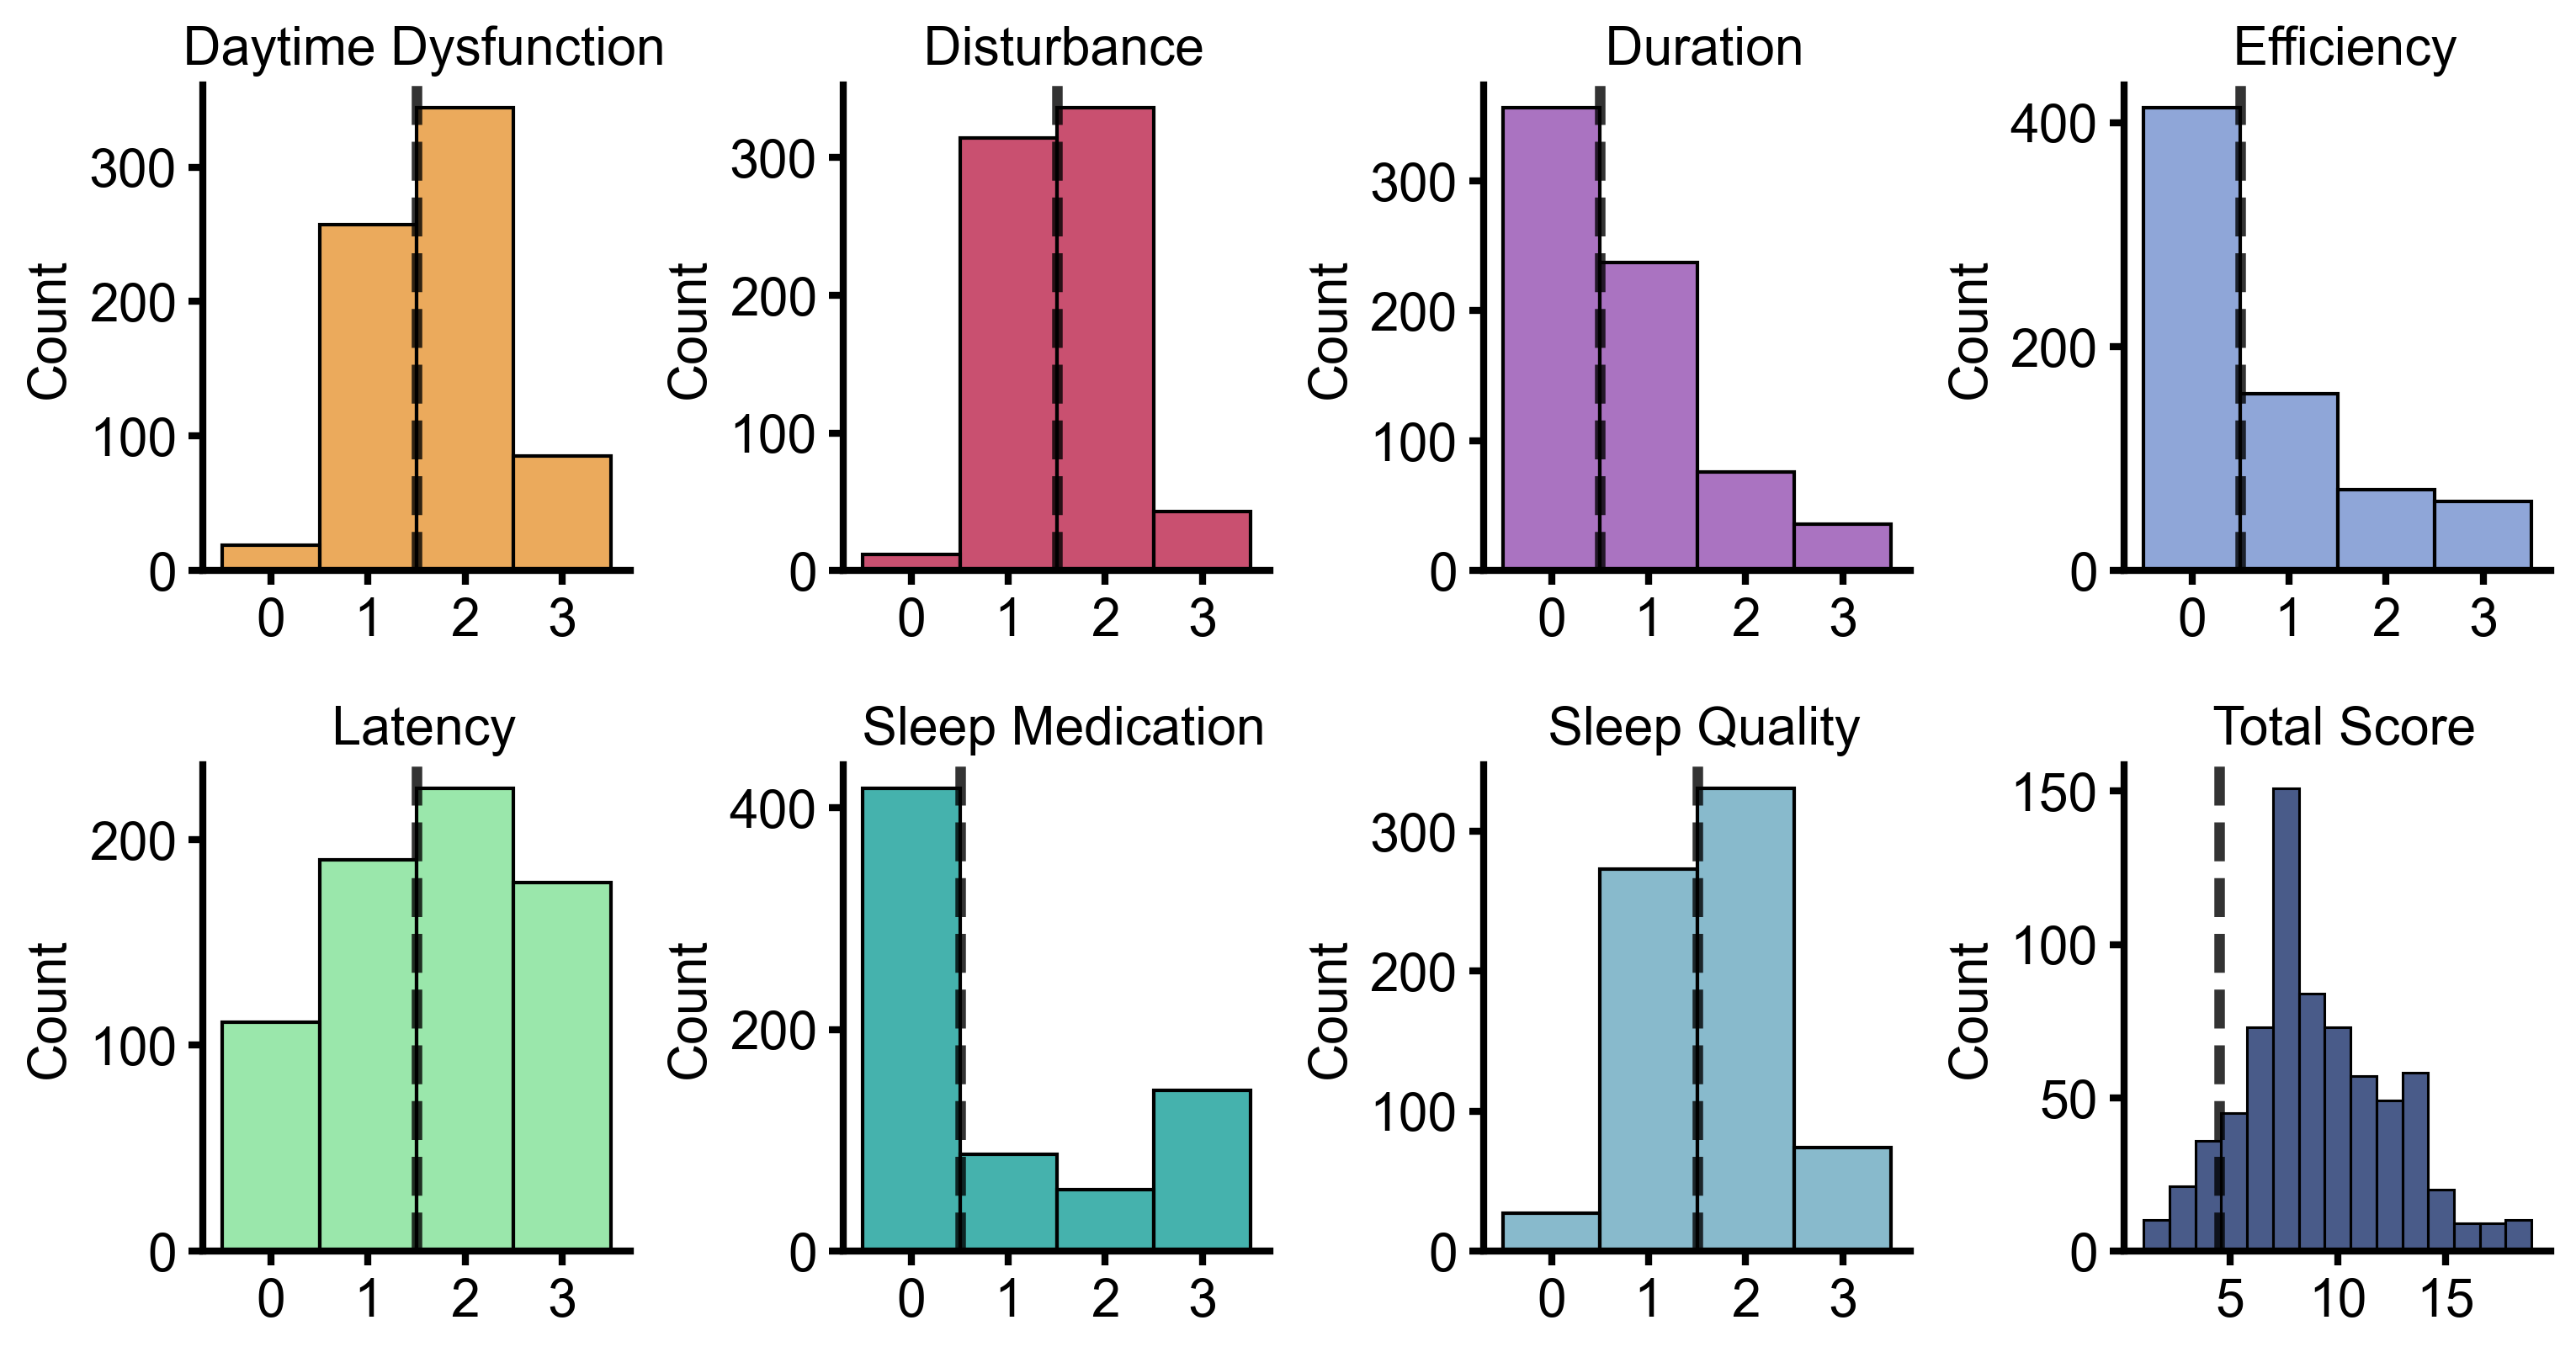

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.4)
user_psqi = surveys[
    (surveys.survey == "psqi") & (surveys.question.isin(psqi_relabel.keys()))
]
for i, ((q, threshold), q_df) in enumerate(
    user_psqi.groupby(["question", "threshold"])
):
    ax = axes.flatten()[i]
    if q == "total":
        bins = 15
    else:
        bins = [-0.5, 0.5, 1.5, 2.5, 3.5]
        ax.set_xticks([0, 1, 2, 3])

    ax.axvline(threshold - 0.5, color="black", linestyle="--", alpha=0.8, lw=3)
    sns.histplot(data=q_df, x="response", color=psqi_pallette[q], ax=ax, bins=bins)
    ax.set_xlabel("")
    ax.set_title(psqi_relabel_long[q].strip("PSQI"), fontsize=15)
    # vertical line at threshold
    fa.despine_thicken_axes(ax, fontsize=15)

psqi_n_true = user_psqi.groupby("question").response_binary.sum()
psqi_n_total = user_psqi.groupby("question").response_binary.count()
psqi_perc_true = psqi_n_true / psqi_n_total
psqi_thresholds = user_psqi.groupby("question").threshold.median()

psqi_desc = user_psqi.groupby("question").response.describe()
psqi_desc["percent_true"] = psqi_perc_true
psqi_desc["threshold"] = psqi_thresholds
psqi_desc = psqi_desc.rename(index=psqi_relabel).reset_index()
psqi_desc["question"] = psqi_desc["question"].str.replace("\n", " ")
psqi_response_table = (
    psqi_desc[["question", "mean", "std", "threshold", "percent_true", "count"]]
    .set_index("question")
    .round(2)
)
psqi_response_table.to_clipboard()
psqi_response_table

### Distribution of PHQ-8


/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/862268300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phq["question_order"] = phq.question.map(phq_q_order_map)


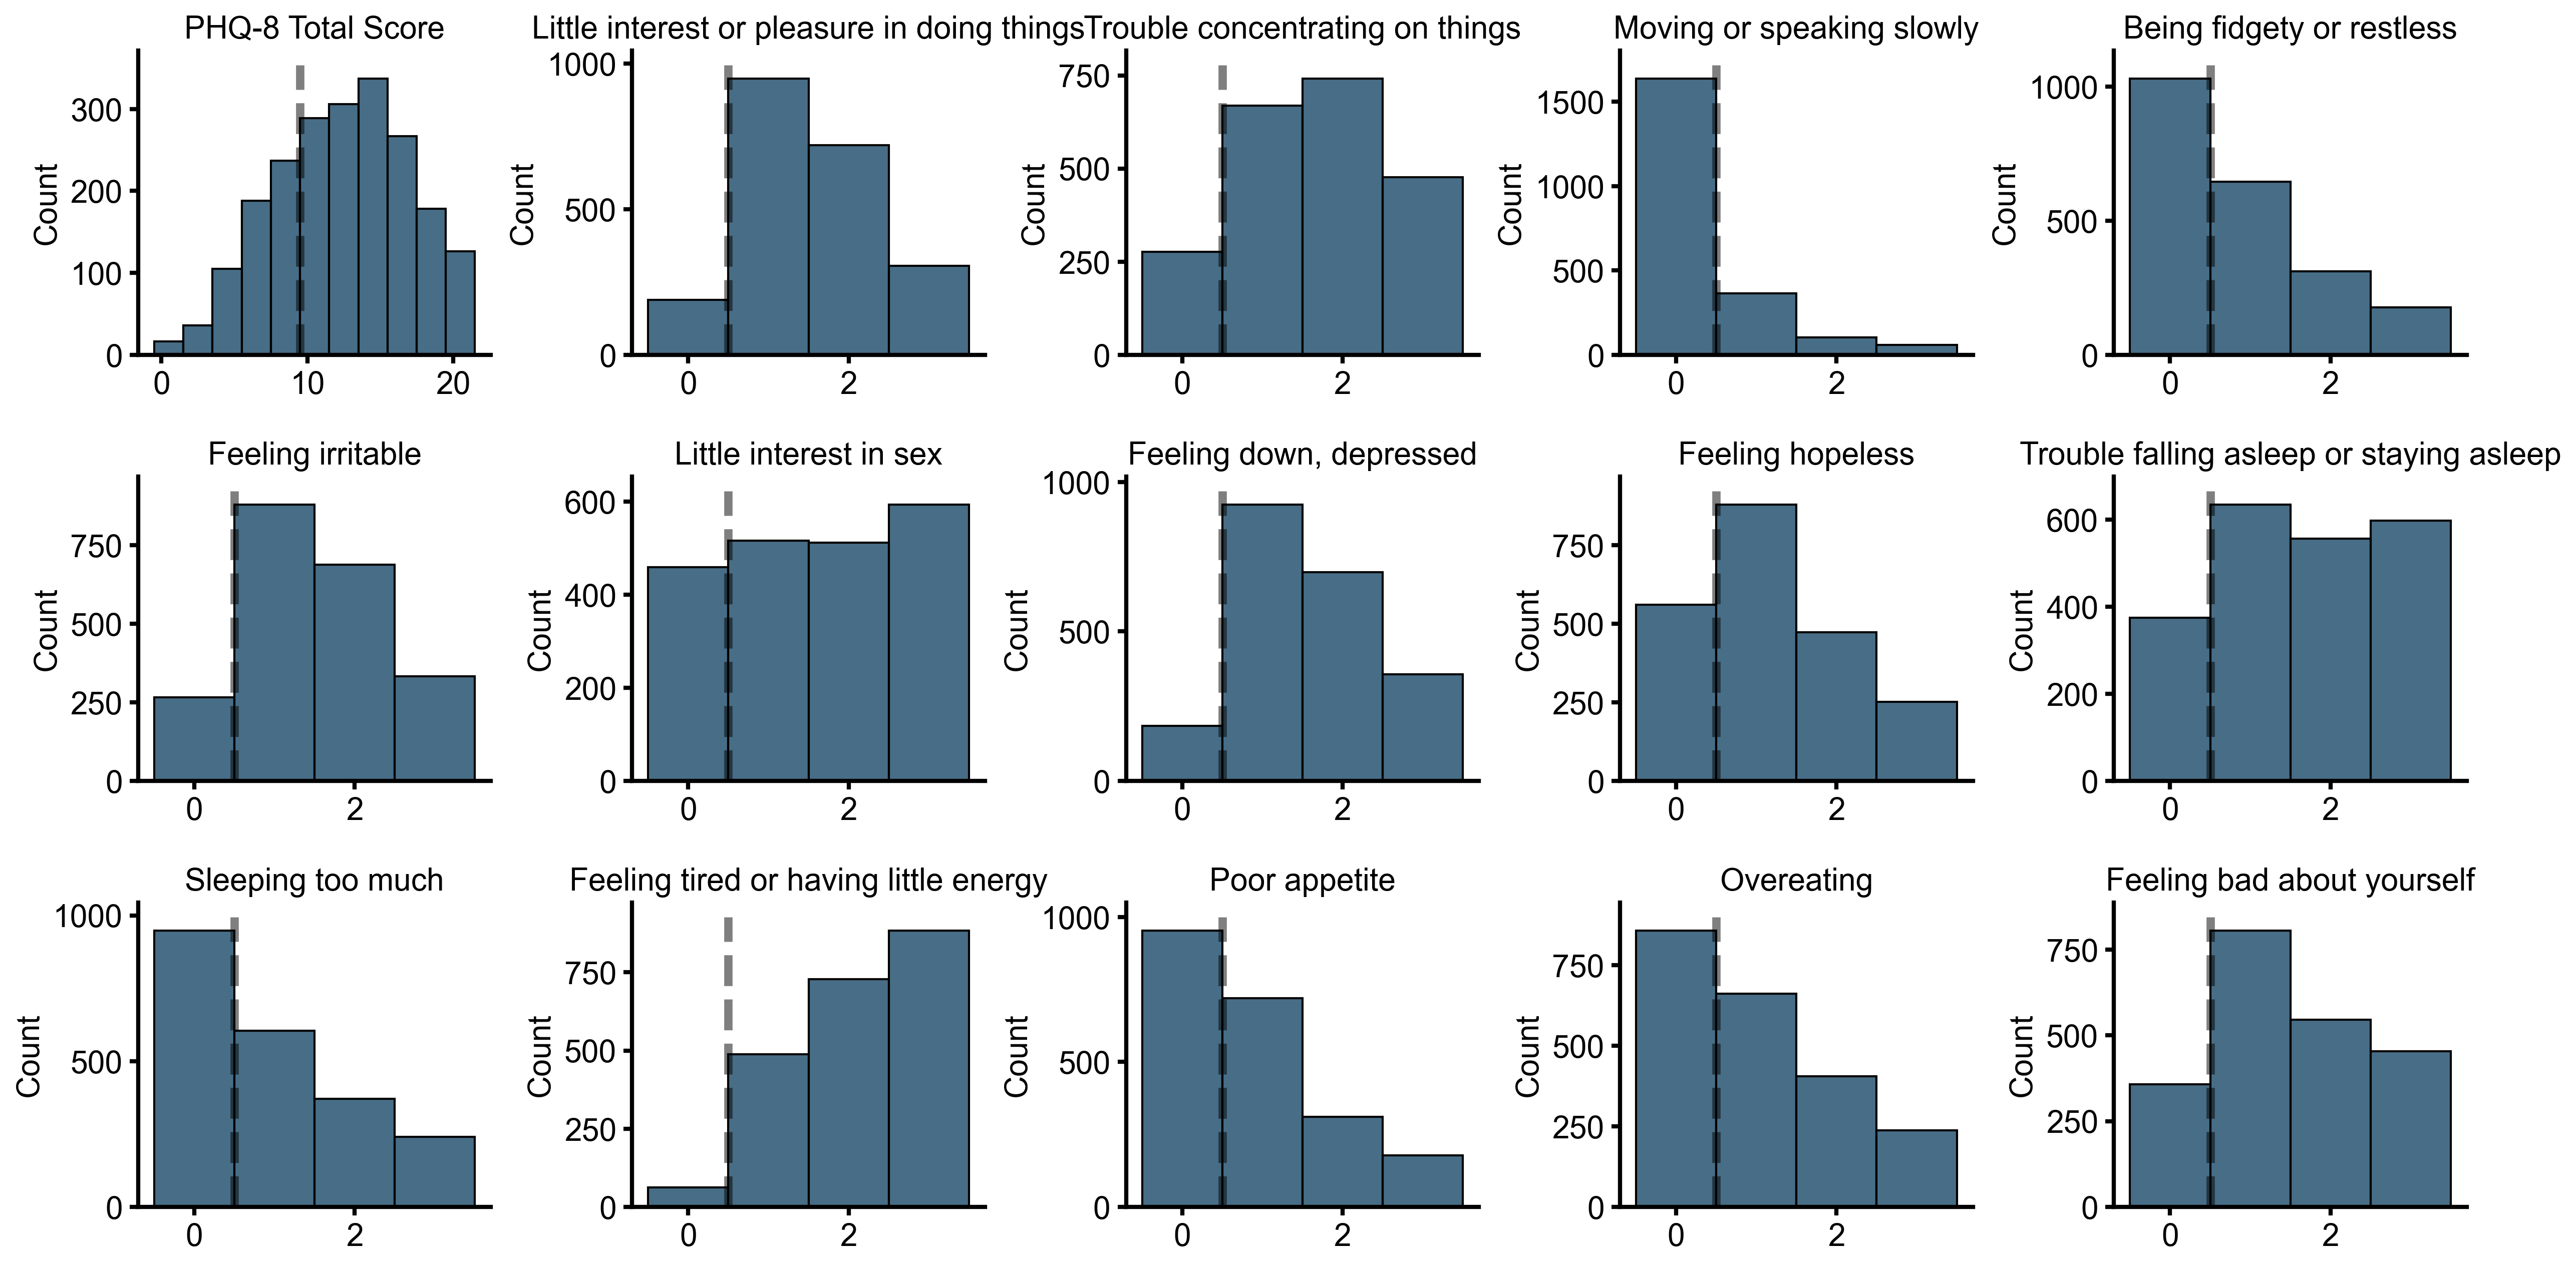

In [15]:
phq = surveys[(surveys.survey == "phq14") & (surveys.pass_qc)]
phq["question_order"] = phq.question.map(phq_q_order_map)
phq = phq.sort_values(by=["question_order"])

fig, axes = plt.subplots(figsize=(20, 10), nrows=3, ncols=5)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
# Plot distribution of responses per PHQ question and threshold for binary classification
for i, (q, q_df) in enumerate(phq.groupby("question")):
    ax = axes.flatten()[i]
    threshold = q_df.threshold.unique()[0]
    if q == "phq14_total_score":
        bins = range(0, 24, 2)
        bins = [b - 0.5 for b in bins]
    else:
        bins = [-0.5, 0.5, 1.5, 2.5, 3.5]
    sns.histplot(data=q_df, x="response", ax=ax, bins=bins, color=ucla_darkest_blue)
    ax.set_title(f"{item_map[q]}", fontsize=15)
    ax.vlines(
        threshold - 0.5,
        *ax.get_ylim(),
        color="black",
        linestyle="--",
        alpha=0.5,
        lw=4,
    )
    ax.set_xlabel("")
    fa.despine_thicken_axes(ax, fontsize=15)

In [16]:
phq_n_true = phq.groupby("question").response_binary.sum()
phq_n_total = phq.groupby("question").response_binary.count()
phq_perc_true = phq_n_true / phq_n_total
phq_thresholds = phq.groupby("question").threshold.median()

phq_desc = phq.groupby("question").response.describe()
phq_desc["percent_true"] = phq_perc_true
phq_desc["threshold"] = phq_thresholds
phq_desc = phq_desc.reset_index()
phq_desc["question"] = phq_desc["question"].map(item_map)
phq_response_table = (
    phq_desc[["question", "mean", "std", "threshold", "percent_true", "count"]]
    .set_index("question")
    .round(2)
)
phq_response_table.to_clipboard()
phq_response_table

mean   std  threshold  \
question                                                              
PHQ-8 Total Score                            12.78  4.92       10.0   
Little interest or pleasure in doing things   1.53  0.84        1.0   
Trouble concentrating on things               1.66  0.96        1.0   
Moving or speaking slowly                     0.34  0.69        1.0   
Being fidgety or restless                     0.83  0.96        1.0   
Feeling irritable                             1.50  0.90        1.0   
Little interest in sex                        1.60  1.12        1.0   
Feeling down, depressed                       1.57  0.86        1.0   
Feeling hopeless                              1.19  0.95        1.0   
Trouble falling asleep or staying asleep      1.64  1.06        1.0   
Sleeping too much                             0.96  1.03        1.0   
Feeling tired or having little energy         2.13  0.86        1.0   
Poor appetite                                 0.87  0.95        1.0   
Overeating                                    1.01  1.01        1.0   
Feeling bad about yourself                    1.51  1.00        1.0   

                                             percent_true   count  
question                                                           
PHQ-8 Total Score                                    0.73  2162.0  
Little interest or pleasure in doing things          0.91  2162.0  
Trouble concentrating on things                      0.87  2162.0  
Moving or speaking slowly                            0.24  2162.0  
Being fidgety or restless                            0.52  2162.0  
Feeling irritable                                    0.88  2162.0  
Little interest in sex                               0.78  2080.0  
Feeling down, depressed                              0.92  2162.0  
Feeling hopeless                                     0.74  2162.0  
Trouble falling asleep or staying asleep             0.83  2162.0  
Sleeping too much                                    0.56  2162.0  
Feeling tired or having little energy                0.97  2162.0  
Poor appetite                                        0.56  2162.0  
Overeating                                           0.60  2162.0  
Feeling bad about yourself                           0.83  2162.0

In [82]:
both_responses = pd.concat([phq_response_table, psqi_response_table])
both_responses.to_clipboard()
both_responses

mean   std  threshold  \
question                                                              
PHQ-8 Total Score                            12.78  4.92       10.0   
Little interest or pleasure in doing things   1.53  0.84        1.0   
Trouble concentrating on things               1.66  0.96        1.0   
Moving or speaking slowly                     0.34  0.69        1.0   
Being fidgety or restless                     0.83  0.96        1.0   
Feeling irritable                             1.50  0.90        1.0   
Little interest in sex                        1.60  1.12        1.0   
Feeling down, depressed                       1.57  0.86        1.0   
Feeling hopeless                              1.19  0.95        1.0   
Trouble falling asleep or staying asleep      1.64  1.06        1.0   
Sleeping too much                             0.96  1.03        1.0   
Feeling tired or having little energy         2.13  0.86        1.0   
Poor appetite                                 0.87  0.95        1.0   
Overeating                                    1.01  1.01        1.0   
Feeling bad about yourself                    1.51  1.00        1.0   
Daytime Dysfunction                           1.70  0.71        2.0   
Disturbance                                   1.58  0.63        2.0   
Duration                                      0.70  0.85        1.0   
Efficiency                                    0.69  0.97        1.0   
Latency                                       1.67  1.02        2.0   
Sleep Medication                              0.90  1.22        1.0   
Sleep Quality                                 1.64  0.72        2.0   
Total Score                                   8.89  3.46        5.0   

                                             percent_true   count  
question                                                           
PHQ-8 Total Score                                    0.73  2162.0  
Little interest or pleasure in doing things          0.91  2162.0  
Trouble concentrating on things                      0.87  2162.0  
Moving or speaking slowly                            0.24  2162.0  
Being fidgety or restless                            0.52  2162.0  
Feeling irritable                                    0.88  2162.0  
Little interest in sex                               0.78  2080.0  
Feeling down, depressed                              0.92  2162.0  
Feeling hopeless                                     0.74  2162.0  
Trouble falling asleep or staying asleep             0.83  2162.0  
Sleeping too much                                    0.56  2162.0  
Feeling tired or having little energy                0.97  2162.0  
Poor appetite                                        0.56  2162.0  
Overeating                                           0.60  2162.0  
Feeling bad about yourself                           0.83  2162.0  
Daytime Dysfunction                                  0.61   705.0  
Disturbance                                          0.54   705.0  
Duration                                             0.50   705.0  
Efficiency                                           0.41   705.0  
Latency                                              0.57   705.0  
Sleep Medication                                     0.41   705.0  
Sleep Quality                                        0.57   705.0  
Total Score                                          0.90   705.0

In [18]:
class_balance = phq.groupby("question").response_binary.value_counts().unstack()
class_balance["class_balance"] = class_balance[True] / class_balance[False]
class_balance["percent_true"] = class_balance[True] / class_balance.sum(axis=1)
class_balance["label"] = class_balance.index.map(item_map)
class_balance[["label", "percent_true", False, True]].sort_values(
    by="percent_true", ascending=False
).round(2)

response_binary                                          label  percent_true  \
question                                                                       
phq_6                    Feeling tired or having little energy          0.96   
phq_2                                  Feeling down, depressed          0.91   
phq_1              Little interest or pleasure in doing things          0.91   
phq_13                                       Feeling irritable          0.87   
phq_10                         Trouble concentrating on things          0.87   
phq_9                               Feeling bad about yourself          0.83   
phq_4                 Trouble falling asleep or staying asleep          0.82   
phq_14                                  Little interest in sex          0.78   
phq_3                                         Feeling hopeless          0.74   
phq14_total_score                            PHQ-8 Total Score          0.73   
phq_8                                               Overeating          0.60   
phq_5                                        Sleeping too much          0.56   
phq_7                                            Poor appetite          0.56   
phq_12                               Being fidgety or restless          0.52   
phq_11                               Moving or speaking slowly          0.24   

response_binary    False  True  
question                        
phq_6                 62  2100  
phq_2                183  1979  
phq_1                189  1973  
phq_13               265  1897  
phq_10               276  1886  
phq_9                358  1804  
phq_4                375  1787  
phq_14               459  1621  
phq_3                560  1602  
phq14_total_score    582  1580  
phq_8                857  1305  
phq_5                947  1215  
phq_7                953  1209  
phq_12              1030  1132  
phq_11              1637   525

### Model PSQI from PHQ items


# Detecting Sleep Quality Domains

## Aggregate data prior to PSQI


In [19]:
agg_windows = [1, 3, 7, 8, 14, 28]

use_cache = True
test_it = False

current_month = pd.Timestamp.now().month
out_path = Path(
    cache_path,
    f"PSQI-hkFeatureAgg-{agg_windows}days_{current_month}.csv",
)

psqi_timestamps = surveys.loc[
    surveys.pass_qc
    & (surveys.survey == "psqi")
    & (surveys.redcap_event_name != "baseline_arm_1"),
    ["user_id", "survey_start"],
].drop_duplicates()
psqi_timestamps
if use_cache and out_path.exists():
    hk_agg = pd.read_csv(out_path, parse_dates=["survey_start"])
else:
    agg_durations = [f"{w}D" for w in agg_windows]
    if test_it == True:
        psqi_timestamps = psqi_timestamps[
            psqi_timestamps.user_id.isin(psqi_timestamps.user_id.sample(10))
        ]

    hk_agg_list = Parallel(n_jobs=10, verbose=10)(
        delayed(gatherUserMetrics)(user_id, t_df, agg_durations)
        for user_id, t_df in tqdm(
            psqi_timestamps.groupby("user_id"),
            total=psqi_timestamps.user_id.nunique(),
        )
    )
    hk_agg = pd.concat(hk_agg_list)
    hk_agg.to_csv(out_path, index=False)

hk_agg.groupby("QC_expected_duration").user_id.nunique()

QC_expected_duration
14D    226
1D     225
28D    226
3D     225
7D     226
8D     226
Name: user_id, dtype: int64

In [20]:
hk_agg_qc = healthKitQCFillNan(
    hk_agg, watch_on_threshold=0.8, duration_threshold=0.8, no_na_features=[]
)
hk_agg_qc.groupby("QC_expected_duration_days").user_id.nunique()

Watch on threshold removed 27 rows
Duration threshold removed 184 rows
QC removed 211 rows (9.0%)


QC_expected_duration_days
1.0     220
3.0     223
7.0     223
8.0     224
14.0    224
28.0    223
Name: user_id, dtype: int64

In [21]:
window_agg = hk_agg_qc[hk_agg_qc.QC_expected_duration_days == 28]

In [22]:
use_window_agg = window_agg.dropna(subset=["sleep_sleepDuration_day_median"])

print(
    hk_agg[hk_agg.QC_expected_duration_days == 28].shape,
    hk_agg.user_id.nunique(),
)
use_window_agg.shape, use_window_agg.user_id.nunique()

(426, 185) 226


((364, 186), 220)

In [23]:
na_count = use_window_agg[main_features].isna().sum()
totals = use_window_agg[main_features].count()
na_perc_psqi = na_count / totals
na_psqi = pd.concat([totals, na_count, na_perc_psqi], axis=1)
na_psqi.columns = ["PSQI total", "PSQI missing", "PSQI missing %"]
na_psqi

PSQI total  PSQI missing  PSQI missing %
sleep_sleepDuration_day_min                 364             0        0.000000
sleep_sleepDuration_day_max                 364             0        0.000000
sleep_sleepDuration_day_median              364             0        0.000000
sleep_sleepDuration_day_std                 355             9        0.025352
sleep_sleepEfficiency_day_min               364             0        0.000000
sleep_sleepEfficiency_day_max               364             0        0.000000
sleep_sleepEfficiency_day_median            364             0        0.000000
sleep_sleepEfficiency_day_std               355             9        0.025352
sleep_Awake_mean                            364             0        0.000000
sleep_Awake_count                           364             0        0.000000
sleep_sleepOnsetLatency_day_min             364             0        0.000000
sleep_sleepOnsetLatency_day_max             364             0        0.000000
sleep_sleepOnsetLatency_day_median          364             0        0.000000
sleep_sleepOnsetLatency_day_std             355             9        0.025352
sleep_sleepOnsetHours_day_std               355             9        0.025352
sleep_sleepOnsetHours_day_median            364             0        0.000000
sleep_sleepOffsetHours_day_std              355             9        0.025352
sleep_sleepOffsetHours_day_median           364             0        0.000000
sleep_bedrestOffsetHours_day_std            362             2        0.005525
sleep_bedrestOffsetHours_day_median         364             0        0.000000
sleep_bedrestOnsetHours_day_std             362             2        0.005525
sleep_bedrestOnsetHours_day_median          364             0        0.000000
sleep_bedrestDuration_day_median            364             0        0.000000
sleep_bedrestDuration_day_min               364             0        0.000000
sleep_bedrestDuration_day_max               364             0        0.000000
sleep_bedrestDuration_day_std               362             2        0.005525
bedrest_audioExposure_mean                  301            63        0.209302

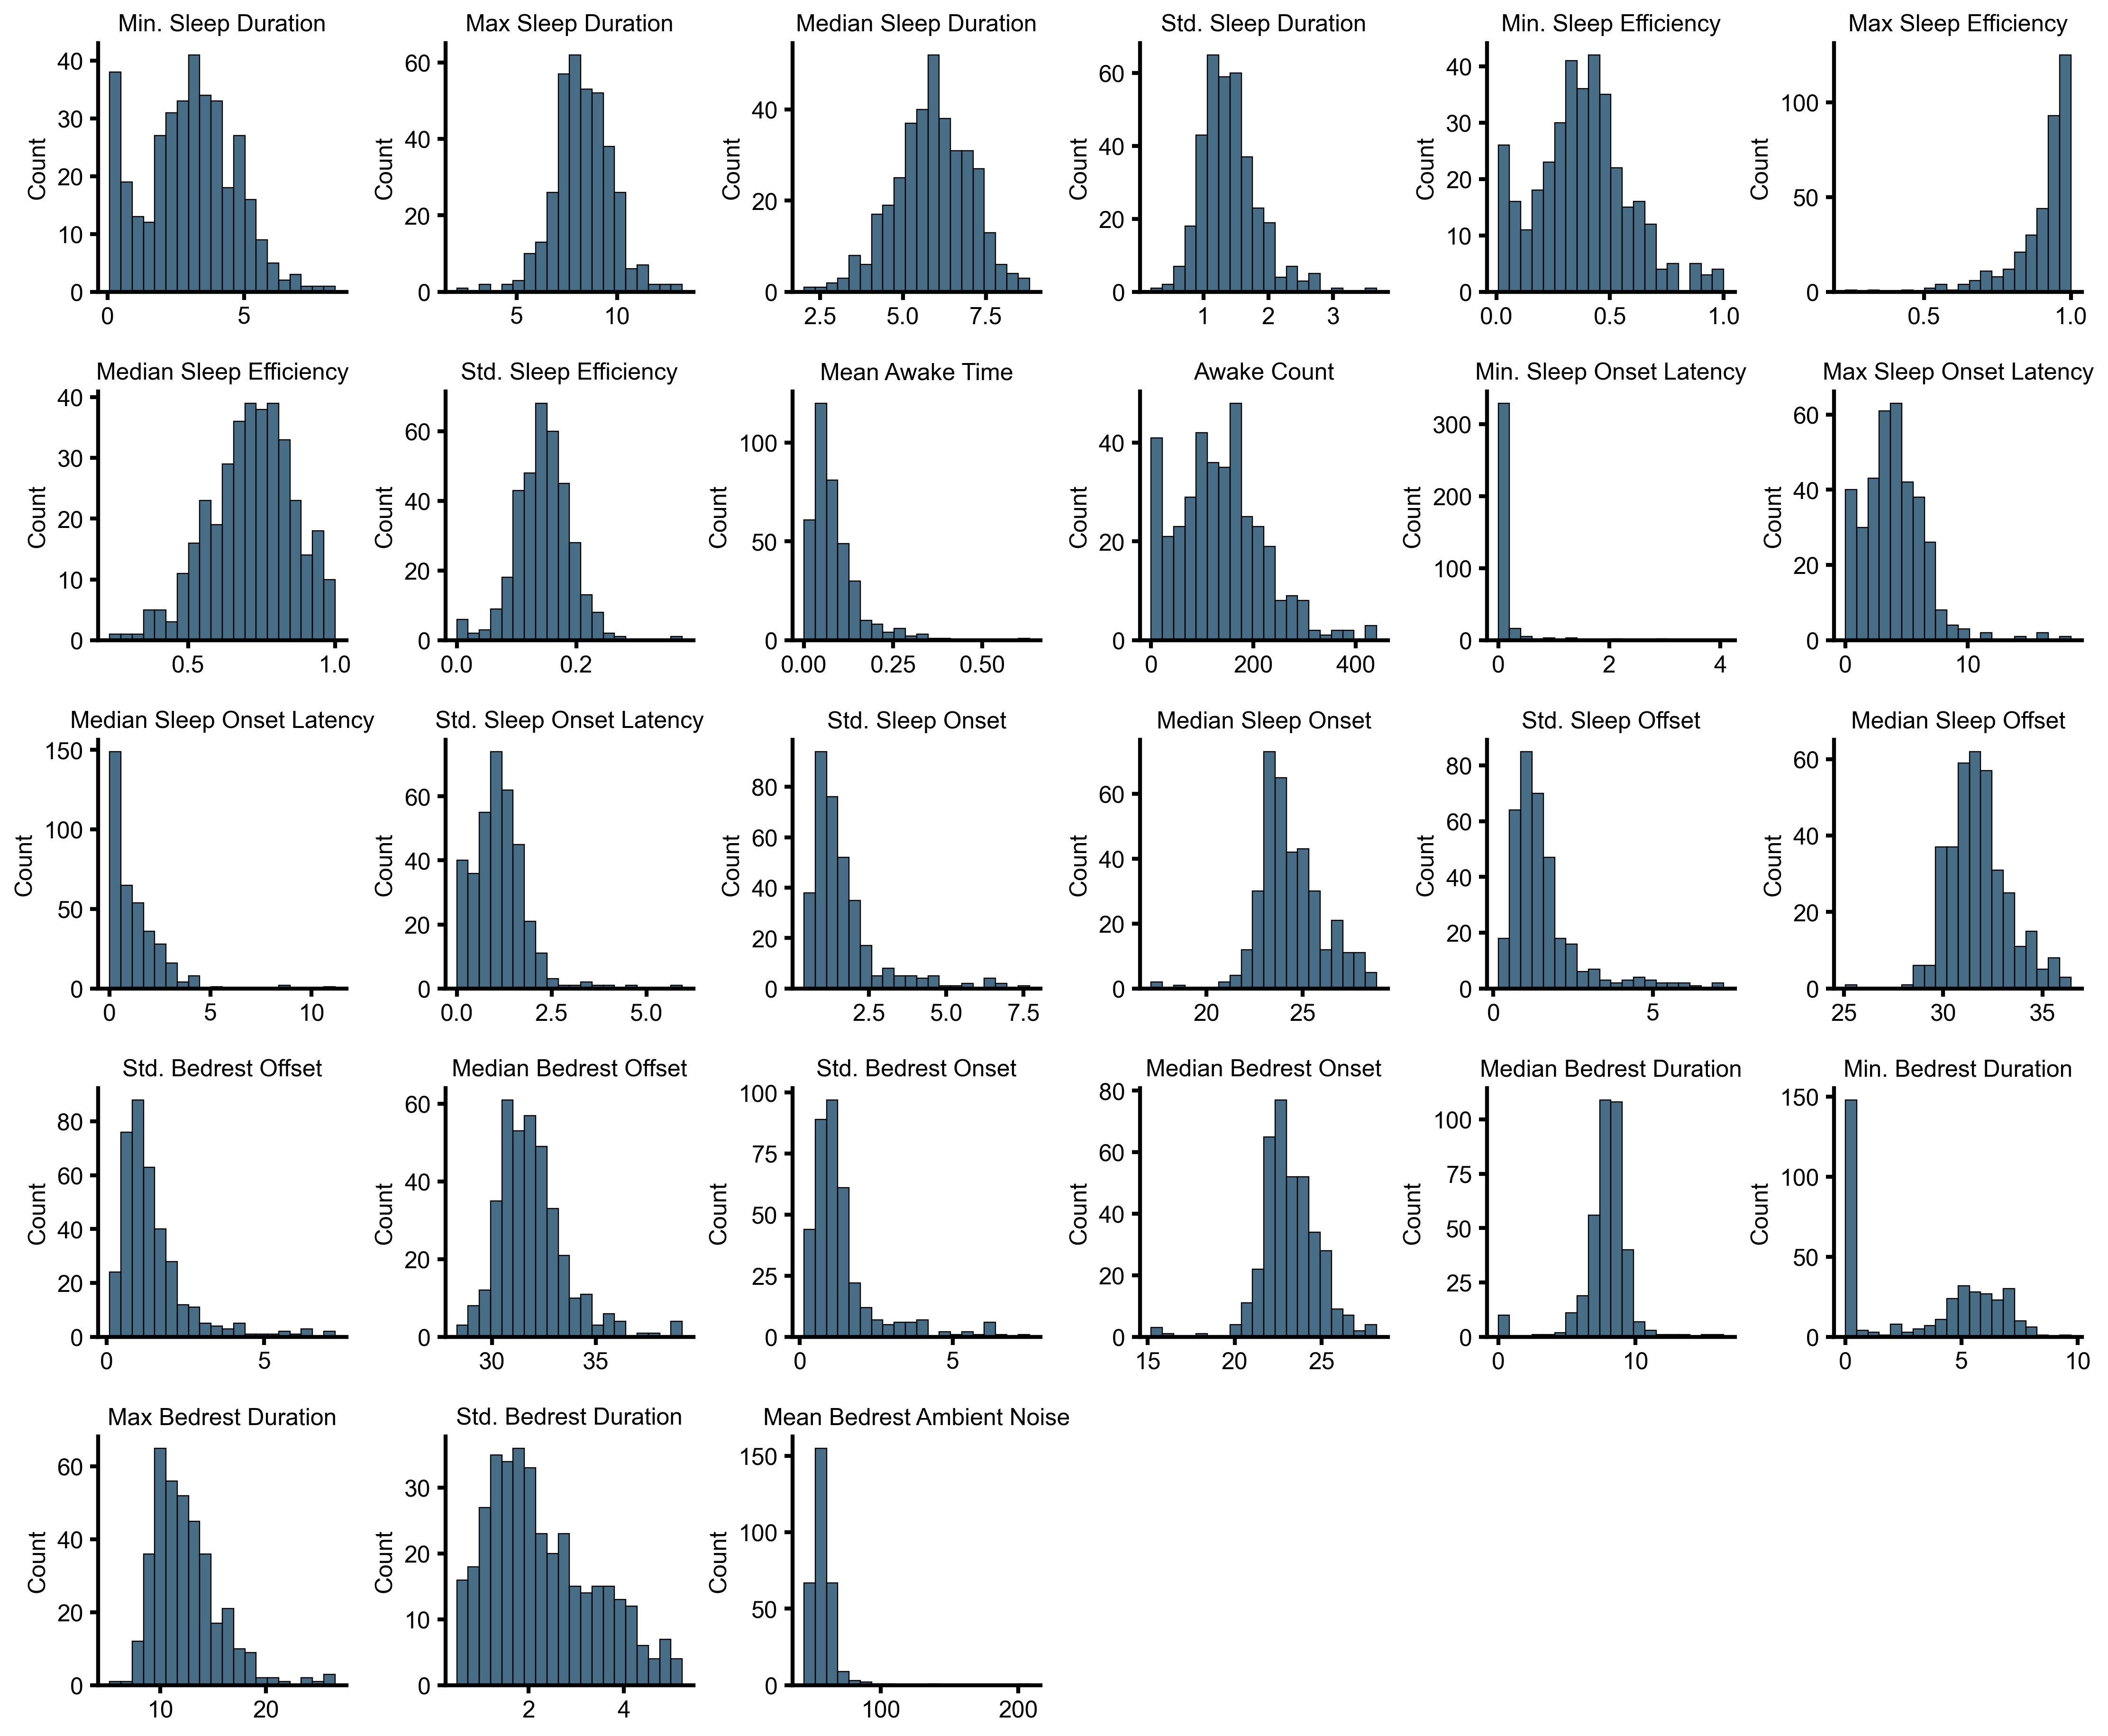

In [24]:
nrows = 5
ncols = 6
fig, axes = plt.subplots(figsize=(3 * ncols, 3 * nrows), nrows=nrows, ncols=ncols)

plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, feature in enumerate(main_features):
    ax = axes.flatten()[i]
    hist_data = window_agg[feature].dropna()
    bins = 20
    if feature == "StepCount_sum":
        hist_data = np.log10(hist_data)

    sns.histplot(
        hist_data,
        ax=ax,
        color=ucla_darkest_blue,
        bins=20,
    )
    if "period" in feature:
        ax.set_yscale("symlog")

    if feature == "StepCount_sum":
        ax.set_title("Log10 " + main_features_map[feature])
    else:
        ax.set_title(main_features_map[feature])
    ax.set_xlabel("")
    fa.despine_thicken_axes(ax, fontsize=12)
for ax in axes.flatten()[i + 1 :]:
    ax.remove()

## Recreating correlation of PSQI Metrics and Sleep features


In [25]:
psqi_piv = (
    surveys[surveys.survey == "psqi"]
    .pivot(
        index=["user_id", "survey_start"],
        columns="question",
        values="response",
    )
    .reset_index()
)

psqi_piv_hk = psqi_piv.merge(
    window_agg[["user_id", "survey_start"] + main_features],
    on=["user_id", "survey_start"],
    validate="1:1",
)
psqi_piv_hk_agg = psqi_piv_hk.groupby("user_id").mean().reset_index()

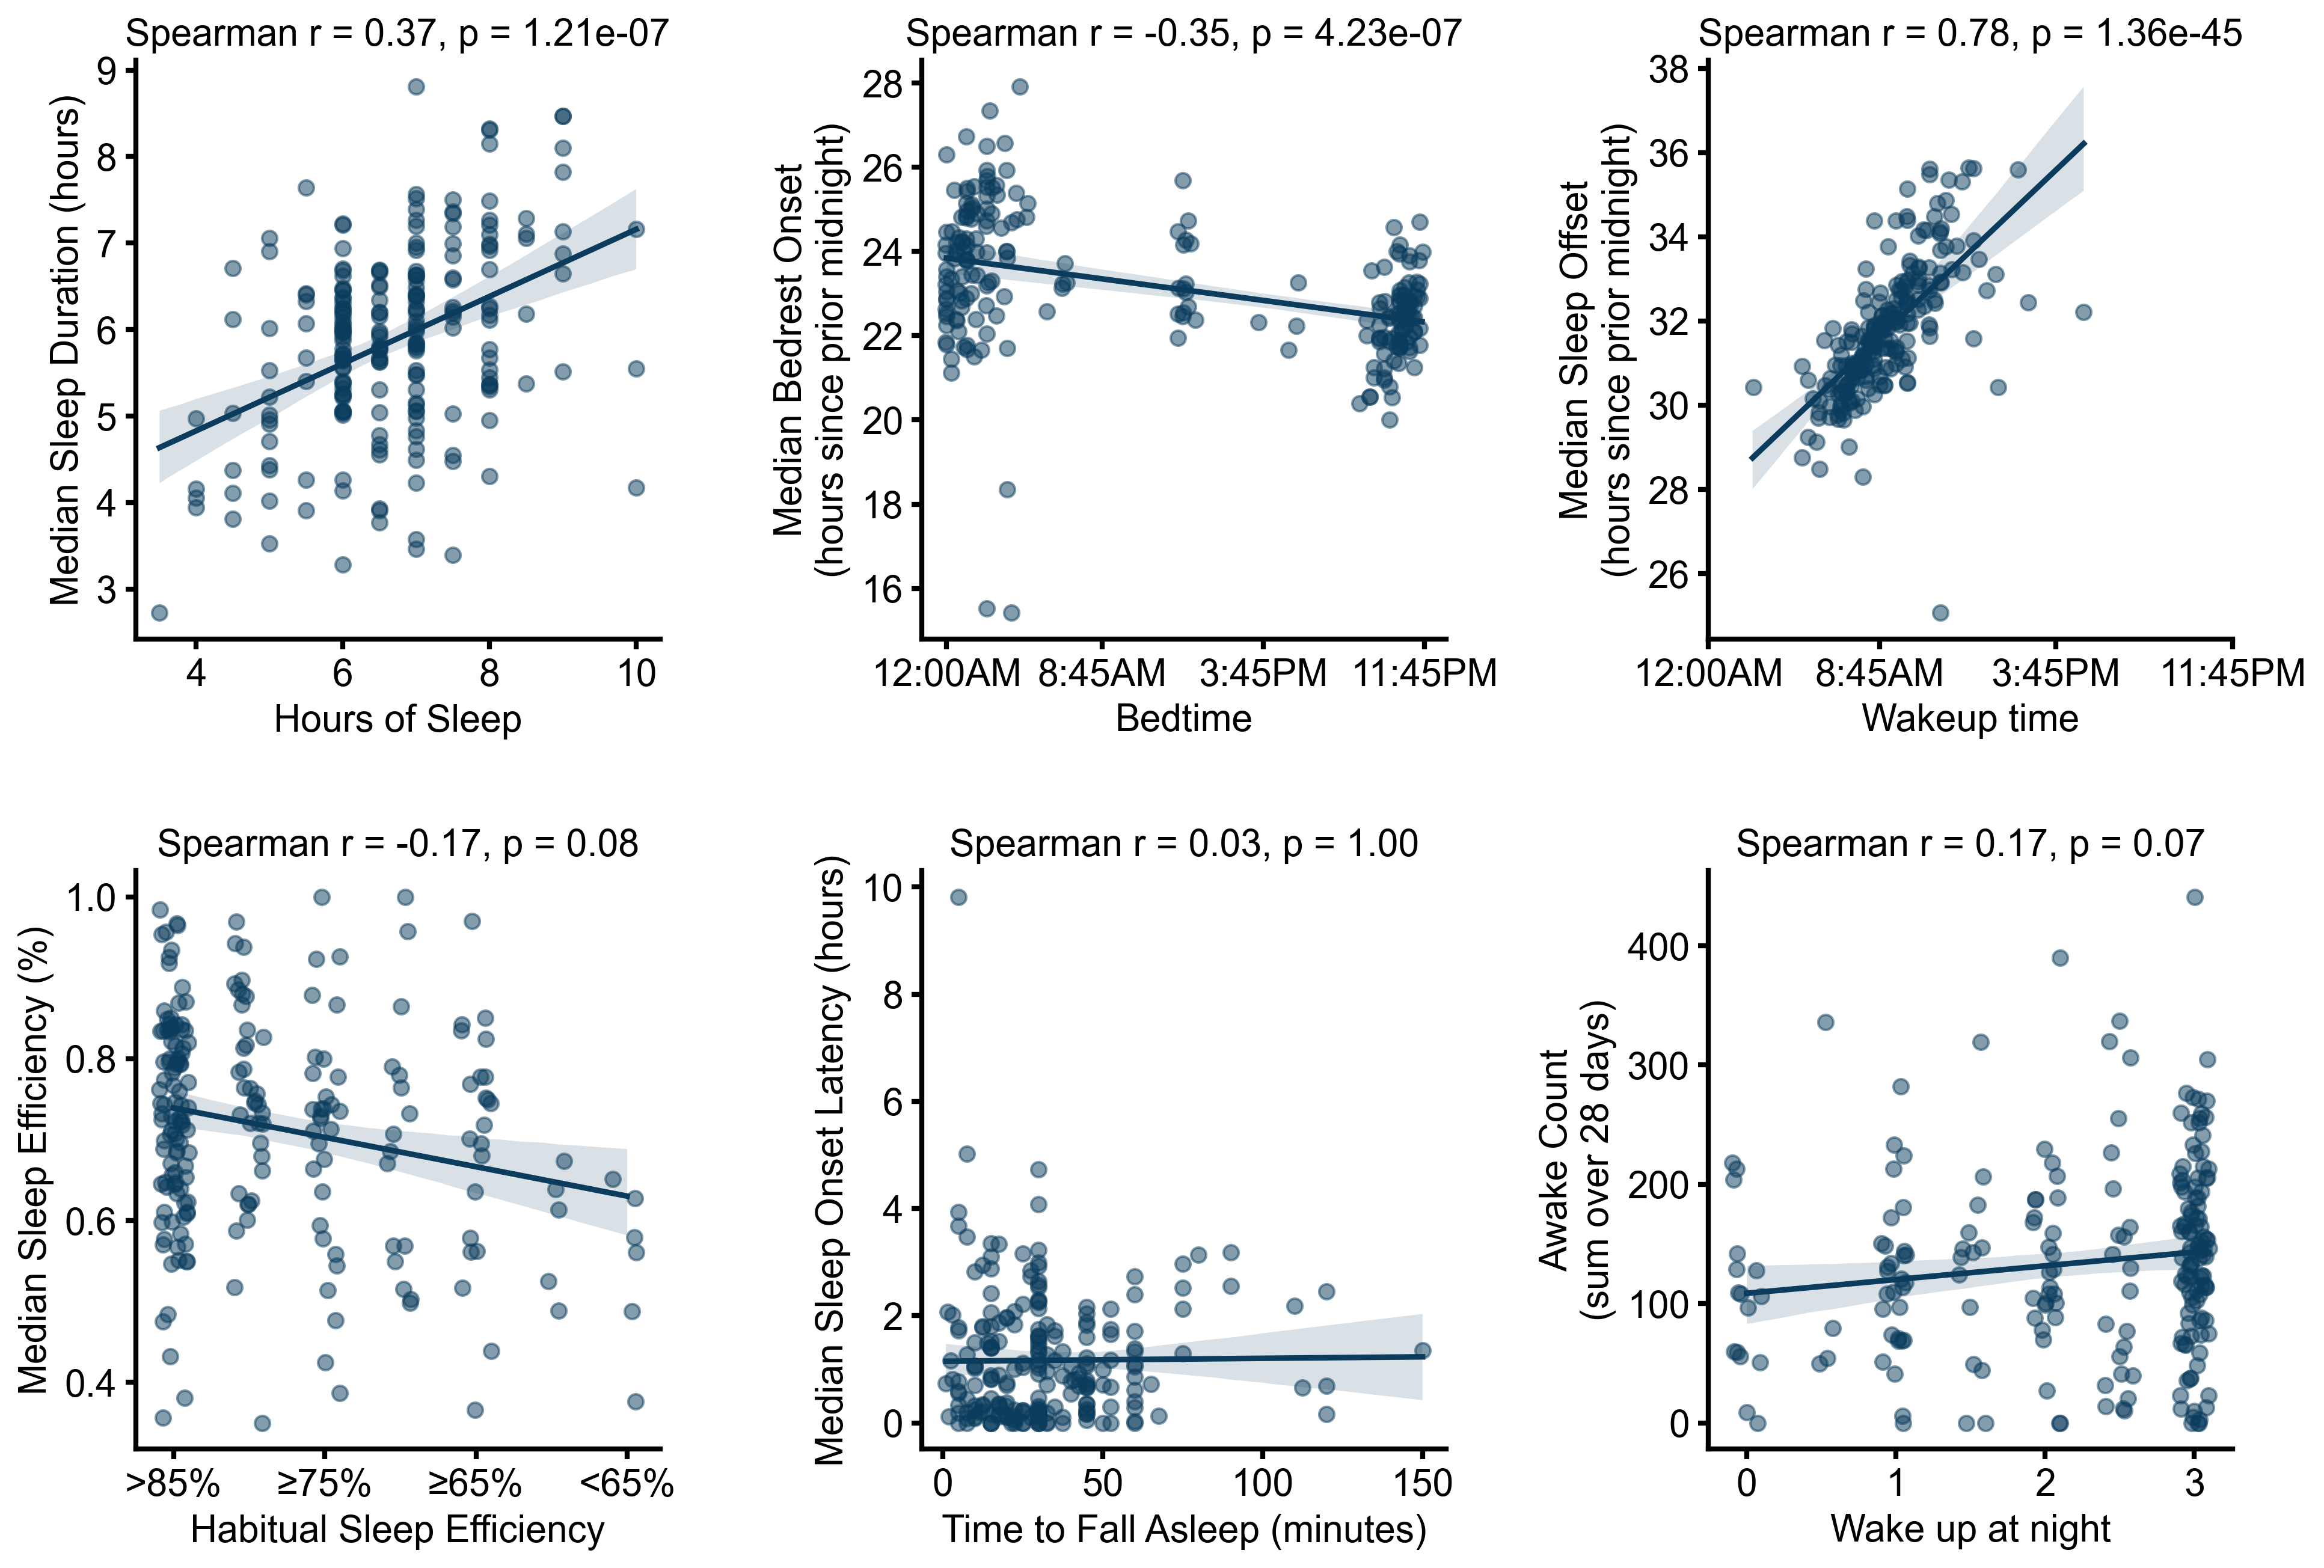

In [26]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(figsize=(5 * ncols, 5 * nrows), nrows=nrows, ncols=ncols)
plt.subplots_adjust(hspace=0.4, wspace=0.5)
for hk_f, psqi_f in sleep_quality_pairings:
    ax = axes.flatten()[sleep_quality_pairings.index((hk_f, psqi_f))]
    jitter = 0.1
    if psqi_f in ["time_fall_asleep", "hours_sleep"]:
        jitter = 0
    sns.regplot(
        data=psqi_piv_hk_agg,
        y=hk_f,
        x=psqi_f,
        ax=ax,
        color=ucla_darkest_blue,
        scatter_kws={"alpha": 0.5},
        x_jitter=jitter,
    )
    if psqi_f == "hse":
        ax.set_xticks([0, 1, 2, 3])
        ax.set_xticklabels([">85%", "≥75%", "≥65%", "<65%"])
    if psqi_f in ["bedtime", "wakeup"]:
        ax.set_xticks([1, 32, 64, 96])
        ax.set_xticklabels(["12:00AM", "8:45AM", "3:45PM", "11:45PM"])
    res = pg.pairwise_corr(
        psqi_piv_hk_agg,
        [psqi_f, hk_f],
        method="spearman",
    )
    p = res["p-unc"].values[0] * 6
    if p > 1:
        p = 1
    if p > 0.05:
        ax.set_title(
            f"Spearman r = {res['r'].values[0]:.2f}, p = {p:.2f}",
            fontsize=15,
        )
    else:
        ax.set_title(
            f"Spearman r = {res['r'].values[0]:.2f}, p = {p:.2e}",
            fontsize=15,
        )

    if hk_f in hk_unit_map:
        if len(hk_unit_map[hk_f]) > 10:
            ax.set_ylabel(main_features_map[hk_f] + f"\n({hk_unit_map[hk_f]})")
        else:
            ax.set_ylabel(main_features_map[hk_f] + f" ({hk_unit_map[hk_f]})")
    else:
        ax.set_ylabel(main_features_map[hk_f])
    ax.set_xlabel(item_map["psqi_" + psqi_f])
    fa.despine_thicken_axes(ax, fontsize=15)

## PSQI vs Watch with TestMyBrain


In [27]:
prescan_psqi = surveys[
    (surveys.redcap_event_name == "prescan_arm_1") & (surveys.survey == "psqi")
]
prescan_psqi["ID"] = prescan_psqi.record_id.str.split("_").str[1].astype("int")
prescan_window_agg = hk_agg_qc[hk_agg_qc.QC_expected_duration_days == 8]
prescan_feats = (
    prescan_psqi[["survey_start", "user_id", "ID"]]
    .drop_duplicates()
    .merge(prescan_window_agg, how="left", validate="1:1")
)
prescan_feats[main_features].count()

/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/3450565713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prescan_psqi["ID"] = prescan_psqi.record_id.str.split("_").str[1].astype("int")


sleep_sleepDuration_day_min            133
sleep_sleepDuration_day_max            133
sleep_sleepDuration_day_median         133
sleep_sleepDuration_day_std            126
sleep_sleepEfficiency_day_min          133
sleep_sleepEfficiency_day_max          133
sleep_sleepEfficiency_day_median       133
sleep_sleepEfficiency_day_std          126
sleep_Awake_mean                       144
sleep_Awake_count                      144
sleep_sleepOnsetLatency_day_min        133
sleep_sleepOnsetLatency_day_max        133
sleep_sleepOnsetLatency_day_median     133
sleep_sleepOnsetLatency_day_std        126
sleep_sleepOnsetHours_day_std          126
sleep_sleepOnsetHours_day_median       133
sleep_sleepOffsetHours_day_std         126
sleep_sleepOffsetHours_day_median      133
sleep_bedrestOffsetHours_day_std       139
sleep_bedrestOffsetHours_day_median    141
sleep_bedrestOnsetHours_day_std        139
sleep_bedrestOnsetHours_day_median     141
sleep_bedrestDuration_day_median       141
sleep_bedre

In [28]:
prescan_phq = surveys[
    (surveys.redcap_event_name == "prescan_arm_1") & (surveys.survey == "phq14")
]
prescan_phq["ID"] = prescan_phq.record_id.str.split("_").str[1].astype("int")

/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/1384870615.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prescan_phq["ID"] = prescan_phq.record_id.str.split("_").str[1].astype("int")


In [50]:
tmb_phq = tmb.reset_index().merge(
    prescan_phq.pivot_table(
        index="ID", columns="question", values="response"
    ).reset_index(),
)

tmb_phq_corr = pg.pairwise_corr(
    tmb_phq.astype(float),
    columns=[list(tmb_feats), ["phq14_total_score"]],
    method="spearman",
    nan_policy="pairwise",
    padjust="fdr_bh",
)
tmb_phq_corr.sort_values(by="p-unc", ascending=True)

X                  Y    method alternative    n  \
6          tmb_vocab_accuracy  phq14_total_score  spearman   two-sided  213   
7               tmb_vpt_score  phq14_total_score  spearman   two-sided  210   
3            tmb_gradcpt_crit  phq14_total_score  spearman   two-sided  199   
0  tmb_crt_rate_correct_score  phq14_total_score  spearman   two-sided  205   
4          tmb_gradcpt_dprime  phq14_total_score  spearman   two-sided  199   
1  tmb_dsc_rate_correct_score  phq14_total_score  spearman   two-sided  205   
2       tmb_emorecog_accuracy  phq14_total_score  spearman   two-sided  207   
5             tmb_mot_correct  phq14_total_score  spearman   two-sided  204   

          r          CI95%     p-unc    p-corr p-adjust     power  
6 -0.133579   [-0.26, 0.0]  0.051560  0.409017   fdr_bh  0.496592  
7 -0.113071  [-0.24, 0.02]  0.102254  0.409017   fdr_bh  0.373536  
3  0.100095  [-0.04, 0.24]  0.159531  0.425416   fdr_bh  0.291166  
0 -0.055075  [-0.19, 0.08]  0.432845  0.753201   fdr_bh  0.122982  
4 -0.051419  [-0.19, 0.09]  0.470751  0.753201   fdr_bh  0.111444  
1 -0.021656  [-0.16, 0.12]  0.757928  0.959204   fdr_bh  0.060890  
2  0.007550  [-0.13, 0.14]  0.914015  0.959204   fdr_bh  0.051261  
5  0.003604  [-0.13, 0.14]  0.959204  0.959204   fdr_bh  0.050222

In [51]:
tmb_phq_corr["TMB Metric"] = tmb_phq_corr["X"].map(tmb_map)
tmb_phq_corr[["TMB Metric", "n", "r", "p-corr"]].to_clipboard()

r  p-unc  \
X                                   Y                                          
distb                               tmb_dsc_rate_correct_score -0.287  0.000   
                                    tmb_crt_rate_correct_score -0.252  0.000   
sleep_bedrestOffsetHours_day_median tmb_crt_rate_correct_score  0.289  0.001   

                                                                  n  p-corr  
X                                   Y                                        
distb                               tmb_dsc_rate_correct_score  205   0.009  
                                    tmb_crt_rate_correct_score  205   0.074  
sleep_bedrestOffsetHours_day_median tmb_crt_rate_correct_score  130   0.234

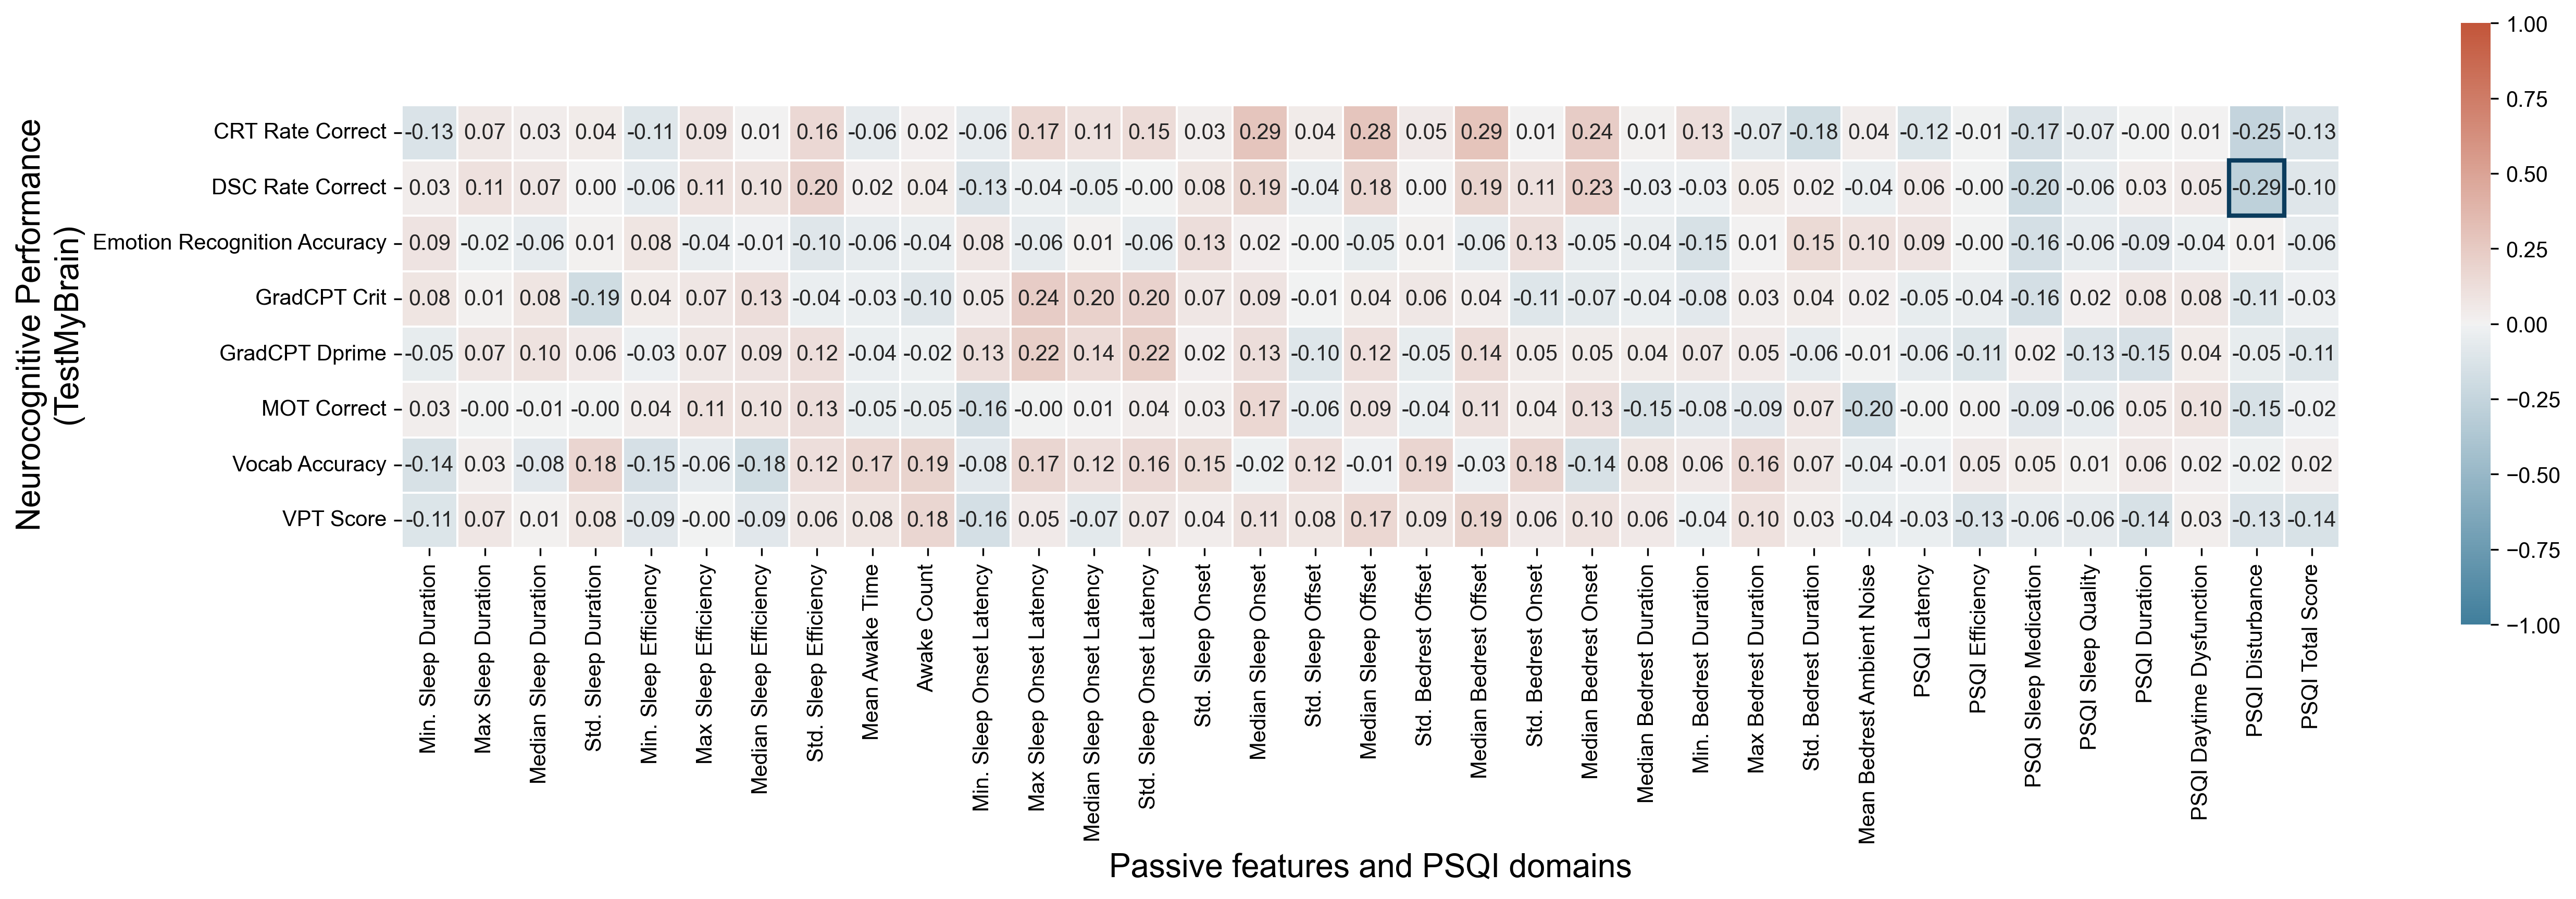

In [52]:
import matplotlib.patches as patches

# PSQI AND HK in one heatmap
median_feats = [c for c in main_features if "median" in c or "sum" in c] + [
    "bedrest_audioExposure_mean"
]
tmb_feats = list(tmb_feats)
psqi_qs = list(psqi_pallette.keys())
tmb_hk_psqi = (
    prescan_feats.set_index("ID")[main_features]
    .astype(float)
    .merge(tmb[tmb.index < 1000], left_index=True, right_index=True, how="outer")
    .merge(
        prescan_psqi[prescan_psqi.question.isin(psqi_qs)].pivot_table(
            index="ID", columns="question", values="response"
        ),
        left_index=True,
        right_index=True,
        how="outer",
    )
)


phq_qs = list(prescan_phq.question.unique())

tmb_hk_psqi_corr = pg.pairwise_corr(
    tmb_hk_psqi,
    columns=[main_features + psqi_qs, tmb_feats],
    method="spearman",
    nan_policy="pairwise",
    padjust="fdr_bh",
)
""" 
tmb_psqi_corr = pg.pairwise_corr(
    tmb_hk_psqi,
    columns=[psqi_qs, tmb_feats],
    method="spearman",
    nan_policy="pairwise",
    padjust="fdr_bh",
)
tmb_hk_corr = pg.pairwise_corr(
    tmb_hk_psqi,
    columns=[main_features, tmb_feats],
    method="spearman",
    nan_policy="pairwise",
    padjust="fdr_bh",
)
tmb_hk_psqi_corr = pd.concat([tmb_psqi_corr, tmb_hk_corr])
"""


tmb_hk_psqi_corr["not_sig"] = tmb_hk_psqi_corr["p-unc"] > 0.05
tmb_hk_psqi_corr_piv = tmb_hk_psqi_corr.pivot_table(index="Y", columns="X", values="r")[
    main_features + psqi_qs
]

tmb_hk_psqi_corr_piv_p = tmb_hk_psqi_corr.pivot_table(
    index="Y", columns="X", values="p-corr"
)[main_features + psqi_qs]


tmb_hk_psqi_corr_piv = tmb_hk_psqi_corr_piv.rename(
    columns={**main_features_map, **psqi_relabel_long}
)
tmb_hk_psqi_corr_piv = tmb_hk_psqi_corr_piv.rename(index=tmb_map)

fig, ax = plt.subplots(figsize=(20, 10))
plots.heatmap_correlation(tmb_hk_psqi_corr_piv, ax=ax)
ax.set_ylabel("Neurocognitive Performance\n(TestMyBrain)", fontsize=15)
ax.set_xlabel("Passive features and PSQI domains", fontsize=15)

# increase y-axis height
ax.set_ylim(len(tmb_hk_psqi_corr_piv.index), -0.1)
for j in range(len(tmb_hk_psqi_corr_piv_p.columns)):
    for i in range(len(tmb_hk_psqi_corr_piv_p.index)):
        if tmb_hk_psqi_corr_piv_p.iloc[i, j] <= 0.05:
            ax.add_patch(
                patches.Rectangle(
                    (j, i), 1, 1, fill=False, edgecolor=ucla_darkest_blue, lw=2
                )
            )


sig_corrs = tmb_hk_psqi_corr[
    (tmb_hk_psqi_corr["p-unc"] < 0.05) & (tmb_hk_psqi_corr["p-corr"] < 0.3)
].sort_values(by="p-unc")
sig_corrs.set_index(["X", "Y"])[["r", "p-unc", "n", "p-corr"]].round(3)

## Machine learning to predict PSQI domains


In [32]:
hk_agg_qc["QC_expected_duration_days"].value_counts()

QC_expected_duration_days
28.0    377
14.0    373
8.0     366
7.0     365
3.0     355
1.0     345
Name: count, dtype: int64

In [33]:
importlib.reload(ps)
rerun_cached = False
# rerun_cached = True
all_preds = []
feature_sets = {
    "passive": main_features,
    "prior_response": ["prior_response"],
    "passive_w_prior_response": main_features + ["prior_response"],
    #'passive_demog': main_features + demog_features,
}

for duration, sensor_df in hk_agg_qc.groupby("QC_expected_duration_days"):
    if duration not in [7, 14, 28]:
        continue
    print(f"Running for {duration} days")
    sensor_df = sensor_df.copy().dropna(subset=["sleep_sleepDuration_day_median"])
    for feature_set_type, feature_set in feature_sets.items():
        if feature_set_type != "passive":
            if duration != 28:
                continue
        out_folder = Path(
            cache_path,
            feature_set_type,
        )
        if not out_folder.exists():
            out_folder.mkdir(parents=True)
        print(f"\tRunning for {feature_set_type} features")
        surveys_copy = surveys.copy()
        surveys_copy["duration"] = f"{duration}D"
        inputs = [
            {
                "item_df": item_df,
                "sensor_features": sensor_df,
                "output_folder": out_folder,
                "feature_cols": feature_set,
                "model_paramgrid": model_paramgrid,
                "nona_cols": ["response_binary", "prior_response"],
                "rerun_cached": rerun_cached,
                "n_folds": 10,
            }
            for _, item_df in surveys_copy[
                (surveys_copy.survey == "psqi")
                & (surveys_copy.question.isin(psqi_relabel.keys()))
            ].groupby(["question", "survey"])
        ]
        preds = Parallel(n_jobs=8, verbose=10)(
            delayed(ps.train_test_item_wrapper)(**i) for i in inputs
        )
        preds_df = pd.concat(preds)
        preds_df["feature_set"] = feature_set_type
        all_preds.append(preds_df)

psqi_predictions = pd.concat(all_preds)

Running for 7.0 days
	Running for passive features


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Skipping psqi - meds_sleep - rf due to existing output
Skipping psqi - slpqual - rf due to existing output
Skipping psqi - distb - rf due to existing output
Skipping psqi - hse - rf due to existing output
Skipping psqi - total - rf due to existing output
Skipping psqi - laten - rf due to existing output
Skipping psqi - daydys - rf due to existing output
Skipping psqi - durat - rf due to existing output
Skipping psqi - distb - gb due to existing output
Skipping psqi - laten - gb due to existing output
Skipping psqi - daydys - gb due to existing outputSkipping psqi - hse - gb due to existing output
Skipping psqi - total - gb due to existing output

Skipping psqi - slpqual - gb due to existing output
Skipping psqi - meds_sleep - gb due to existing output
Skipping psqi - durat - gb due to existing output
Skipping psqi - daydys - lr due to existing output
Skipping psqi - laten - lr due to existing output
Skipping psqi - durat - lr due to existing output
Skipping psqi - meds_sleep - lr due t

[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    7.6s remaining:   22.8s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    7.6s remaining:   12.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    7.6s remaining:    7.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.6s remaining:    4.6s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    7.6s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Batch computation too fast (0.03084087371826172s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   

	Running for prior_response features
Skipping psqi - daydys - rf due to existing output
Skipping psqi - daydys - gb due to existing output
Skipping psqi - distb - rf due to existing output
Skipping psqi - daydys - lr due to existing output
Skipping psqi - durat - rf due to existing output
Skipping psqi - distb - gb due to existing output
Skipping psqi - daydys - dummy due to existing output
Skipping psqi - hse - rf due to existing output
Skipping psqi - distb - lr due to existing output
Skipping psqi - durat - gb due to existing output
Skipping psqi - hse - gb due to existing output
Skipping psqi - distb - dummy due to existing output
Skipping psqi - laten - rf due to existing output
Skipping psqi - durat - lr due to existing output
Skipping psqi - hse - lr due to existing output
Skipping psqi - durat - dummy due to existing output
Skipping psqi - laten - gb due to existing output
Skipping psqi - hse - dummy due to existing output
Skipping psqi - laten - lr due to existing output
Skipp

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Batch computation too fast (0.017600059509277344s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Batch computation too fast (0.022572755813598633s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  

In [34]:
psqi = surveys[
    (surveys.survey == "psqi") & (surveys.redcap_event_name != "baseline_arm_1")
]
print(
    "n users",
    psqi.user_id.nunique(),
    "n_psqi",
    psqi.groupby("user_id").survey_start.nunique().sum(),
)
print(
    "n users",
    psqi_predictions.user_id.nunique(),
    "n_psqi",
    psqi_predictions.groupby("user_id").survey_start.nunique().sum(),
)

n users 242 n_psqi 457
n users 221 n_psqi 365


### Performance across aggregation durations


In [35]:
importlib.reload(emp)
binary_performance_durat_df = emp.get_bootstrapped_performance(
    psqi_predictions[psqi_predictions.feature_set == "passive"],
    groupby=["duration", "model", "survey", "outcome", "fold"],
    unit="user_id",
    n_boot=100,
)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:   10.3s remaining:    0.9s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   10.9s finished


In [36]:
(
    best_model_durat_performance,
    best_model_durat_predictions,
    best_models_durat,
) = emp.get_best_model_performance_and_predictions(
    binary_performance_durat_df,
    psqi_predictions[psqi_predictions.feature_set == "passive"],
    metric="test_roc_auc",
    groupby=["duration", "outcome"],
)

binary_performance_test = testBinaryPerformance(
    best_model_durat_performance, groupby=["duration", "outcome"]
)


binary_performance_test = binary_performance_test.groupby("duration").apply(adjust_pval)
binary_performance_test = binary_performance_test.sort_values("p_adj", ascending=True)

Testing performance:   0%|          | 0/24 [00:00<?, ?it/s]/Users/sakre/Library/Caches/pypoetry/virtualenvs/optima-sleep-quality-iuf0c8lK-py3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/sakre/Library/Caches/pypoetry/virtualenvs/optima-sleep-quality-iuf0c8lK-py3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/sakre/Library/Caches/pypoetry/virtualenvs/optima-sleep-quality-iuf0c8lK-py3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
Testing performance: 100%|██████████| 24/24 [00:00<00:00, 458.13it/s]

          W-val alternative     p-val       RBC  CLES
Wilcoxon   38.0     greater  0.161133  0.381818   0.6
          W-val alternative     p-val       RBC  CLES
Wilcoxon   47.0     greater  0.024414  0.709091   0.8
          W-val alternative     p-val       RBC  CLES
Wilcoxon   54.0     greater  0.001953  0.963636   0.9
          W-val alternative     p-val       RBC  CLES
Wilcoxon   38.0     greater  0.161133  0.381818   0.7
          W-val alternative    p-val       RBC  CLES
Wilcoxon   36.0     greater  0.21582  0.309091   0.6
          W-val alternative   p-val  RBC  CLES
Wilcoxon   33.0     greater  0.3125  0.2   0.7
   p-val
0      1
          W-val alternative     p-val       RBC  CLES
Wilcoxon   31.0     greater  0.384766  0.127273   0.5
          W-val alternative     p-val  RBC  CLES
Wilcoxon   55.0     greater  0.000977  1.0   1.0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   48.0     greater  0.018555  0.745455   0.8
          W-val alternative    p-val


/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/408814606.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  binary_performance_test = binary_performance_test.groupby("duration").apply(adjust_pval)


/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/3395275187.py:124: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(
/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/3395275187.py:134: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/3395275187.py:124: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(
/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/3395275187.py:134: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


Text(0.5, 0.98, 'PSQI passive prediction by aggregation duration')

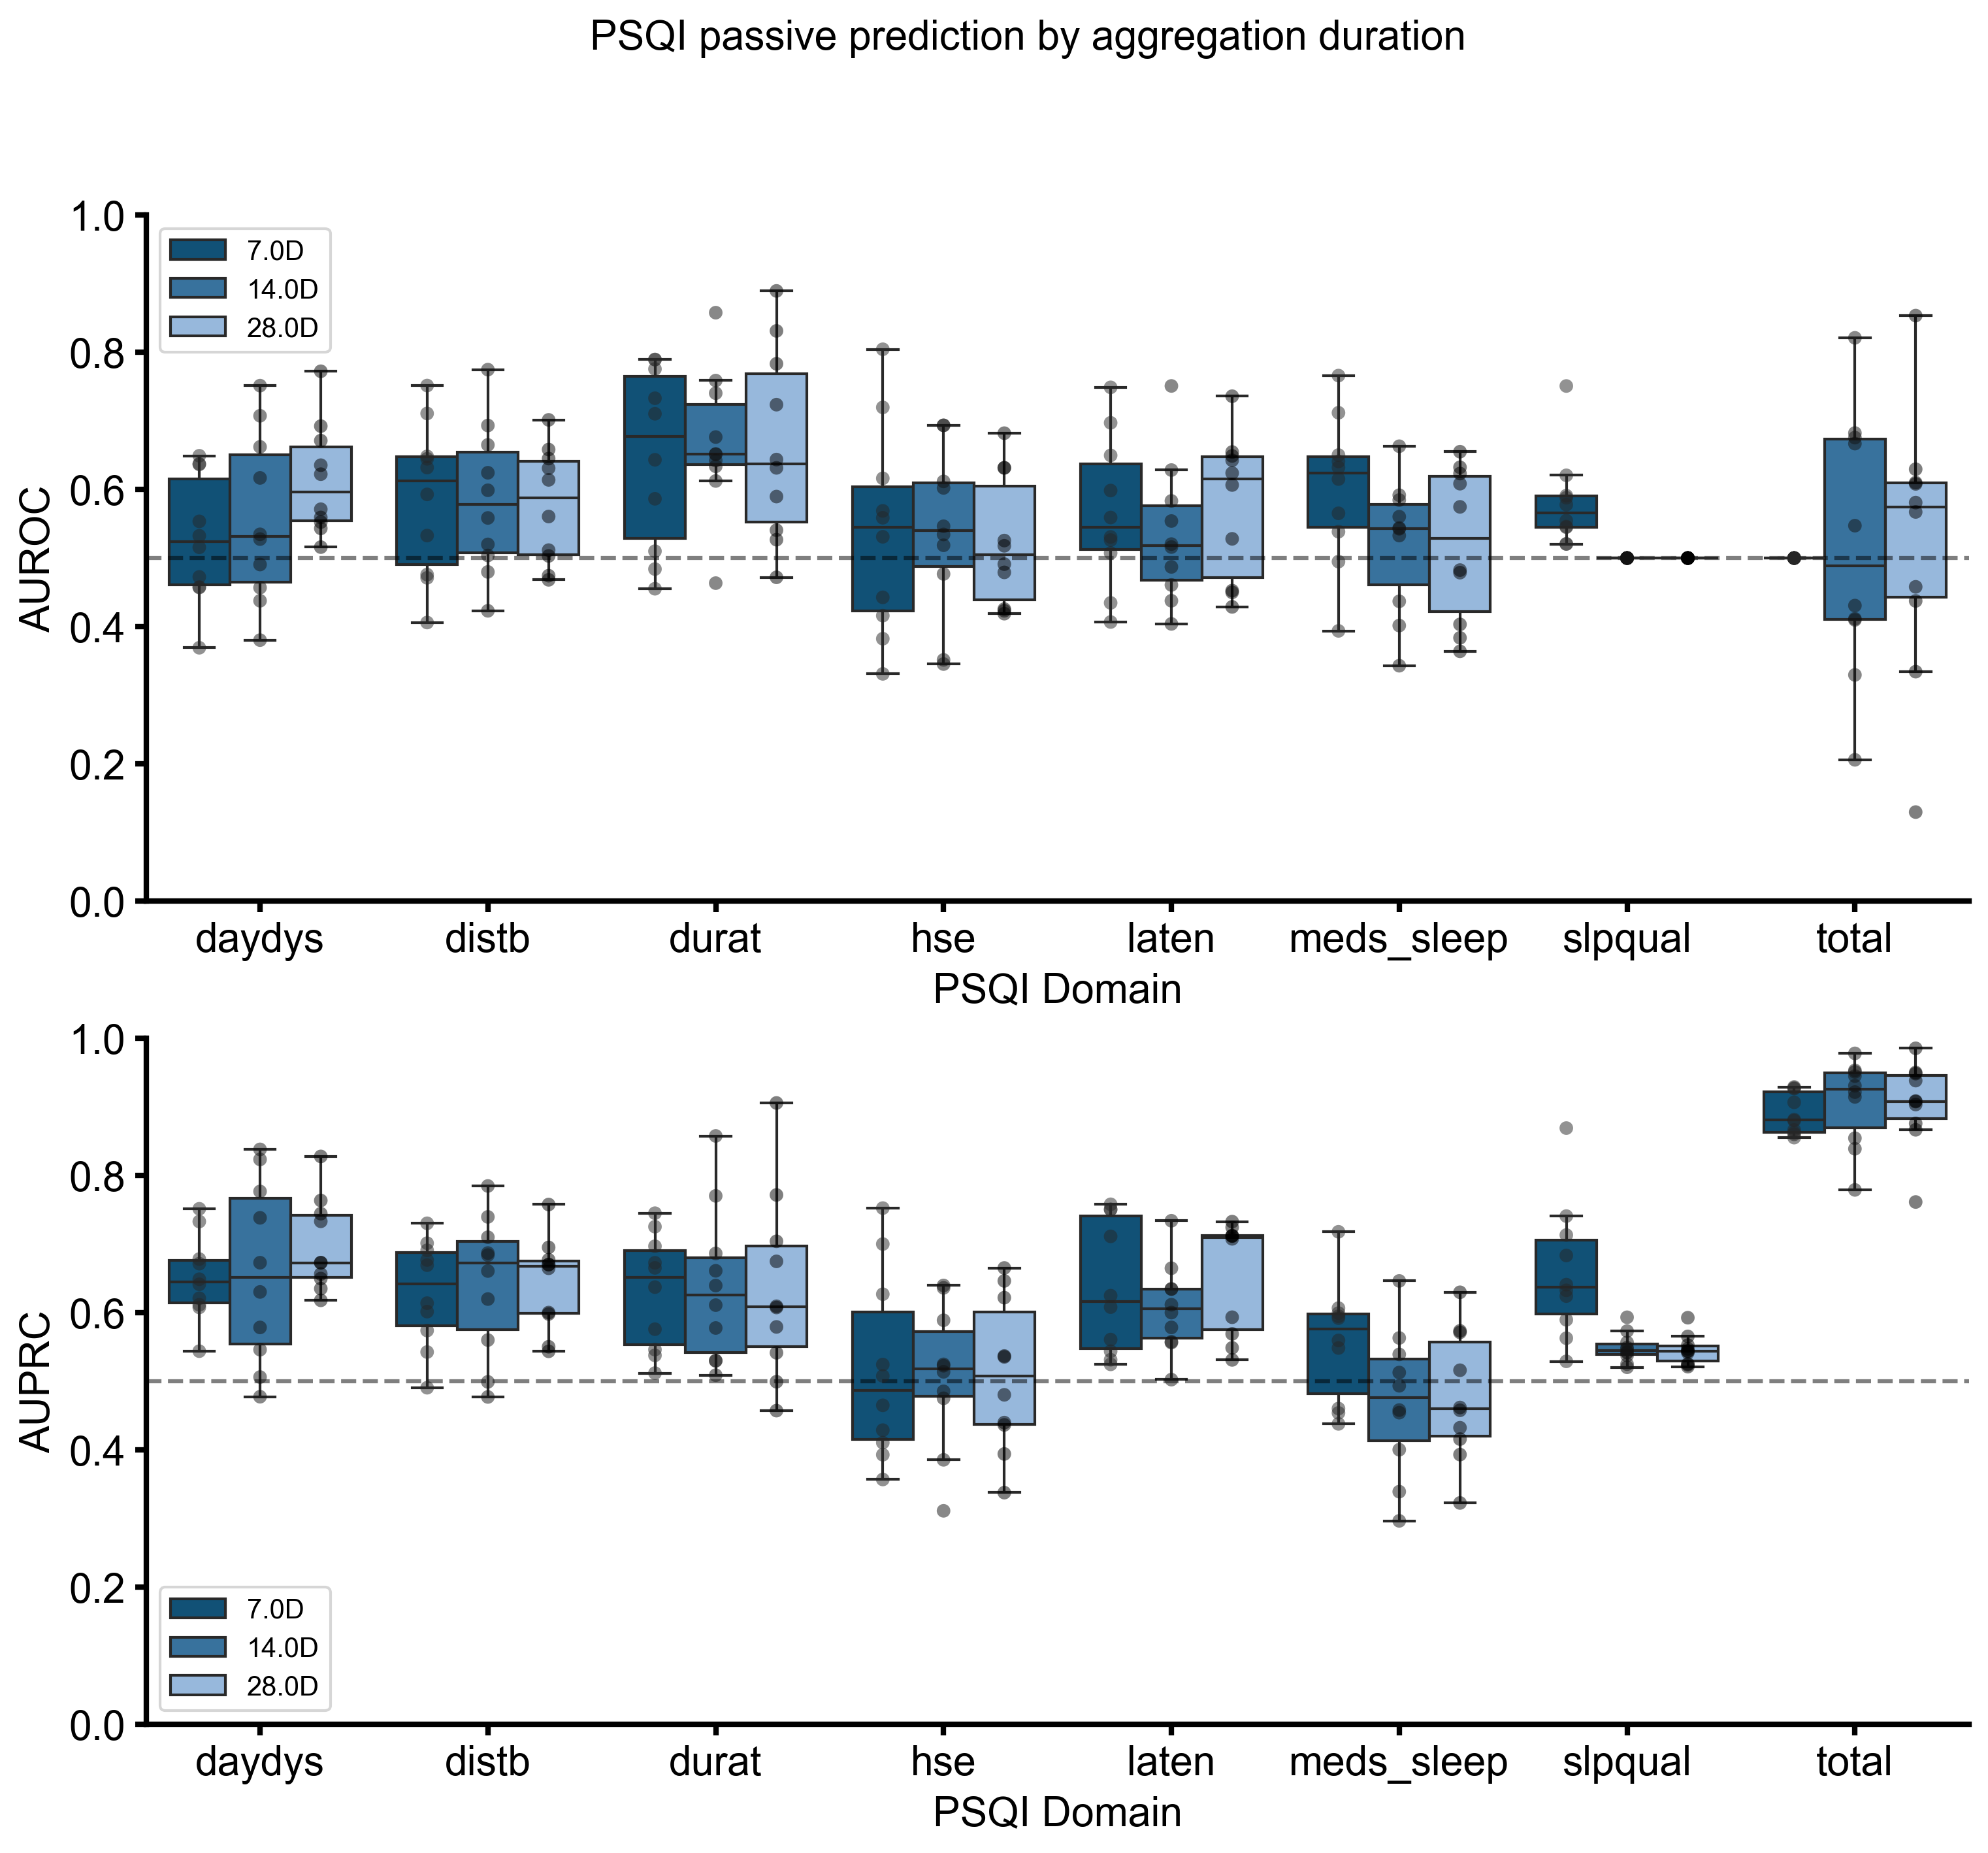

In [37]:
perf_df = best_model_durat_performance  # binary_performance_feature_set_type_df
hue_order = ["7.0D", "14.0D", "28.0D"]

fig, axes = plt.subplots(figsize=(12, 10), nrows=2)
ax = plot_performance(
    perf_df,
    "roc_auc",
    hue_order=hue_order,
    ax=axes[0],
    ylim=(0, 1),
    hline=0.5,
    hue_col="duration",
    palette=ucla_blues[1:],
)
ax.set_xlabel("PSQI Domain")
ax.set_ylabel("AUROC")
ax = plot_performance(
    perf_df,
    "average_precision",
    hue_order=hue_order,
    ax=axes[1],
    ylim=(0, 1),
    hline=0.5,
    hue_col="duration",
    palette=ucla_blues[1:],
)
ax.set_xlabel("PSQI Domain")
ax.set_ylabel("AUPRC")
plt.suptitle("PSQI passive prediction by aggregation duration", fontsize=15)

### Performance across feature inputs


In [38]:
binary_performance_feature_df = emp.get_bootstrapped_performance(
    psqi_predictions[psqi_predictions.duration == "28.0D"],
    groupby=["feature_set", "model", "survey", "outcome", "fold"],
    unit="user_id",
    n_boot=100,
)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:   10.5s remaining:    0.9s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   11.0s finished


In [39]:
(
    best_model_feature_performance,
    best_model_feature_predictions,
    best_models_feature,
) = emp.get_best_model_performance_and_predictions(
    binary_performance_feature_df,
    psqi_predictions[psqi_predictions.duration == "28.0D"],
    metric="test_roc_auc",
    groupby=["feature_set", "outcome"],
)

binary_performance_test = testBinaryPerformance(
    best_model_feature_performance,
    groupby=["feature_set", "outcome", "model"],
)

binary_performance_test = binary_performance_test.groupby("feature_set").apply(
    adjust_pval
)
binary_performance_test = binary_performance_test.sort_values("p_adj", ascending=True)
binary_psqi_perfomance_test = binary_performance_test.copy()
binary_performance_test

Testing performance:   0%|          | 0/24 [00:00<?, ?it/s]/Users/sakre/Library/Caches/pypoetry/virtualenvs/optima-sleep-quality-iuf0c8lK-py3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
Testing performance: 100%|██████████| 24/24 [00:00<00:00, 377.78it/s]

          W-val alternative     p-val  RBC  CLES
Wilcoxon   55.0     greater  0.000977  1.0   1.0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   48.0     greater  0.018555  0.745455   0.8
          W-val alternative    p-val       RBC  CLES
Wilcoxon   53.0     greater  0.00293  0.927273   0.9
          W-val alternative     p-val       RBC  CLES
Wilcoxon   35.0     greater  0.246094  0.272727   0.6
          W-val alternative     p-val       RBC  CLES
Wilcoxon   46.0     greater  0.032227  0.672727   0.7
          W-val alternative   p-val  RBC  CLES
Wilcoxon   33.0     greater  0.3125  0.2   0.5
   p-val
0      1
          W-val alternative    p-val       RBC  CLES
Wilcoxon   34.0     greater  0.27832  0.236364   0.6
          W-val alternative     p-val  RBC  CLES
Wilcoxon   55.0     greater  0.000977  1.0   1.0
          W-val alternative     p-val  RBC  CLES
Wilcoxon   55.0     greater  0.000977  1.0   1.0
          W-val alternative     p-val  RBC  CLES
Wilcoxon 


/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/3408692762.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  binary_performance_test = binary_performance_test.groupby("feature_set").apply(


W-val alternative     p-val       RBC  \
feature_set                                                                
passive                  Wilcoxon   55.0     greater  0.000977  1.000000   
prior_response           Wilcoxon   55.0     greater  0.000977  1.000000   
                         Wilcoxon   55.0     greater  0.000977  1.000000   
                         Wilcoxon   54.0     greater  0.001953  0.963636   
                         Wilcoxon   55.0     greater  0.000977  1.000000   
                         Wilcoxon   55.0     greater  0.000977  1.000000   
                         Wilcoxon   55.0     greater  0.000977  1.000000   
passive_w_prior_response Wilcoxon   55.0     greater  0.000977  1.000000   
                         Wilcoxon   55.0     greater  0.000977  1.000000   
                         Wilcoxon   55.0     greater  0.000977  1.000000   
                         Wilcoxon   55.0     greater  0.000977  1.000000   
                         Wilcoxon   53.0     greater  0.002930  0.927273   
                         Wilcoxon   55.0     greater  0.000977  1.000000   
                         Wilcoxon   55.0     greater  0.000977  1.000000   
                         Wilcoxon   55.0     greater  0.000977  1.000000   
prior_response           Wilcoxon   55.0     greater  0.000977  1.000000   
                         Wilcoxon   55.0     greater  0.000977  1.000000   
passive                  Wilcoxon   53.0     greater  0.002930  0.927273   
                         Wilcoxon   48.0     greater  0.018555  0.745455   
                         Wilcoxon   46.0     greater  0.032227  0.672727   
                         Wilcoxon   34.0     greater  0.278320  0.236364   
                         Wilcoxon   33.0     greater  0.312500  0.200000   
                         Wilcoxon   35.0     greater  0.246094  0.272727   
                         0           NaN         NaN  1.000000       NaN   

                                   CLES               feature_set     outcome  \
feature_set                                                                     
passive                  Wilcoxon   1.0                   passive      daydys   
prior_response           Wilcoxon   1.0            prior_response  meds_sleep   
                         Wilcoxon   1.0            prior_response       laten   
                         Wilcoxon   0.9            prior_response         hse   
                         Wilcoxon   1.0            prior_response       durat   
                         Wilcoxon   1.0            prior_response       distb   
                         Wilcoxon   1.0            prior_response      daydys   
passive_w_prior_response Wilcoxon   1.0  passive_w_prior_response       total   
                         Wilcoxon   1.0  passive_w_prior_response     slpqual   
                         Wilcoxon   1.0  passive_w_prior_response  meds_sleep   
                         Wilcoxon   1.0  passive_w_prior_response       laten   
                         Wilcoxon   0.9  passive_w_prior_response         hse   
                         Wilcoxon   1.0  passive_w_prior_response       durat   
                         Wilcoxon   1.0  passive_w_prior_response       distb   
                         Wilcoxon   1.0  passive_w_prior_response      daydys   
prior_response           Wilcoxon   1.0            prior_response     slpqual   
                         Wilcoxon   1.0            prior_response       total   
passive                  Wilcoxon   0.9                   passive       durat   
                         Wilcoxon   0.8                   passive       distb   
                         Wilcoxon   0.7                   passive       laten   
                         Wilcoxon   0.6                   passive       total   
                         Wilcoxon   0.5                   passive  meds_sleep   
                         Wilcoxon   0.6                   passive         hse   
                         0       

In [40]:
sig_tests = binary_performance_test[
    (binary_performance_test["p_adj"] < 0.05)
    & (binary_performance_test["feature_set"] == "passive")
]
sig_tests[["outcome", "median_auroc", "p_adj"]]

outcome  median_auroc     p_adj
feature_set                                         
passive     Wilcoxon  daydys      0.602444  0.007812
            Wilcoxon   durat      0.631793  0.020508

In [53]:
# Paired t-test between prior_response and passive_w_prior_response for each domain

paired_ttest_results = []
for domain, domain_df in best_model_feature_performance[
    best_model_feature_performance.survey == "psqi"
].groupby("outcome"):
    piv = domain_df.pivot_table(
        index="fold", columns="feature_set", values="test_roc_auc"
    )
    ttest_res = pg.wilcoxon(
        piv["prior_response"],
        piv["passive_w_prior_response"],
        alternative="less",
    )
    ttest_res["domain"] = domain
    ttest_res["mean_diff"] = (
        -1 * (piv["prior_response"] - piv["passive_w_prior_response"]).mean()
    )
    paired_ttest_results.append(ttest_res)
paired_ttest_results = pd.concat(paired_ttest_results)
paired_ttest_results["p_adj"] = pg.multicomp(
    paired_ttest_results["p-val"], method="fdr_bh"
)[1]
sig_paired = paired_ttest_results[paired_ttest_results.p_adj < 0.05].sort_values(
    by="p_adj"
)
print("Significant AUROC differences:", sig_paired.shape[0])
paired_ttest_results.sort_values(by="p_adj")

Significant AUROC differences: 0


W-val alternative     p-val       RBC  CLES      domain  mean_diff  \
Wilcoxon   22.0        less  0.312500 -0.200000  0.56      daydys   0.023491   
Wilcoxon   20.0        less  0.246094 -0.272727  0.52       distb   0.009389   
Wilcoxon   23.0        less  0.347656 -0.163636  0.58       durat   0.003524   
Wilcoxon   37.0        less  0.838867  0.345455  0.49         hse  -0.018742   
Wilcoxon   28.0        less  0.539062  0.018182  0.56       laten  -0.000921   
Wilcoxon   32.0        less  0.687500  0.163636  0.53  meds_sleep  -0.001136   
Wilcoxon   39.0        less  0.883789  0.418182  0.42     slpqual  -0.018096   
Wilcoxon   44.0        less  0.958008  0.600000  0.38       total  -0.031949   

             p_adj  
Wilcoxon  0.927083  
Wilcoxon  0.927083  
Wilcoxon  0.927083  
Wilcoxon  0.958008  
Wilcoxon  0.958008  
Wilcoxon  0.958008  
Wilcoxon  0.958008  
Wilcoxon  0.958008

In [54]:
# Paired t-test between prior_response and passive_w_prior_response for each domain

paired_ttest_results = []
for domain, domain_df in best_model_feature_performance[
    best_model_feature_performance.survey == "psqi"
].groupby("outcome"):
    piv = domain_df.pivot_table(
        index="fold", columns="feature_set", values="test_average_precision"
    )
    ttest_res = pg.wilcoxon(
        piv["prior_response"],
        piv["passive_w_prior_response"],
        alternative="less",
    )
    ttest_res["domain"] = domain
    ttest_res["median_diff"] = (
        -1 * (piv["prior_response"] - piv["passive_w_prior_response"]).median()
    )
    paired_ttest_results.append(ttest_res)
paired_ttest_results = pd.concat(paired_ttest_results)
paired_ttest_results["p_adj"] = pg.multicomp(
    paired_ttest_results["p-val"], method="fdr_bh"
)[1]
sig_paired = paired_ttest_results[paired_ttest_results.p_adj < 0.05].sort_values(
    by="p_adj"
)
sig_paired

W-val alternative     p-val       RBC  CLES      domain  \
Wilcoxon    0.0        less  0.000977 -1.000000   0.8      daydys   
Wilcoxon    5.0        less  0.009766 -0.818182   0.7  meds_sleep   

          median_diff     p_adj  
Wilcoxon     0.046159  0.007812  
Wilcoxon     0.064069  0.039062

In [55]:
best_model_feature_performance.groupby(["feature_set", "outcome"]).test_roc_auc.mean()

feature_set               outcome   
passive                   daydys        0.615896
                          distb         0.577943
                          durat         0.664171
                          hse           0.529819
                          laten         0.578405
                          meds_sleep    0.524417
                          slpqual       0.500000
                          total         0.525157
passive_w_prior_response  daydys        0.727602
                          distb         0.807880
                          durat         0.789612
                          hse           0.652124
                          laten         0.859541
                          meds_sleep    0.874743
                          slpqual       0.769771
                          total         0.836666
prior_response            daydys        0.704111
                          distb         0.798491
                          durat         0.786088
                          hse   

/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/3395275187.py:124: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(
/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/3395275187.py:134: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/3395275187.py:124: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(
/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/3395275187.py:134: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


Text(0, 0.5, 'AUPRC')

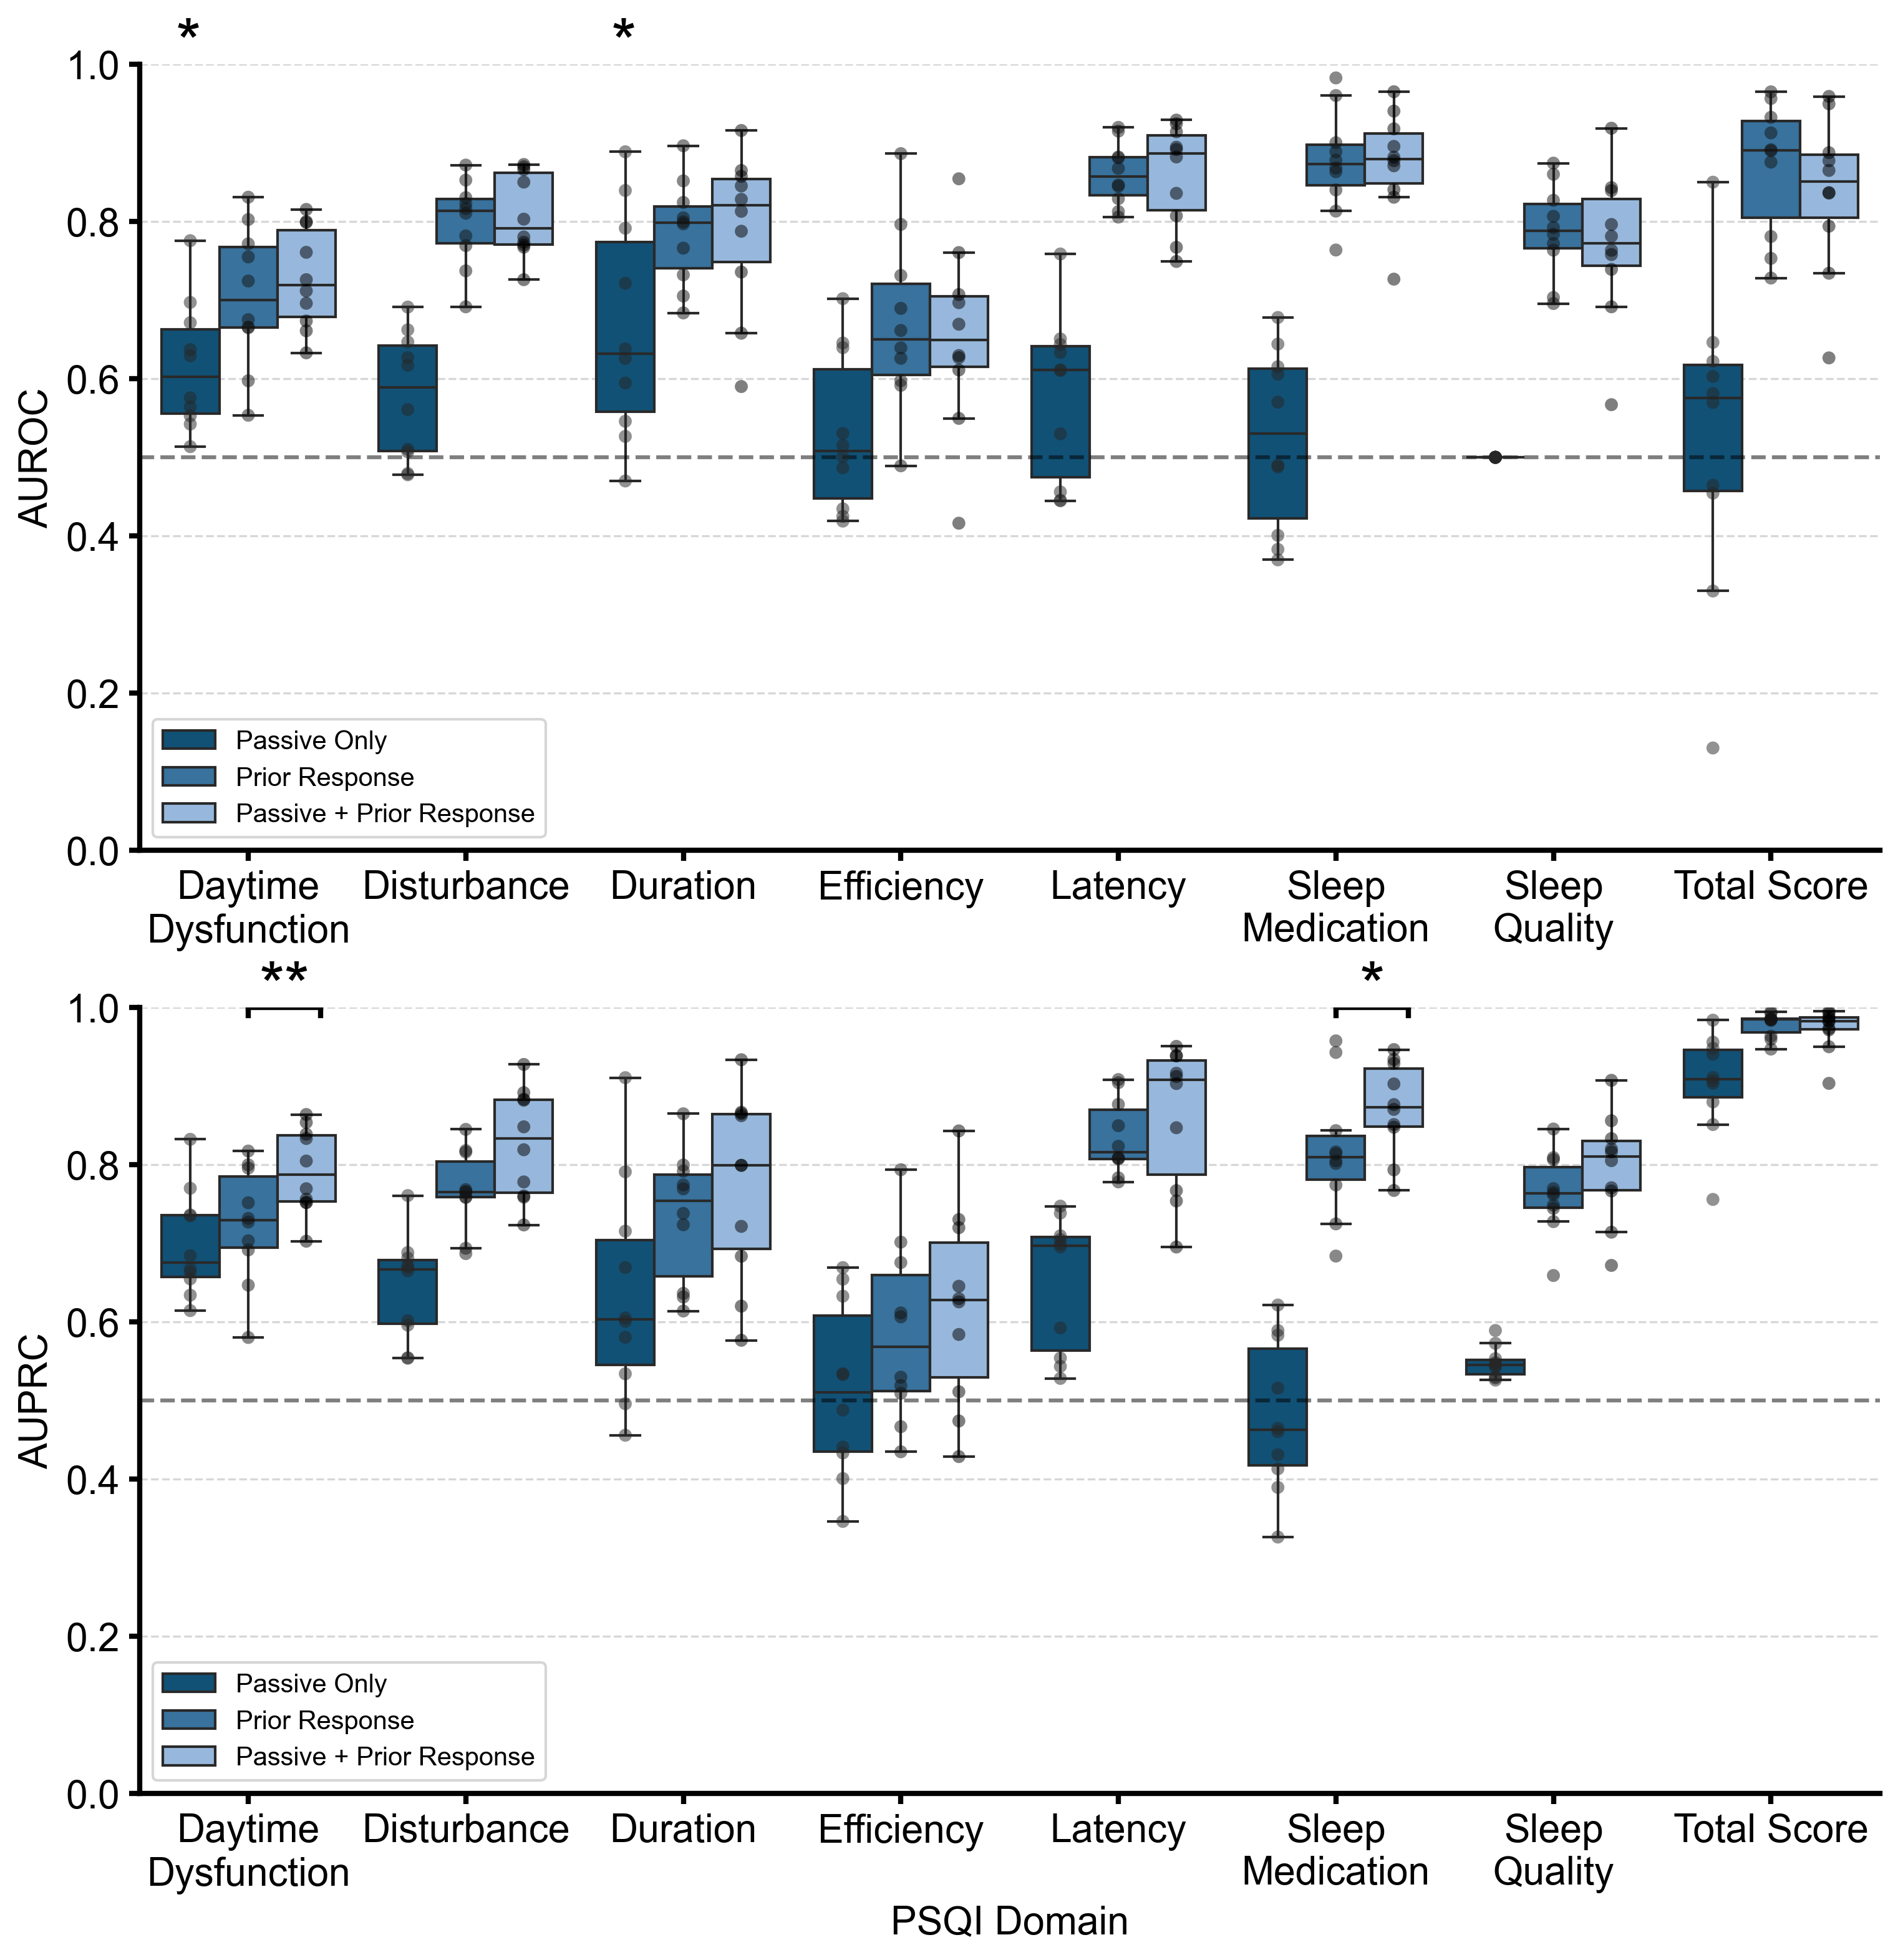

In [56]:
perf_df = (
    best_model_feature_performance.copy()
)  # binary_performance_feature_set_type_df
perf_df["outcome"] = perf_df["outcome"].map(psqi_relabel)
perf_df["Features"] = perf_df["feature_set"].map(feature_set_map)
hue_order = [ft for ft in feature_set_map.values()]
label_order = [ft for ft in psqi_relabel.values()]

# Remove passive with demographics
hue_order = hue_order[:-1]

fig, axes = plt.subplots(figsize=(12, 12), nrows=2)
ax = axes[0]
plot_performance(
    perf_df,
    "roc_auc",
    hue_order=hue_order,
    ax=ax,
    ylim=(0, 1),
    hline=0.5,
    hue_col="Features",
    palette=ucla_blues[1:],
)
ax.grid(axis="y", linestyle="--", alpha=0.5)
# ax.set_xlabel('PSQI Domain')
ax.set_ylabel("AUROC")
for i, row in sig_tests.iterrows():
    ax.annotate(
        "*",
        xy=(label_order.index(psqi_relabel[row["outcome"]]) - (1 / 3), 1),
        fontsize=25,
        color="black",
    )


ax = axes[1]
ax = plot_performance(
    perf_df,
    "average_precision",
    hue_order=hue_order,
    ax=ax,
    ylim=(0, 1),
    hline=0.5,
    hue_col="Features",
    palette=ucla_blues[1:],
)
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Annotate significant differences
for i, row in sig_paired.iterrows():
    annot = "*"
    if row["p_adj"] < 0.01:
        annot = "**"
    elif row["p_adj"] < 0.001:
        annot = "***"
    ax.annotate(
        annot,
        xy=(label_order.index(psqi_relabel[row["domain"]]) + (1 / 6), 1),
        fontsize=25,
        color="black",
        ha="center",
    )
    # Make line connected to annotation
    ax.plot(
        [
            label_order.index(psqi_relabel[row["domain"]]),
            label_order.index(psqi_relabel[row["domain"]]) + (1 / 3),
        ],
        [1, 1],
        color="black",
        linestyle="-",
        lw=2,
    )
    # Add verticle lines at ends of annotation line
    ax.plot(
        [
            label_order.index(psqi_relabel[row["domain"]]),
            label_order.index(psqi_relabel[row["domain"]]),
        ],
        [1, 0.99],
        color="black",
        linestyle="-",
        lw=2,
    )
    ax.plot(
        [
            label_order.index(psqi_relabel[row["domain"]]) + (1 / 3),
            label_order.index(psqi_relabel[row["domain"]]) + (1 / 3),
        ],
        [1, 0.99],
        color="black",
        linestyle="-",
        lw=2,
    )

ax.set_xlabel("PSQI Domain")
ax.set_ylabel("AUPRC")

# Detecting PHQ-14 Items

## Aggregate prior to PHQ-14 Items


In [57]:
agg_windows = [8]


use_cache = True
current_month = pd.Timestamp.now().month
out_path = Path(
    cache_path,
    f"PHQ-hkFeatureAgg-{agg_windows}days_{current_month}.csv",
)
phq_timestamps = surveys.loc[
    (surveys.survey == "phq14") & (surveys.redcap_event_name != "baseline_arm_1"),
    ["user_id", "survey_start"],
].drop_duplicates()

if use_cache and out_path.exists():
    hk_agg_phq = pd.read_csv(out_path, parse_dates=["survey_start"])
else:
    agg_durations = [f"{w}D" for w in agg_windows]
    hk_agg_list = Parallel(n_jobs=10, verbose=10)(
        delayed(gatherUserMetrics)(user_id, t_df, agg_durations)
        for user_id, t_df in phq_timestamps.groupby("user_id")
    )
    hk_agg_phq = pd.concat(hk_agg_list)
    hk_agg_phq.to_csv(out_path, index=False)

hk_agg_phq.groupby("QC_expected_duration").user_id.nunique()

QC_expected_duration
8D    249
Name: user_id, dtype: int64

In [58]:
hk_agg_phq_qc = healthKitQCFillNan(
    hk_agg_phq,
    watch_on_threshold=0.8,
    duration_threshold=0.8,
    no_na_features=[],
)
hk_agg_phq_qc.groupby(
    "QC_expected_duration_days"
).user_id.nunique(), hk_agg_phq_qc.shape

Watch on threshold removed 20 rows
Duration threshold removed 206 rows
QC removed 226 rows (12.0%)


(QC_expected_duration_days
 8.0    249
 Name: user_id, dtype: int64,
 (1707, 186))

In [59]:
use_window_agg = hk_agg_phq_qc.dropna(subset=["sleep_sleepDuration_day_median"])

print(hk_agg_phq.shape, hk_agg_phq.user_id.nunique())
use_window_agg.shape, use_window_agg.user_id.nunique()

(1933, 185) 249


((1565, 186), 247)

In [60]:
na_count = use_window_agg[main_features].isna().sum()
totals = use_window_agg[main_features].count()
na_perc_phq = na_count / totals
na_phq = pd.concat([totals, na_count, na_perc_phq], axis=1)
na_phq.columns = ["PHQ-14 total", "PHQ-14 missing", "PHQ-14 missing %"]
na_phq

PHQ-14 total  PHQ-14 missing  \
sleep_sleepDuration_day_min                  1565               0   
sleep_sleepDuration_day_max                  1565               0   
sleep_sleepDuration_day_median               1565               0   
sleep_sleepDuration_day_std                  1503              62   
sleep_sleepEfficiency_day_min                1565               0   
sleep_sleepEfficiency_day_max                1565               0   
sleep_sleepEfficiency_day_median             1565               0   
sleep_sleepEfficiency_day_std                1503              62   
sleep_Awake_mean                             1565               0   
sleep_Awake_count                            1565               0   
sleep_sleepOnsetLatency_day_min              1565               0   
sleep_sleepOnsetLatency_day_max              1565               0   
sleep_sleepOnsetLatency_day_median           1565               0   
sleep_sleepOnsetLatency_day_std              1503              62   
sleep_sleepOnsetHours_day_std                1503              62   
sleep_sleepOnsetHours_day_median             1565               0   
sleep_sleepOffsetHours_day_std               1503              62   
sleep_sleepOffsetHours_day_median            1565               0   
sleep_bedrestOffsetHours_day_std             1551              14   
sleep_bedrestOffsetHours_day_median          1565               0   
sleep_bedrestOnsetHours_day_std              1551              14   
sleep_bedrestOnsetHours_day_median           1565               0   
sleep_bedrestDuration_day_median             1565               0   
sleep_bedrestDuration_day_min                1565               0   
sleep_bedrestDuration_day_max                1565               0   
sleep_bedrestDuration_day_std                1551              14   
bedrest_audioExposure_mean                   1298             267   

                                     PHQ-14 missing %  
sleep_sleepDuration_day_min                  0.000000  
sleep_sleepDuration_day_max                  0.000000  
sleep_sleepDuration_day_median               0.000000  
sleep_sleepDuration_day_std                  0.041251  
sleep_sleepEfficiency_day_min                0.000000  
sleep_sleepEfficiency_day_max                0.000000  
sleep_sleepEfficiency_day_median             0.000000  
sleep_sleepEfficiency_day_std                0.041251  
sleep_Awake_mean                             0.000000  
sleep_Awake_count                            0.000000  
sleep_sleepOnsetLatency_day_min              0.000000  
sleep_sleepOnsetLatency_day_max              0.000000  
sleep_sleepOnsetLatency_day_median           0.000000  
sleep_sleepOnsetLatency_day_std              0.041251  
sleep_sleepOnsetHours_day_std                0.041251  
sleep_sleepOnsetHours_day_median             0.000000  
sleep_sleepOffsetHours_day_std               0.041251  
sleep_sleepOffsetHours_day_median            0.000000  
sleep_bedrestOffsetHours_day_std             0.009026  
sleep_bedrestOffsetHours_day_median          0.000000  
sleep_bedrestOnsetHours_day_std              0.009026  
sleep_bedrestOnsetHours_day_median           0.000000  
sleep_bedrestDuration_day_median             0.000000  
sleep_bedrestDuration_day_min                0.000000  
sleep_bedrestDuration_day_max                0.000000  
sleep_bedrestDuration_day_std                0.009026  
bedrest_audioExposure_mean                   0.205701

In [81]:
missing_desc = pd.concat([na_psqi, na_phq], axis=1).round(2)
missing_desc.index = missing_desc.index.map(main_features_map)
missing_desc.to_clipboard()
missing_desc

PSQI total  PSQI missing  PSQI missing %  \
Min. Sleep Duration                364             0            0.00   
Max Sleep Duration                 364             0            0.00   
Median Sleep Duration              364             0            0.00   
Std. Sleep Duration                355             9            0.03   
Min. Sleep Efficiency              364             0            0.00   
Max Sleep Efficiency               364             0            0.00   
Median Sleep Efficiency            364             0            0.00   
Std. Sleep Efficiency              355             9            0.03   
Mean Awake Time                    364             0            0.00   
Awake Count                        364             0            0.00   
Min. Sleep Onset Latency           364             0            0.00   
Max Sleep Onset Latency            364             0            0.00   
Median Sleep Onset Latency         364             0            0.00   
Std. Sleep Onset Latency           355             9            0.03   
Std. Sleep Onset                   355             9            0.03   
Median Sleep Onset                 364             0            0.00   
Std. Sleep Offset                  355             9            0.03   
Median Sleep Offset                364             0            0.00   
Std. Bedrest Offset                362             2            0.01   
Median Bedrest Offset              364             0            0.00   
Std. Bedrest Onset                 362             2            0.01   
Median Bedrest Onset               364             0            0.00   
Median Bedrest Duration            364             0            0.00   
Min. Bedrest Duration              364             0            0.00   
Max Bedrest Duration               364             0            0.00   
Std. Bedrest Duration              362             2            0.01   
Mean Bedrest Ambient Noise         301            63            0.21   

                            PHQ-14 total  PHQ-14 missing  PHQ-14 missing %  
Min. Sleep Duration                 1565               0              0.00  
Max Sleep Duration                  1565               0              0.00  
Median Sleep Duration               1565               0              0.00  
Std. Sleep Duration                 1503              62              0.04  
Min. Sleep Efficiency               1565               0              0.00  
Max Sleep Efficiency                1565               0              0.00  
Median Sleep Efficiency             1565               0              0.00  
Std. Sleep Efficiency               1503              62              0.04  
Mean Awake Time                     1565               0              0.00  
Awake Count                         1565               0              0.00  
Min. Sleep Onset Latency            1565               0              0.00  
Max Sleep Onset Latency             1565               0              0.00  
Median Sleep Onset Latency          1565               0              0.00  
Std. Sleep Onset Latency            1503              62              0.04  
Std. Sleep Onset                    1503              62              0.04  
Median Sleep Onset                  1565               0              0.00  
Std. Sleep Offset                   1503              62              0.04  
Median Sleep Offset                 1565               0              0.00  
Std. Bedrest Offset                 1551              14              0.01  
Median Bedrest Offset               1565               0              0.00  
Std. Bedrest Onset                  1551              14              0.01  
Median Bedrest Onset                1565               0              0.00  
Median Bedrest Duration             1565               0              0.00  
Min. Bedrest Duration               1565               0              0.00  
Max Bedrest Duration                1565               0              0.00  
Std. Bedr

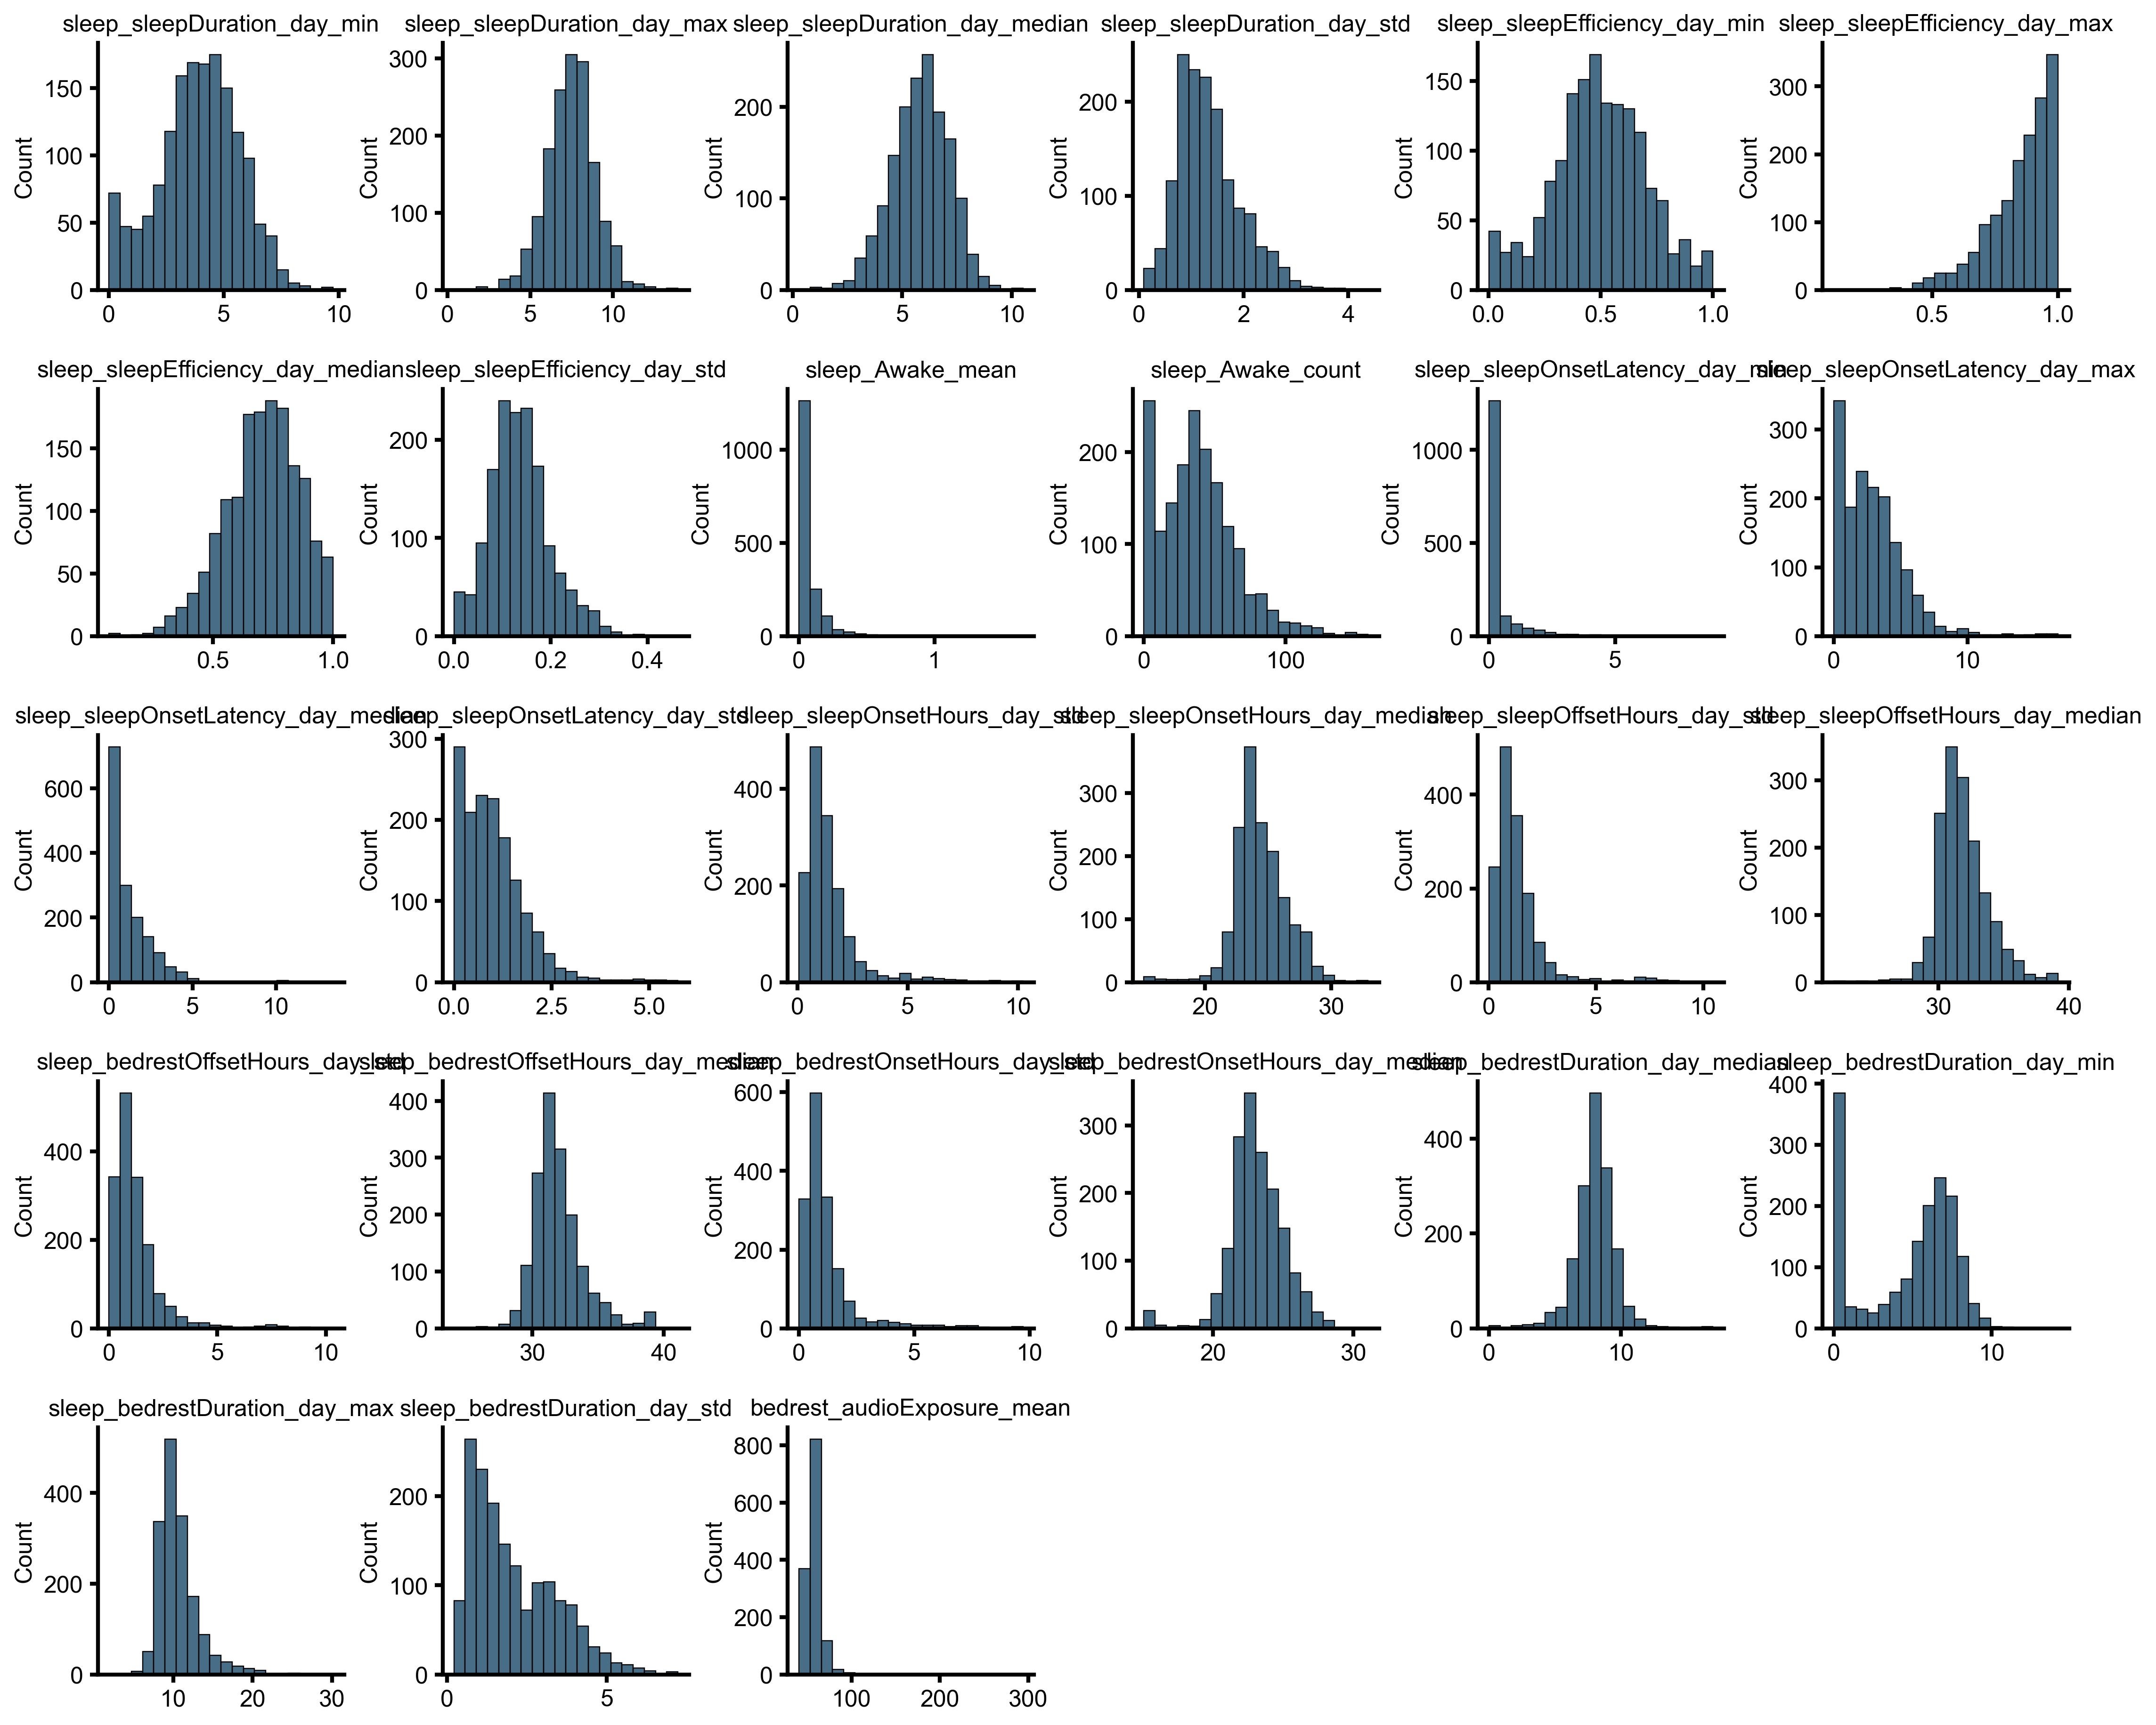

In [62]:
nrows = 5
ncols = 6
fig, axes = plt.subplots(figsize=(3 * ncols, 3 * nrows), nrows=nrows, ncols=ncols)

plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, feature in enumerate(main_features):
    ax = axes.flatten()[i]
    sns.histplot(
        hk_agg_phq_qc[feature].dropna(),
        ax=ax,
        color=ucla_darkest_blue,
        bins=20,
    )
    # ax.set_title(main_features_map[feature])
    ax.set_title(feature)
    ax.set_xlabel("")
    fa.despine_thicken_axes(ax, fontsize=12)
for ax in axes.flatten()[i + 1 :]:
    ax.remove()

## Machine learning to detect PHQ items


In [63]:
importlib.reload(ps)
rerun_cached = False
all_preds = []
out_folder = Path(cache_path, "passive")
for duration, sensor_df in hk_agg_phq_qc.groupby("QC_expected_duration_days"):
    print(f"Running for {duration} days")
    sensor_df = sensor_df.copy().dropna(subset=["sleep_sleepDuration_day_median"])
    surveys_copy = surveys.copy()
    surveys_copy["duration"] = f"{int(duration)}D"
    inputs = [
        {
            "item_df": item_df,
            "sensor_features": sensor_df,
            "output_folder": out_folder,
            "feature_cols": main_features,
            "model_paramgrid": model_paramgrid,
            "nona_cols": ["response_binary"],
            "rerun_cached": rerun_cached,
            "n_folds": 10,
        }
        for _, item_df in surveys_copy[surveys_copy.survey == "phq14"].groupby(
            ["question", "survey"]
        )
    ]
    preds = Parallel(n_jobs=8, verbose=10)(
        delayed(ps.train_test_item_wrapper)(**i) for i in inputs
    )
    all_preds.append(pd.concat(preds))

phq_predictions = pd.concat(all_preds)
phq_predictions

Running for 8.0 days


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Batch computation too fast (0.13714385032653809s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 out of  15 | elapsed:    0.4s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.4s remaining:    1.1s


Skipping phq14 - phq14_total_score - rf due to existing output
Skipping phq14 - phq_10 - rf due to existing output
Skipping phq14 - phq_1 - rf due to existing output
Skipping phq14 - phq14_total_score - gb due to existing output
Skipping phq14 - phq_10 - gb due to existing output
Skipping phq14 - phq_1 - gb due to existing output
Skipping phq14 - phq14_total_score - lr due to existing output
Skipping phq14 - phq_12 - rf due to existing output
Skipping phq14 - phq_1 - lr due to existing output
Skipping phq14 - phq_10 - lr due to existing output
Skipping phq14 - phq14_total_score - dummy due to existing output
Skipping phq14 - phq_1 - dummy due to existing output
Skipping phq14 - phq_10 - dummy due to existing output
Skipping phq14 - phq_12 - gb due to existing output
Skipping phq14 - phq_12 - lr due to existing output
Skipping phq14 - phq_13 - rf due to existing output
Skipping phq14 - phq_12 - dummy due to existing output
Skipping phq14 - phq_13 - gb due to existing output
Skipping phq

[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  10 out of  15 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.5s remaining:    0.1s


Skipping phq14 - phq_11 - rf due to existing output
Skipping phq14 - phq_11 - gb due to existing output
Skipping phq14 - phq_11 - lr due to existing output
Skipping phq14 - phq_11 - dummy due to existing output


[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    2.3s finished


y_true  y_pred  y_pred_proba  \
0          1       1      0.718096   
1          1       1      0.550362   
2          1       1      0.579352   
3          1       1      0.610215   
4          1       1      0.549153   
...      ...     ...           ...   
1560       1       1      0.821479   
1561       1       1      0.821479   
1562       1       1      0.821479   
1563       1       1      0.821479   
1564       1       1      0.821479   

                                            SHAP_values redcap_event_name  \
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      week_1_arm_1   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      week_2_arm_1   
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      week_4_arm_1   
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      week_6_arm_1   
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      week_7_arm_1   
...                                                 ...               ...   
1560  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      week_4_arm_1   
1561  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      week_6_arm_1   
1562  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      week_7_arm_1   
1563  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      week_8_arm_1   
1564  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     week_10_arm_1   

            survey_start  user_id  fold  sleep_sleepDuration_day_min  \
0    2022-10-19 18:03:00     39.0     0                     0.807461   
1    2022-10-26 11:54:00     39.0     0                     6.833333   
2    2022-11-09 13:01:00     39.0     0                     0.297179   
3    2022-11-23 15:36:00     39.0     0                     6.508333   
4    2022-11-30 19:58:00     39.0     0                     0.108951   
...                  ...      ...   ...                          ...   
1560 2023-12-26 11:14:00    381.0     9                     3.516667   
1561 2024-01-09 13:00:00    381.0     9                     5.683333   
1562 2024-01-16 11:53:00    381.0     9                     4.275000   
1563 2024-01-24 12:23:00    381.0     9                     5.058333   
1564 2024-02-06 11:10:00    381.0     9                     3.416667   

      sleep_sleepDuration_day_max  ...  sleep_bedrestOnsetHours_day_median  \
0                        8.691667  ...                           21.531389   
1                        8.691667  ...                           25.780344   
2                        8.079315  ...                           23.512484   
3                        8.158333  ...                           22.929616   
4                        7.175000  ...                           24.091454   
...                           ...  ...                                 ...   
1560                     6.766667  ...                           24.300957   
1561                     5.950000  ...                           26.060278   
1562                     4.858333  ...                           24.283333   
1563                     5.558333  ...                           23.893614   
1564                     7.991667  ...                           25.280948   

      sleep_bedrestDuration_day_median  sleep_bedrestDuration_day_min  \
0                             6.841667                       6.220774   
1                             7.833343                       6.931438   
2                             7.934916                       6.633333   
3                             7.762991                       6.599062   
4                             6.420784                       5.277636   
...                                ...                            ...   
1560                          6.669947                       3.550000   
1561                          5.479961                       0.001734   
1562                          6.027942                       0.001734   
1563                          6.519580                       3.747997   
1564               

In [64]:
phq = surveys[
    (surveys.survey == "phq14") & (surveys.redcap_event_name != "baseline_arm_1")
]
print(
    "n users",
    phq.user_id.nunique(),
    "n_phq",
    phq.groupby("user_id").survey_start.nunique().sum(),
)
print(
    "n users",
    phq_predictions.user_id.nunique(),
    "n_phq",
    phq_predictions.groupby("user_id").survey_start.nunique().sum(),
)

n users 249 n_phq 2067
n users 247 n_phq 1565


In [65]:
phq_subset = phq_predictions.user_id.unique()
psqi_users = psqi_predictions.user_id.unique()


user_subset = list(phq_subset)

for user_id in psqi_users:
    if user_id not in phq_subset:
        user_subset.append(user_id)
        print(user_id)

In [66]:
importlib.reload(emp)
binary_performance_phq_df = emp.get_bootstrapped_performance(
    phq_predictions,
    groupby=["duration", "model", "survey", "outcome", "fold"],
    unit="user_id",
    n_boot=100,
)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.8s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   16.3s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:   19.1s remaining:    1.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   20.6s finished


In [67]:
(
    best_model_phq_performance,
    best_model_phq_predictions,
    best_phq_models,
) = emp.get_best_model_performance_and_predictions(
    binary_performance_phq_df,
    phq_predictions,
    metric="test_roc_auc",
)
binary_performance_test = testBinaryPerformance(
    best_model_phq_performance, ["survey", "outcome", "model", "duration"]
)

binary_performance_test = binary_performance_test.groupby("duration").apply(adjust_pval)
binary_performance_test = binary_performance_test.sort_values("p_adj", ascending=True)
binary_phq_performance_test = binary_performance_test.copy()
binary_performance_test[binary_performance_test["p_adj"] < 0.05]

Testing performance:   0%|          | 0/15 [00:00<?, ?it/s]/Users/sakre/Library/Caches/pypoetry/virtualenvs/optima-sleep-quality-iuf0c8lK-py3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/sakre/Library/Caches/pypoetry/virtualenvs/optima-sleep-quality-iuf0c8lK-py3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/sakre/Library/Caches/pypoetry/virtualenvs/optima-sleep-quality-iuf0c8lK-py3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/sakre/Library/Caches/pypoetry/virtualenvs/optima-sleep-quality-iuf0

   p-val
0      1
          W-val alternative    p-val       RBC  CLES
Wilcoxon   34.0     greater  0.27832  0.236364   0.6
          W-val alternative     p-val       RBC  CLES
Wilcoxon   25.0     greater  0.615234 -0.090909   0.4
          W-val alternative     p-val       RBC  CLES
Wilcoxon   42.0     greater  0.080078  0.527273   0.8
          W-val alternative    p-val       RBC  CLES
Wilcoxon   41.0     greater  0.09668  0.490909   0.6
   p-val
0      1
          W-val alternative    p-val       RBC  CLES
Wilcoxon   53.0     greater  0.00293  0.927273   0.9
          W-val alternative     p-val       RBC  CLES
Wilcoxon   39.0     greater  0.137695  0.418182   0.7
          W-val alternative    p-val       RBC  CLES
Wilcoxon   36.0     greater  0.21582  0.309091   0.5
          W-val alternative     p-val  RBC  CLES
Wilcoxon   44.0     greater  0.052734  0.6   0.7
          W-val alternative     p-val       RBC  CLES
Wilcoxon   54.0     greater  0.001953  0.963636   0.9
          


/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/1864259716.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  binary_performance_test = binary_performance_test.groupby("duration").apply(adjust_pval)


p-val survey outcome model duration  mean_auroc  \
duration                                                                
8D       Wilcoxon  0.001953  phq14   phq_5    rf       8D    0.606280   
         Wilcoxon  0.002930  phq14  phq_14    lr       8D    0.583942   

                   median_auroc  max_auroc  min_auroc  mean_average_precision  \
duration                                                                        
8D       Wilcoxon      0.568370   0.745046   0.490346                0.647284   
         Wilcoxon      0.567587   0.704193   0.484696                0.823017   

                   median_average_precision  max_average_precision  \
duration                                                             
8D       Wilcoxon                  0.616957                0.78410   
         Wilcoxon                  0.823567                0.89437   

                   min_average_precision  normality  W-val alternative  \
duration                                                                 
8D       Wilcoxon               0.516618       True   54.0     greater   
         Wilcoxon               0.717309       True   53.0     greater   

                        RBC  CLES     p_adj  
duration                                     
8D       Wilcoxon  0.963636   0.9  0.029297  
         Wilcoxon  0.927273   0.9  0.041016

In [68]:
binary_phq_performance_test["label"] = binary_phq_performance_test["outcome"].map(
    item_map
)
binary_phq_performance_test[binary_phq_performance_test["p_adj"] < 0.05][
    ["outcome", "label", "model", "median_auroc", "p_adj"]
].sort_values(by=["p_adj"])

outcome                   label model  median_auroc  \
duration                                                                
8D       Wilcoxon   phq_5       Sleeping too much    rf      0.568370   
         Wilcoxon  phq_14  Little interest in sex    lr      0.567587   

                      p_adj  
duration                     
8D       Wilcoxon  0.029297  
         Wilcoxon  0.041016

In [69]:
both_perf = pd.concat(
    [
        binary_phq_performance_test.reset_index(drop=True),
        binary_psqi_perfomance_test[
            binary_psqi_perfomance_test.feature_set == "passive"
        ].reset_index(drop=True),
    ]
)
both_perf["question"] = (
    both_perf["outcome"].map({**item_map, **psqi_relabel}).str.replace("\n", " ")
)
summary_table = pd.concat(
    [
        both_perf[
            [
                "question",
                "model",
                "p_adj",
                "mean_auroc",
                # "CI95%",
                "mean_average_precision",
            ]
        ].set_index("question"),
        both_responses,
    ],
    axis=1,
).rename(
    columns={
        "question": "Question",
        "p_adj": "Adjusted P-value",
        "mean_auroc": "Mean AUROC",
        # "CI95%": "95% CI",
        "mean_average_precision": "Mean AUPRC",
        "percent_true": "% True Class",
        "coef": "ElasticNet Coefficient for PSQI",
        "model": "Model",
        "mean": "Mean Response",
        "std": "Std Response",
        "threshold": "Threshold",
    }
)
summary_table["Model"] = summary_table["Model"].map(
    {
        "rf": "Random Forest",
        "lr": "Logistic Regression",
        "gb": "Gradient Boosting",
    }
)
summary_table.to_clipboard()
summary_table

Model  \
question                                                           
Sleeping too much                                  Random Forest   
Little interest in sex                       Logistic Regression   
Trouble falling asleep or staying asleep       Gradient Boosting   
Moving or speaking slowly                      Gradient Boosting   
PHQ-8 Total Score                                            NaN   
Little interest or pleasure in doing things        Random Forest   
Trouble concentrating on things              Logistic Regression   
Being fidgety or restless                      Gradient Boosting   
Feeling irritable                                            NaN   
Feeling down, depressed                            Random Forest   
Feeling hopeless                               Gradient Boosting   
Feeling tired or having little energy        Logistic Regression   
Poor appetite                                Logistic Regression   
Overeating                                                   NaN   
Feeling bad about yourself                                   NaN   
Daytime Dysfunction                                Random Forest   
Duration                                           Random Forest   
Disturbance                                        Random Forest   
Latency                                        Gradient Boosting   
Total Score                                        Random Forest   
Sleep Medication                                   Random Forest   
Efficiency                                   Logistic Regression   
Sleep Quality                                                NaN   

                                             Adjusted P-value  Mean AUROC  \
question                                                                    
Sleeping too much                                    0.029297    0.606280   
Little interest in sex                               0.041016    0.583942   
Trouble falling asleep or staying asleep             0.685547    0.528709   
Moving or speaking slowly                            0.960938    0.550508   
PHQ-8 Total Score                                    1.000000    0.500000   
Little interest or pleasure in doing things          1.000000    0.519872   
Trouble concentrating on things                      1.000000    0.500202   
Being fidgety or restless                            1.000000    0.533807   
Feeling irritable                                    1.000000    0.500000   
Feeling down, depressed                              1.000000    0.535706   
Feeling hopeless                                     1.000000    0.518968   
Feeling tired or having little energy                1.000000    0.541374   
Poor appetite                                        1.000000    0.519591   
Overeating                                           1.000000    0.500000   
Feeling bad about yourself                           1.000000    0.500000   
Daytime Dysfunction                                  0.007812    0.615896   
Duration                                             0.020508    0.664171   
Disturbance                                          0.111328    0.577943   
Latency                                              0.161133    0.578405   
Total Score                                          0.984375    0.525157   
Sleep Medication                                     0.984375    0.524417   
Efficiency                                           0.984375    0.529819   
Sleep Quality                                        1.000000    0.500000   

                                             Mean AUPRC  Mean Response  \
question                                                                 
Sleeping too much                              0.647284           0.96   
Little interest in sex                         0.823017           1.60   
Trouble falling asleep or staying asleep       0.857442           1.64   
Moving or speaking slowly                      0.306499       

### PHQ Predition with PSQI as input features


In [70]:
psqi_feature_cols = list(surveys[surveys.survey == "psqi"].question.unique())
psqi_domain_answers = surveys[surveys.question.isin(psqi_feature_cols)]
psqi_feats = psqi_domain_answers.pivot_table(
    index=["user_id", "redcap_event_name"],
    columns="question",
    values="response",
)
phq_responses = surveys[surveys.survey == "phq14"]

use_phq_w_psqi = phq_responses.merge(psqi_feats.reset_index())

In [71]:
importlib.reload(ps)
rerun_cached = False
all_preds = []
feature_sets = {
    "psqi_only": list(psqi_feature_cols),
}


for feature_set_type, feature_set in feature_sets.items():
    out_folder = Path(
        "../cache",
        "sleep_quality_detection",
        feature_set_type,
    )
    if not out_folder.exists():
        out_folder.mkdir(parents=True)
    print(f"\tRunning for {feature_set_type} features")
    surveys_copy = use_phq_w_psqi.copy()[
        [
            "user_id",
            "survey_start",
            "survey",
            "question",
            "response",
            "response_binary",
            "redcap_event_name",
        ]
    ]
    surveys_copy["duration"] = f"{duration}D"
    psqi_df = use_phq_w_psqi.copy()[
        ["user_id", "survey_start", *psqi_feature_cols]
    ].drop_duplicates()
    psqi_df["QC_expected_duration"] = 28
    inputs = [
        {
            "item_df": item_df,
            "sensor_features": psqi_df,
            "output_folder": out_folder,
            "feature_cols": feature_set,
            "model_paramgrid": model_paramgrid,
            "nona_cols": ["response_binary"],
            "rerun_cached": rerun_cached,
            "n_folds": 10,
        }
        for _, item_df in surveys_copy.groupby(["question", "survey"])
    ]
    preds = Parallel(n_jobs=8, verbose=10)(
        delayed(ps.train_test_item_wrapper)(**i) for i in inputs
    )
    preds_df = pd.concat(preds)
    preds_df["feature_set"] = feature_set_type
    all_preds.append(preds_df)

phq_from_psqi_predictions = pd.concat(all_preds)

	Running for psqi_only features


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Batch computation too fast (0.18397903442382812s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 out of  15 | elapsed:    0.4s remaining:    2.3s


Skipping phq14 - phq_1 - rf due to existing output
Skipping phq14 - phq_1 - gb due to existing output
Skipping phq14 - phq_10 - rf due to existing output
Skipping phq14 - phq_11 - rf due to existing output
Skipping phq14 - phq_1 - lr due to existing output
Skipping phq14 - phq_1 - dummy due to existing output
Skipping phq14 - phq_11 - gb due to existing output
Skipping phq14 - phq_10 - gb due to existing output
Skipping phq14 - phq_10 - lr due to existing output
Skipping phq14 - phq_11 - lr due to existing output
Skipping phq14 - phq_10 - dummy due to existing output
Skipping phq14 - phq_11 - dummy due to existing output
Skipping phq14 - phq_12 - rf due to existing output
Skipping phq14 - phq_14 - rf due to existing output
Skipping phq14 - phq_12 - gb due to existing output
Skipping phq14 - phq_13 - rf due to existing output
Skipping phq14 - phq_14 - gb due to existing output
Skipping phq14 - phq_12 - lr due to existing output
Skipping phq14 - phq_2 - rf due to existing output
Skipping

[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  10 out of  15 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.4s remaining:    0.1s


Skipping phq14 - phq14_total_score - rf due to existing output
Skipping phq14 - phq_5 - rf due to existing output
Skipping phq14 - phq_5 - gb due to existing output
Skipping phq14 - phq14_total_score - gb due to existing output
Skipping phq14 - phq_5 - lr due to existing output
Skipping phq14 - phq14_total_score - lr due to existing output
Skipping phq14 - phq_5 - dummy due to existing output
Skipping phq14 - phq14_total_score - dummy due to existing output


[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    2.1s finished


In [72]:
print(
    "n users",
    phq_from_psqi_predictions.user_id.nunique(),
    "n_psqi",
    phq_from_psqi_predictions.groupby("user_id").survey_start.nunique().sum(),
)

n users 249 n_psqi 705


In [73]:
binary_performance_phq_psqi = emp.get_bootstrapped_performance(
    phq_from_psqi_predictions,
    groupby=["feature_set", "model", "survey", "outcome", "fold"],
    unit="user_id",
    n_boot=100,
)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:   11.1s remaining:    1.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   11.6s finished


In [74]:
(
    best_model_feature_performance,
    best_model_feature_predictions,
    best_models_feature,
) = emp.get_best_model_performance_and_predictions(
    binary_performance_phq_psqi,
    phq_from_psqi_predictions,
    metric="test_roc_auc",
    groupby=["feature_set", "outcome"],
)

binary_performance_test = testBinaryPerformance(
    best_model_feature_performance,
    groupby=["feature_set", "outcome", "model"],
)

binary_performance_test_phq_psqi = (
    binary_performance_test.groupby("feature_set")
    .apply(adjust_pval)
    .sort_values("p_adj", ascending=True)
)
binary_performance_test_phq_psqi

Testing performance: 100%|██████████| 15/15 [00:00<00:00, 420.34it/s]

          W-val alternative     p-val  RBC  CLES
Wilcoxon   55.0     greater  0.000977  1.0   1.0
          W-val alternative     p-val  RBC  CLES
Wilcoxon   55.0     greater  0.000977  1.0   1.0
          W-val alternative     p-val  RBC  CLES
Wilcoxon   55.0     greater  0.000977  1.0   1.0
          W-val alternative     p-val  RBC  CLES
Wilcoxon   55.0     greater  0.000977  1.0   1.0
          W-val alternative     p-val       RBC  CLES
Wilcoxon   52.0     greater  0.004883  0.890909   0.8
          W-val alternative     p-val  RBC  CLES
Wilcoxon   55.0     greater  0.000977  1.0   1.0
          W-val alternative     p-val  RBC  CLES
Wilcoxon   55.0     greater  0.000977  1.0   1.0
          W-val alternative     p-val  RBC  CLES
Wilcoxon   55.0     greater  0.000977  1.0   1.0
          W-val alternative     p-val  RBC  CLES
Wilcoxon   55.0     greater  0.000977  1.0   1.0
          W-val alternative     p-val  RBC  CLES
Wilcoxon   55.0     greater  0.000977  1.0   1.0
          


/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/3151536081.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(adjust_pval)


W-val alternative     p-val       RBC  CLES feature_set  \
feature_set                                                                     
psqi_only   Wilcoxon   55.0     greater  0.000977  1.000000   1.0   psqi_only   
            Wilcoxon   55.0     greater  0.000977  1.000000   1.0   psqi_only   
            Wilcoxon   55.0     greater  0.000977  1.000000   1.0   psqi_only   
            Wilcoxon   55.0     greater  0.000977  1.000000   1.0   psqi_only   
            Wilcoxon   52.0     greater  0.004883  0.890909   0.8   psqi_only   
            Wilcoxon   55.0     greater  0.000977  1.000000   1.0   psqi_only   
            Wilcoxon   55.0     greater  0.000977  1.000000   1.0   psqi_only   
            Wilcoxon   55.0     greater  0.000977  1.000000   1.0   psqi_only   
            Wilcoxon   55.0     greater  0.000977  1.000000   1.0   psqi_only   
            Wilcoxon   55.0     greater  0.000977  1.000000   1.0   psqi_only   
            Wilcoxon   55.0     greater  0.000977  1.000000   1.0   psqi_only   
            Wilcoxon   50.0     greater  0.009766  0.818182   0.8   psqi_only   
            Wilcoxon   54.0     greater  0.001953  0.963636   0.9   psqi_only   
            Wilcoxon   54.0     greater  0.001953  0.963636   0.9   psqi_only   
            Wilcoxon   55.0     greater  0.000977  1.000000   1.0   psqi_only   

                                outcome model  mean_auroc  median_auroc  \
feature_set                                                               
psqi_only   Wilcoxon  phq14_total_score    lr    0.804175      0.804472   
            Wilcoxon              phq_1    rf    0.752218      0.758123   
            Wilcoxon             phq_10    rf    0.643713      0.651067   
            Wilcoxon             phq_11    lr    0.659497      0.631205   
            Wilcoxon             phq_12    lr    0.591672      0.588144   
            Wilcoxon             phq_13    lr    0.696771      0.684897   
            Wilcoxon             phq_14    lr    0.660323      0.664676   
            Wilcoxon              phq_2    lr    0.750603      0.742746   
            Wilcoxon              phq_3    lr    0.667567      0.652150   
            Wilcoxon              phq_4    rf    0.858650      0.866992   
            Wilcoxon              phq_5    lr    0.731420      0.750885   
            Wilcoxon              phq_6    gb    0.720879      0.798060   
            Wilcoxon              phq_7    lr    0.610066      0.615964   
            Wilcoxon              phq_8    lr    0.581092      0.555815   
            Wilcoxon              phq_9    lr    0.640892      0.629352   

                      max_auroc  min_auroc  mean_average_precision  \
feature_set                                                          
psqi_only   Wilcoxon   0.881934   0.684468                0.917237   
            Wilcoxon   0.918372   0.552885                0.970751   
            Wilcoxon   0.760570   0.515884                0.926924   
            Wilcoxon   0.809732   0.557097                0.433084   
            Wilcoxon   0.701027   0.486630                0.638044   
            Wilcoxon   0.875270   0.582166                0.954729   
            Wilcoxon   0.836235   0.510699                0.876365   
            Wilcoxon   0.916703   0.657557                0.975358   
            Wilcoxon   0.798639   0.540690                0.846649   
            Wilcoxon   0.950899   0.749908                0.961005   
            Wilcoxon   0.834918   0.539435                0.790689   
            Wilcoxon   0.951813   0.289708                0.993301   
            Wilcoxon   0.793300   0.460225                0.674480   
            Wilcoxon   0.682050   0.496219                0.718752   
            Wilcoxon   0.763880   0.531053                0.886367   

                      median_average_precision  max_average_precision  \
feature_set                                                             
psqi_only   Wilcoxon           

In [75]:
sig_tests_phq_psqi = binary_performance_test_phq_psqi[
    (binary_performance_test_phq_psqi["p_adj"] < 0.05)
]
sig_tests_phq_psqi[["outcome", "median_auroc", "p-val", "p_adj"]].sort_values(
    by="p_adj"
)

outcome  median_auroc     p-val     p_adj
feature_set                                                              
psqi_only   Wilcoxon  phq14_total_score      0.804472  0.000977  0.014648
            Wilcoxon              phq_1      0.758123  0.000977  0.014648
            Wilcoxon             phq_10      0.651067  0.000977  0.014648
            Wilcoxon             phq_11      0.631205  0.000977  0.014648
            Wilcoxon             phq_12      0.588144  0.004883  0.014648
            Wilcoxon             phq_13      0.684897  0.000977  0.014648
            Wilcoxon             phq_14      0.664676  0.000977  0.014648
            Wilcoxon              phq_2      0.742746  0.000977  0.014648
            Wilcoxon              phq_3      0.652150  0.000977  0.014648
            Wilcoxon              phq_4      0.866992  0.000977  0.014648
            Wilcoxon              phq_5      0.750885  0.000977  0.014648
            Wilcoxon              phq_6      0.798060  0.009766  0.014648
            Wilcoxon              phq_7      0.615964  0.001953  0.014648
            Wilcoxon              phq_8      0.555815  0.001953  0.014648
            Wilcoxon              phq_9      0.629352  0.000977  0.014648

In [76]:
perf_df = (
    best_model_feature_performance.copy()
)  # binary_performance_feature_set_type_df

feature_set_map_2 = {
    "psqi_only": "PSQI Only",
    "passive_wo_psqi": "Passive Only",
    "passive_and_psqi": "Passive and PSQI",
}

perf_df["outcome"] = perf_df.outcome.map(item_map)
perf_df["Features"] = perf_df["feature_set"].map(feature_set_map_2)
hue_order = [
    "PSQI Only",
]

perf_df["is_sig"] = False
perf_df["is_sig"] = perf_df.outcome.isin(
    sig_tests_phq_psqi[sig_tests_phq_psqi.feature_set == "psqi_only"].outcome.map(
        item_map
    )
)

label_order = list(
    perf_df[
        (perf_df.feature_set == "psqi_only") & (perf_df.outcome != "PHQ-8 Total Score")
    ]
    .groupby("outcome")
    .test_roc_auc.median()
    .sort_values(ascending=False)
    .index
)
# label_order = [x for x in label_order if x != item_map['phq14_total_score']]


perf_df

feature_set                     outcome model  index survey  fold  \
0     psqi_only           PHQ-8 Total Score    lr    300  phq14     0   
1     psqi_only           PHQ-8 Total Score    lr    301  phq14     1   
2     psqi_only           PHQ-8 Total Score    lr    302  phq14     2   
3     psqi_only           PHQ-8 Total Score    lr    303  phq14     3   
4     psqi_only           PHQ-8 Total Score    lr    304  phq14     4   
..          ...                         ...   ...    ...    ...   ...   
145   psqi_only  Feeling bad about yourself    lr    445  phq14     5   
146   psqi_only  Feeling bad about yourself    lr    446  phq14     6   
147   psqi_only  Feeling bad about yourself    lr    447  phq14     7   
148   psqi_only  Feeling bad about yourself    lr    448  phq14     8   
149   psqi_only  Feeling bad about yourself    lr    449  phq14     9   

     test_roc_auc  test_average_precision  test_balanced_accuracy     n  \
0        0.797922                0.893668                0.679688  2500   
1        0.859295                0.935433                0.768825  2700   
2        0.841625                0.942251                0.678804  2400   
3        0.870137                0.945838                0.551834  2300   
4        0.684468                0.851976                0.704942  2600   
..            ...                     ...                     ...   ...   
145      0.674871                0.920223                0.500000  2400   
146      0.623544                0.878612                0.500000  2600   
147      0.583997                0.855939                0.500000  2500   
148      0.763880                0.908753                0.500000  2400   
149      0.531053                0.829477                0.543417  2500   

     n_bootstraps   Features  is_sig  
0             100  PSQI Only    True  
1             100  PSQI Only    True  
2             100  PSQI Only    True  
3             100  PSQI Only    True  
4             100  PSQI Only    True  
..            ...        ...     ...  
145           100  PSQI Only    True  
146           100  PSQI Only    True  
147           100  PSQI Only    True  
148           100  PSQI Only    True  
149           100  PSQI Only    True  

[150 rows x 13 columns]

/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/3395275187.py:191: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/784484494.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "0.5", "1"])
/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/3395275187.py:191: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_79482/784484494.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "0.5",

['Trouble falling asleep or staying asleep', 'Feeling tired or having little energy', 'Little interest or pleasure in doing things', 'Sleeping too much', 'Feeling down, depressed', 'Feeling irritable', 'Little interest in sex', 'Feeling hopeless', 'Trouble concentrating on things', 'Moving or speaking slowly', 'Feeling bad about yourself', 'Poor appetite', 'Being fidgety or restless', 'Overeating']


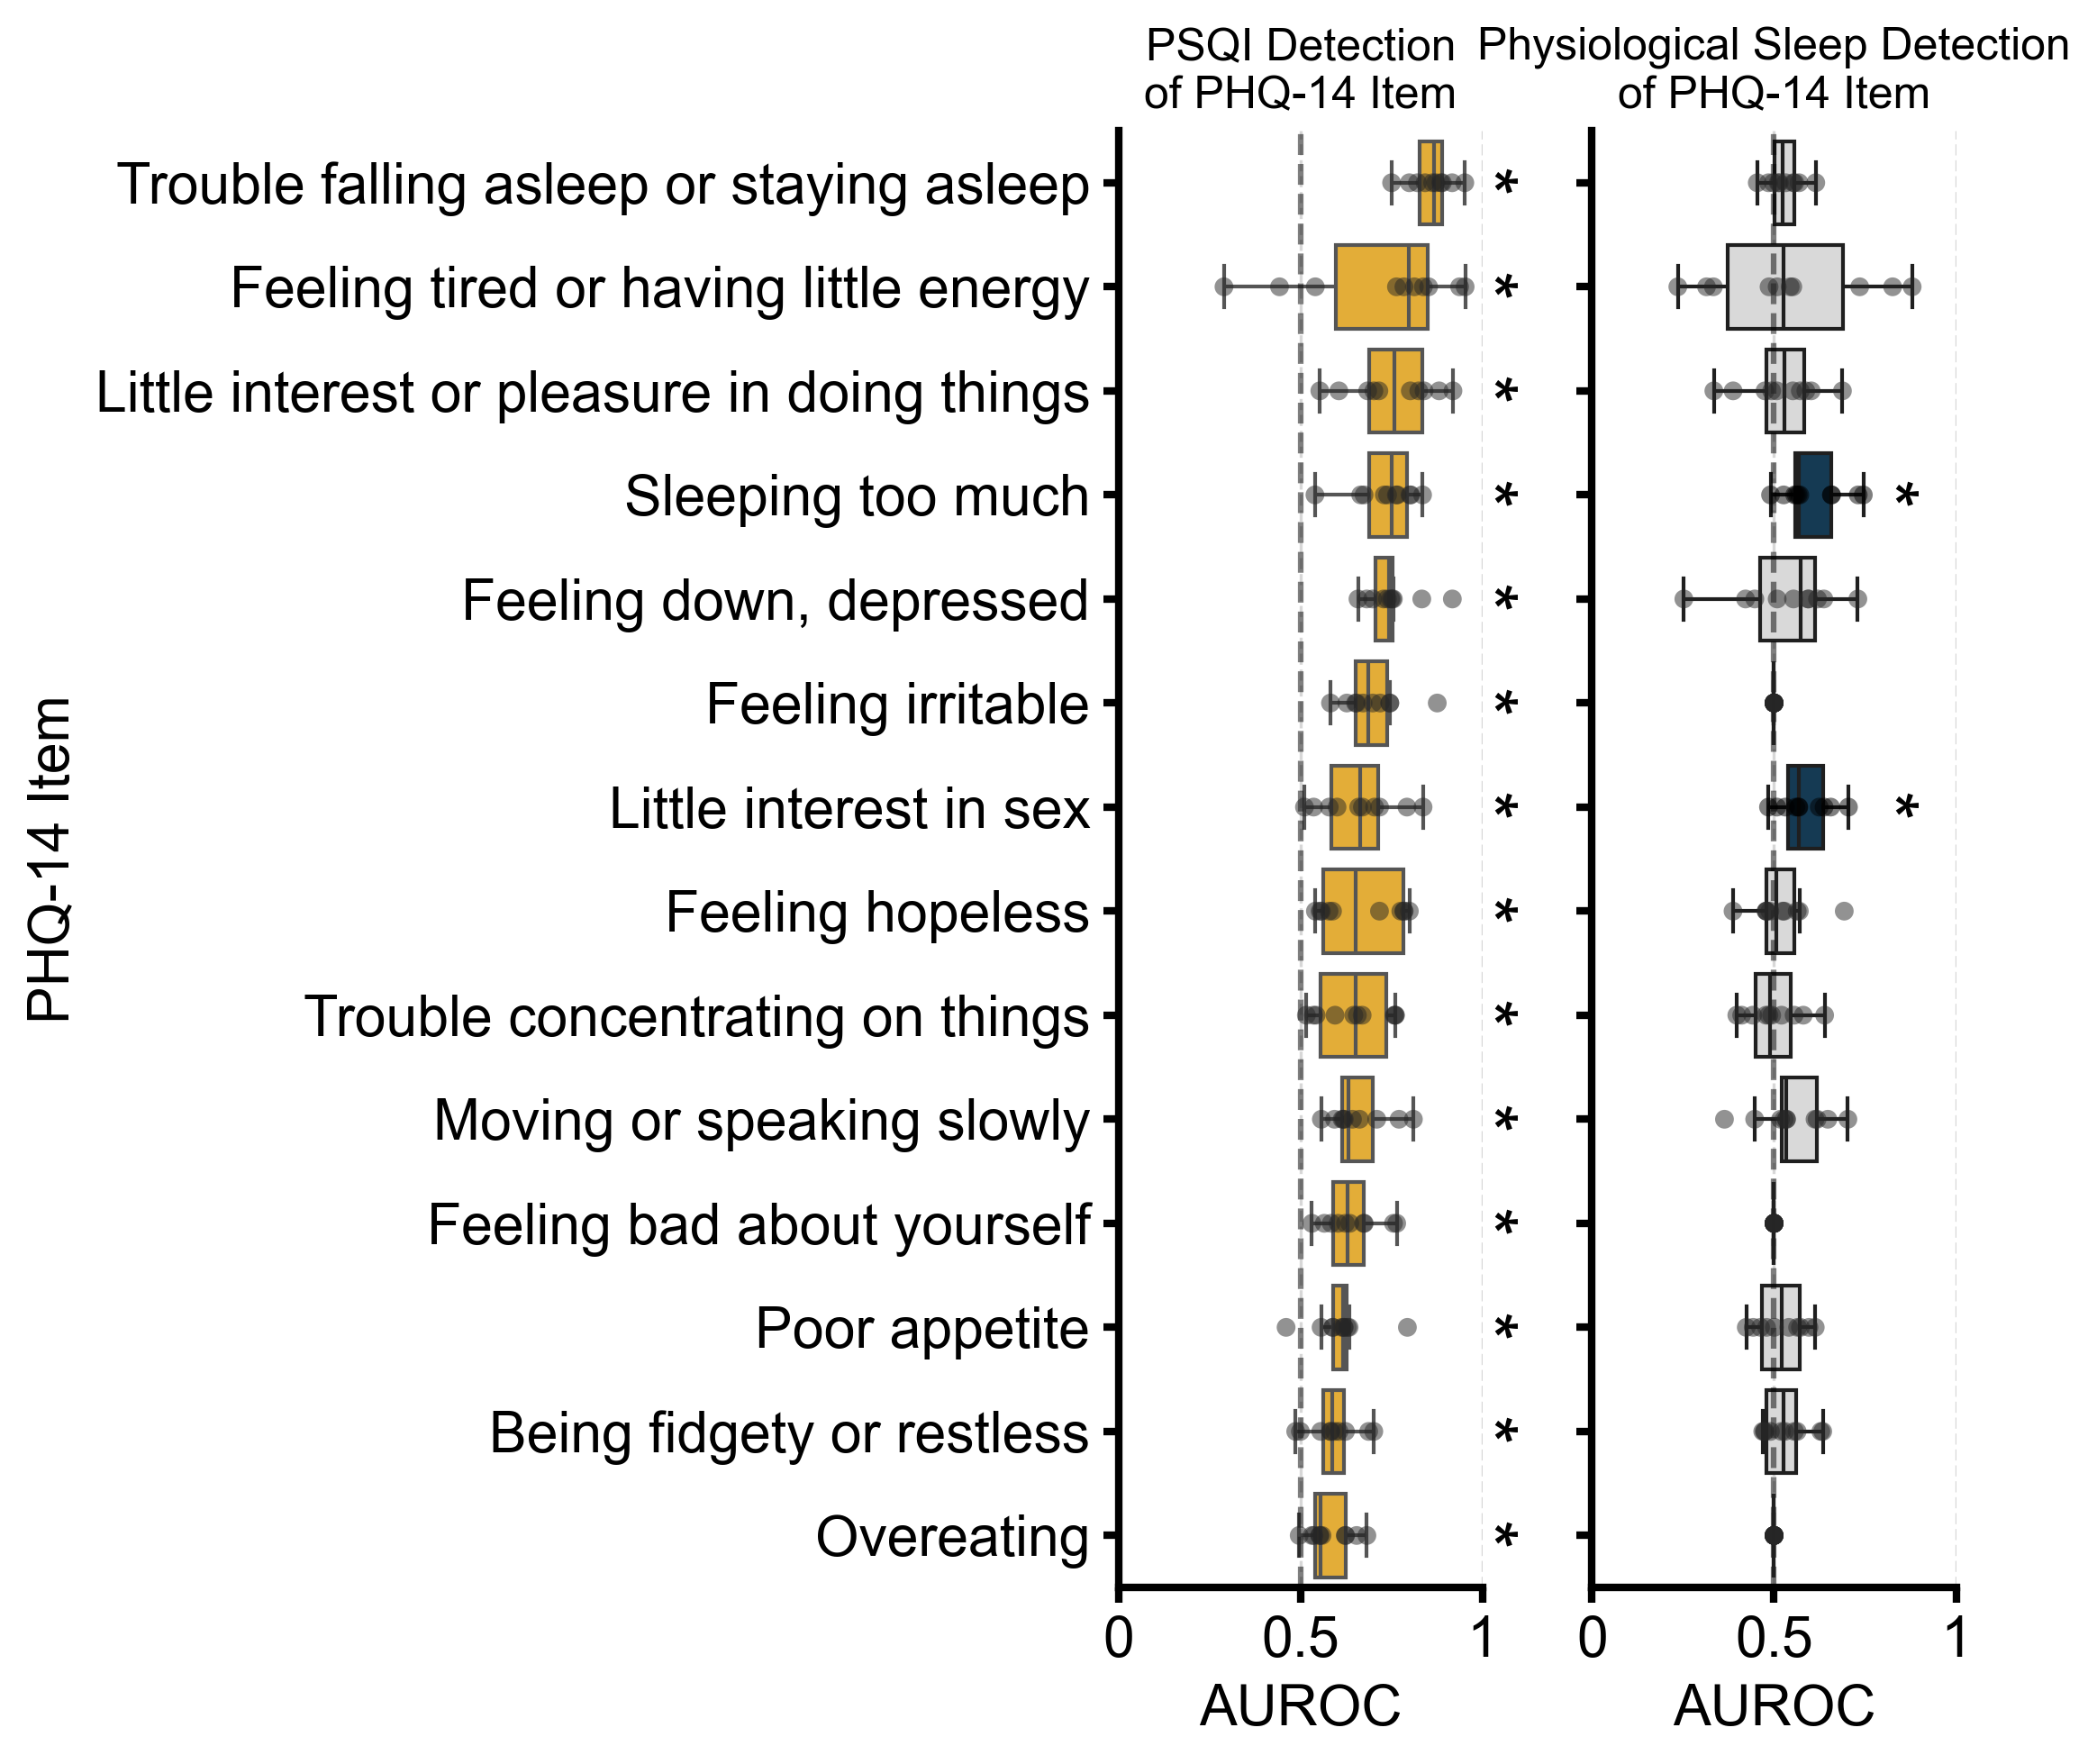

In [77]:
perf_df = (
    best_model_feature_performance.copy()
)  # binary_performance_feature_set_type_df

feature_set_map_2 = {
    "psqi_only": "PSQI Only",
    "passive_wo_psqi": "Passive Only",
    "passive_and_psqi": "Passive and PSQI",
}

perf_df["outcome"] = perf_df.outcome.map(item_map)
perf_df["Features"] = perf_df["feature_set"].map(feature_set_map_2)
hue_order = [
    "PSQI Only",
]

perf_df["is_sig"] = False
perf_df["is_sig"] = perf_df.outcome.isin(
    sig_tests_phq_psqi[sig_tests_phq_psqi.feature_set == "psqi_only"].outcome.map(
        item_map
    )
)

label_order = list(
    perf_df[
        (perf_df.feature_set == "psqi_only") & (perf_df.outcome != "PHQ-8 Total Score")
    ]
    .groupby("outcome")
    .test_roc_auc.median()
    .sort_values(ascending=False)
    .index
)
# label_order = [x for x in label_order if x != item_map['phq14_total_score']]


# Remove passive with demographics
fig, axes = plt.subplots(figsize=(4, 7), ncols=2, sharey=True)
plt.subplots_adjust(wspace=0.3)
ax = axes[0]
ax = plot_performance_T(
    perf_df[perf_df.feature_set == "psqi_only"],
    "roc_auc",
    order=label_order,
    dodge=False,
    ax=ax,
    xlim=(0, 1),
    vline=0.5,
    hue_col="is_sig",
    palette={False: "#D9D9D9", True: ucla_darkest_gold},
)

for i, row in sig_tests_phq_psqi.iterrows():
    if row["outcome"] != "phq14_total_score":
        annot = "*"
        if row["p_adj"] < 0.01:
            annot = "**"
        elif row["p_adj"] < 0.001:
            annot = "***"

        # y = where row["outcome"] == label_order
        ax.annotate(
            annot,
            xy=(0.9, label_order.index(item_map[row["outcome"]])),
            fontsize=20,
            color="black",
            rotation=-90,
        )


ax.set_xticklabels(["0", "0.5", "1"])
ax.set_ylabel("PHQ-14 Item")
ax.set_xlabel("AUROC")
ax.set_title("PSQI Detection\nof PHQ-14 Item")
ax.legend().remove()


perf_df = best_model_phq_performance.copy()  # binary_performance_feature_set_type_df
binary_phq_performance_test["is_sig"] = binary_phq_performance_test["p_adj"] < 0.05
perf_df = perf_df.merge(
    binary_phq_performance_test[["outcome", "is_sig"]],
    how="left",
)
perf_df["is_sig"] = perf_df["is_sig"].fillna(False)
perf_df["outcome"] = perf_df.outcome.map(item_map)

print(label_order)
ax = axes[1]
ax = plot_performance_T(
    perf_df,
    "roc_auc",
    order=label_order,
    dodge=False,
    ax=ax,
    xlim=(0, 1),
    vline=0.5,
    hue_col="is_sig",
    palette=["#D9D9D9", ucla_darkest_blue],
)

sig_tests = binary_phq_performance_test[binary_phq_performance_test["p_adj"] < 0.05]
sig_tests_phq = sig_tests.copy()
for i, row in sig_tests_phq.iterrows():
    if row["outcome"] != "phq14_total_score":
        annot = "*"
        if row["p_adj"] < 0.01:
            annot = "**"
        elif row["p_adj"] < 0.001:
            annot = "***"

        # y = where row["outcome"] == label_order
        ax.annotate(
            annot,
            xy=(0.7, label_order.index(item_map[row["outcome"]])),
            fontsize=20,
            color="black",
            rotation=-90,
        )

# Set xticklabels
ax.set_xticklabels(["0", "0.5", "1"])

ax.set_ylabel("PHQ-14 Item")
ax.set_xlabel("AUROC")
ax.set_title("Physiological Sleep Detection\nof PHQ-14 Item")
ax.legend().remove()

In [80]:
binary_phq_performance_test["label"] = binary_phq_performance_test["outcome"].map(
    item_map
)
binary_phq_performance_test["model"] = binary_phq_performance_test["model"].str.upper()
phq_out_perf = binary_phq_performance_test[
    [
        "label",
        "model",
        "median_auroc",
        "p_adj",
    ]
]

binary_performance_test_phq_psqi["label"] = binary_performance_test_phq_psqi[
    "outcome"
].map(item_map)
binary_performance_test_phq_psqi["model"] = binary_performance_test_phq_psqi[
    "model"
].str.upper()
psqi_out_perf = binary_performance_test_phq_psqi[
    [
        "label",
        "model",
        "median_auroc",
        "p_adj",
    ]
]

table2 = (
    psqi_out_perf.merge(
        phq_out_perf,
        on=["label"],
        how="outer",
        suffixes=("_psqi", "_phq"),
    )
    .set_index("label")
    .reindex(label_order)
)
table2.to_clipboard()
table2

model_psqi  median_auroc_psqi  \
label                                                                       
Trouble falling asleep or staying asleep            RF           0.866992   
Feeling tired or having little energy               GB           0.798060   
Little interest or pleasure in doing things         RF           0.758123   
Sleeping too much                                   LR           0.750885   
Feeling down, depressed                             LR           0.742746   
Feeling irritable                                   LR           0.684897   
Little interest in sex                              LR           0.664676   
Feeling hopeless                                    LR           0.652150   
Trouble concentrating on things                     RF           0.651067   
Moving or speaking slowly                           LR           0.631205   
Feeling bad about yourself                          LR           0.629352   
Poor appetite                                       LR           0.615964   
Being fidgety or restless                           LR           0.588144   
Overeating                                          LR           0.555815   

                                             p_adj_psqi model_phq  \
label                                                               
Trouble falling asleep or staying asleep       0.014648        GB   
Feeling tired or having little energy          0.014648        LR   
Little interest or pleasure in doing things    0.014648        RF   
Sleeping too much                              0.014648        RF   
Feeling down, depressed                        0.014648        RF   
Feeling irritable                              0.014648     DUMMY   
Little interest in sex                         0.014648        LR   
Feeling hopeless                               0.014648        GB   
Trouble concentrating on things                0.014648        LR   
Moving or speaking slowly                      0.014648        GB   
Feeling bad about yourself                     0.014648     DUMMY   
Poor appetite                                  0.014648        LR   
Being fidgety or restless                      0.014648        GB   
Overeating                                     0.014648     DUMMY   

                                             median_auroc_phq  p_adj_phq  
label                                                                     
Trouble falling asleep or staying asleep             0.523217   0.685547  
Feeling tired or having little energy                0.526354   1.000000  
Little interest or pleasure in doing things          0.529513   1.000000  
Sleeping too much                                    0.568370   0.029297  
Feeling down, depressed                              0.573508   1.000000  
Feeling irritable                                    0.500000   1.000000  
Little interest in sex                               0.567587   0.041016  
Feeling hopeless                                     0.506012   1.000000  
Trouble concentrating on things                      0.489533   1.000000  
Moving or speaking slowly                            0.533965   0.960938  
Feeling bad about yourself                           0.500000   1.000000  
Poor appetite                                        0.520655   1.000000  
Being fidgety or restless                            0.524859   1.000000  
Overeating                                           0.500000   1.000000

### Showing PHQ total score and PSQI total score performance


### Performance by subgroup


In [68]:
baseline_phq = surveys[
    (surveys.redcap_event_name == "baseline_arm_1")
    & (surveys.survey == "phq14")
    & (surveys.question == "phq14_total_score")
]
baseline_pvss = surveys[
    (surveys.redcap_event_name == "baseline_arm_1")
    & (surveys.survey == "pvss")
    & (surveys.question == "pvss_total")
]
all_pvss = (
    surveys[(surveys.survey == "pvss") & (surveys.question == "pvss_total")]
    .groupby("user_id")
    .response.mean()
    .reset_index()
)
all_phq = (
    surveys[(surveys.survey == "phq14") & (surveys.question == "phq14_total_score")]
    .groupby("user_id")
    .response.mean()
    .reset_index()
)
all_phq["response_binary"] = all_phq.response >= 10
all_depression = all_phq.rename(columns={"response_binary": "dep"})

all_pvss["response_binary"] = all_pvss.response < 5
all_anhedonia = all_pvss.rename(columns={"response_binary": "anhed"})


baseline_anhedonia = baseline_pvss[["user_id", "response_binary"]].rename(
    columns={"response_binary": "anhed"}
)
baseline_depression = baseline_phq[["user_id", "response_binary"]].rename(
    columns={"response_binary": "dep"}
)
income_status = demographics[["user_id", "Family Income"]].rename(
    columns={"Family Income <100k": "income"}
)
income_status["income>100k"] = income_status["Family Income"] == "$100,000 +"
sex_at_birth = demographics[["user_id", "Sex"]]
sex_at_birth["is_female"] = sex_at_birth.Sex == "Female"
race_ethnicity = demographics[["user_id", "Race", "Hispanic"]]
race_ethnicity["is_white"] = (race_ethnicity["Race"] == "White") & (
    race_ethnicity["Hispanic"] == "No"
)

split_on_descriptors = (
    baseline_anhedonia.merge(baseline_depression, how="left", on="user_id")
    .merge(income_status, how="left")
    .merge(sex_at_birth, how="left")
    .merge(race_ethnicity[["user_id", "is_white"]])
)


labeled_phq_predictions = (
    best_model_phq_predictions.merge(baseline_depression, how="left")
    .merge(baseline_anhedonia, how="left")
    .merge(income_status, how="left")
    .merge(sex_at_birth, how="left")
    .merge(race_ethnicity[["user_id", "is_white"]])
)
labeled_phq_predictions.to_csv(
    "../cache/sleep_quality_detection/labeled_phq_predictions.csv", index=False
)

labeled_phq_predictions
split_on_descriptors.describe(include="all")

/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_59816/1481799662.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sex_at_birth["is_female"] = sex_at_birth.Sex == "Female"
/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_59816/1481799662.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_ethnicity["is_white"] = (race_ethnicity["Race"] == "White") & (


user_id anhed   dep Family Income income>100k     Sex is_female  \
count   248.000000   248   248           248         248     248       248   
unique         NaN     2     2             8           2       2         2   
top            NaN  True  True    $100,000 +       False  Female      True   
freq           NaN   155   207           123         125     160       160   
mean    223.350806   NaN   NaN           NaN         NaN     NaN       NaN   
std     107.843050   NaN   NaN           NaN         NaN     NaN       NaN   
min      38.000000   NaN   NaN           NaN         NaN     NaN       NaN   
25%     126.750000   NaN   NaN           NaN         NaN     NaN       NaN   
50%     220.500000   NaN   NaN           NaN         NaN     NaN       NaN   
75%     318.500000   NaN   NaN           NaN         NaN     NaN       NaN   
max     400.000000   NaN   NaN           NaN         NaN     NaN       NaN   

       is_white  
count       248  
unique        2  
top       False  
freq        143  
mean        NaN  
std         NaN  
min         NaN  
25%         NaN  
50%         NaN  
75%         NaN  
max         NaN

In [69]:
anhed_comp = comparePerformanceByGroup(labeled_phq_predictions, "anhed")
anhed_comp["group"] = "PVSS Total Score < 5"
anhed_comp[anhed_comp["p-val"] < 0.05]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:    7.1s remaining:    0.6s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    8.0s finished


Empty DataFrame
Columns: [U-val, alternative, p-val, RBC, CLES, mean_diff, duration, outcome, g1_mean, g0_mean, label, group]
Index: []

In [70]:
dep_comp = comparePerformanceByGroup(labeled_phq_predictions, "dep")
dep_comp["group"] = "PHQ-14 Score ≥ 10"
dep_comp[dep_comp["p-val"] < 0.05]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:    7.7s remaining:    0.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    8.4s finished


U-val alternative     p-val       RBC      CLES  mean_diff duration  \
MWU   86.0   two-sided  0.000944 -0.911111  0.955556  -0.221635       8D   

    outcome   g1_mean   g0_mean                            label  \
MWU  phq_10  0.441913  0.663549  Trouble concentrating on things   

                 group  
MWU  PHQ-14 Score ≥ 10

In [71]:
income_comp = comparePerformanceByGroup(labeled_phq_predictions, "income>100k")
income_comp["group"] = "Income > 100k"
income_comp[income_comp["p-val"] < 0.05]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:    7.9s remaining:    0.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    8.6s finished


U-val alternative     p-val   RBC  CLES  mean_diff duration outcome  \
MWU   23.0   two-sided  0.045155  0.54  0.23   0.132407       8D   phq_7   

      g1_mean  g0_mean          label          group  
MWU  0.582607   0.4502  Poor appetite  Income > 100k

In [72]:
race_comp = comparePerformanceByGroup(labeled_phq_predictions, "is_white")
race_comp["group"] = "Is non-Hispanic White"
race_comp[race_comp["p-val"] < 0.05]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    6.7s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:    7.9s remaining:    0.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    8.6s finished


U-val alternative     p-val   RBC  CLES  mean_diff duration outcome  \
MWU   79.0   two-sided  0.031209 -0.58  0.79  -0.107936       8D  phq_12   

      g1_mean   g0_mean                      label                  group  
MWU  0.471635  0.579571  Being fidgety or restless  Is non-Hispanic White

In [73]:
labeled_phq_predictions.groupby("is_female").user_id.nunique()

is_female
False     88
True     158
Name: user_id, dtype: int64

In [74]:
sex_comp = comparePerformanceByGroup(labeled_phq_predictions, "is_female")
sex_comp["group"] = "Sex at Birth - Female"
sex_comp[sex_comp["p-val"] < 0.05]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:    7.5s remaining:    0.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    8.1s finished


Empty DataFrame
Columns: [U-val, alternative, p-val, RBC, CLES, mean_diff, duration, outcome, g1_mean, g0_mean, label, group]
Index: []

In [75]:
all_comps = pd.concat(
    [anhed_comp, dep_comp, income_comp, race_comp, sex_comp]
).sort_values(by="p-val")
table_3 = all_comps[all_comps["p-val"] < 0.05].rename(
    columns={
        "g0_mean": "Mean AUROC (Group 0)",
        "g1_mean": "Mean AUROC (Group 1)",
        "mean_diff": "Mean Difference",
        "p-val": "P-value",
    }
)[
    [
        "group",
        "label",
        "Mean AUROC (Group 1)",
        "Mean AUROC (Group 0)",
        "Mean Difference",
        "P-value",
    ]
]
table_3.round(3).to_clipboard()
table_3

group                            label  \
MWU      PHQ-14 Score ≥ 10  Trouble concentrating on things   
MWU  Is non-Hispanic White        Being fidgety or restless   
MWU          Income > 100k                    Poor appetite   

     Mean AUROC (Group 1)  Mean AUROC (Group 0)  Mean Difference   P-value  
MWU              0.441913              0.663549        -0.221635  0.000944  
MWU              0.471635              0.579571        -0.107936  0.031209  
MWU              0.582607              0.450200         0.132407  0.045155

## Feature importance of PHQ items


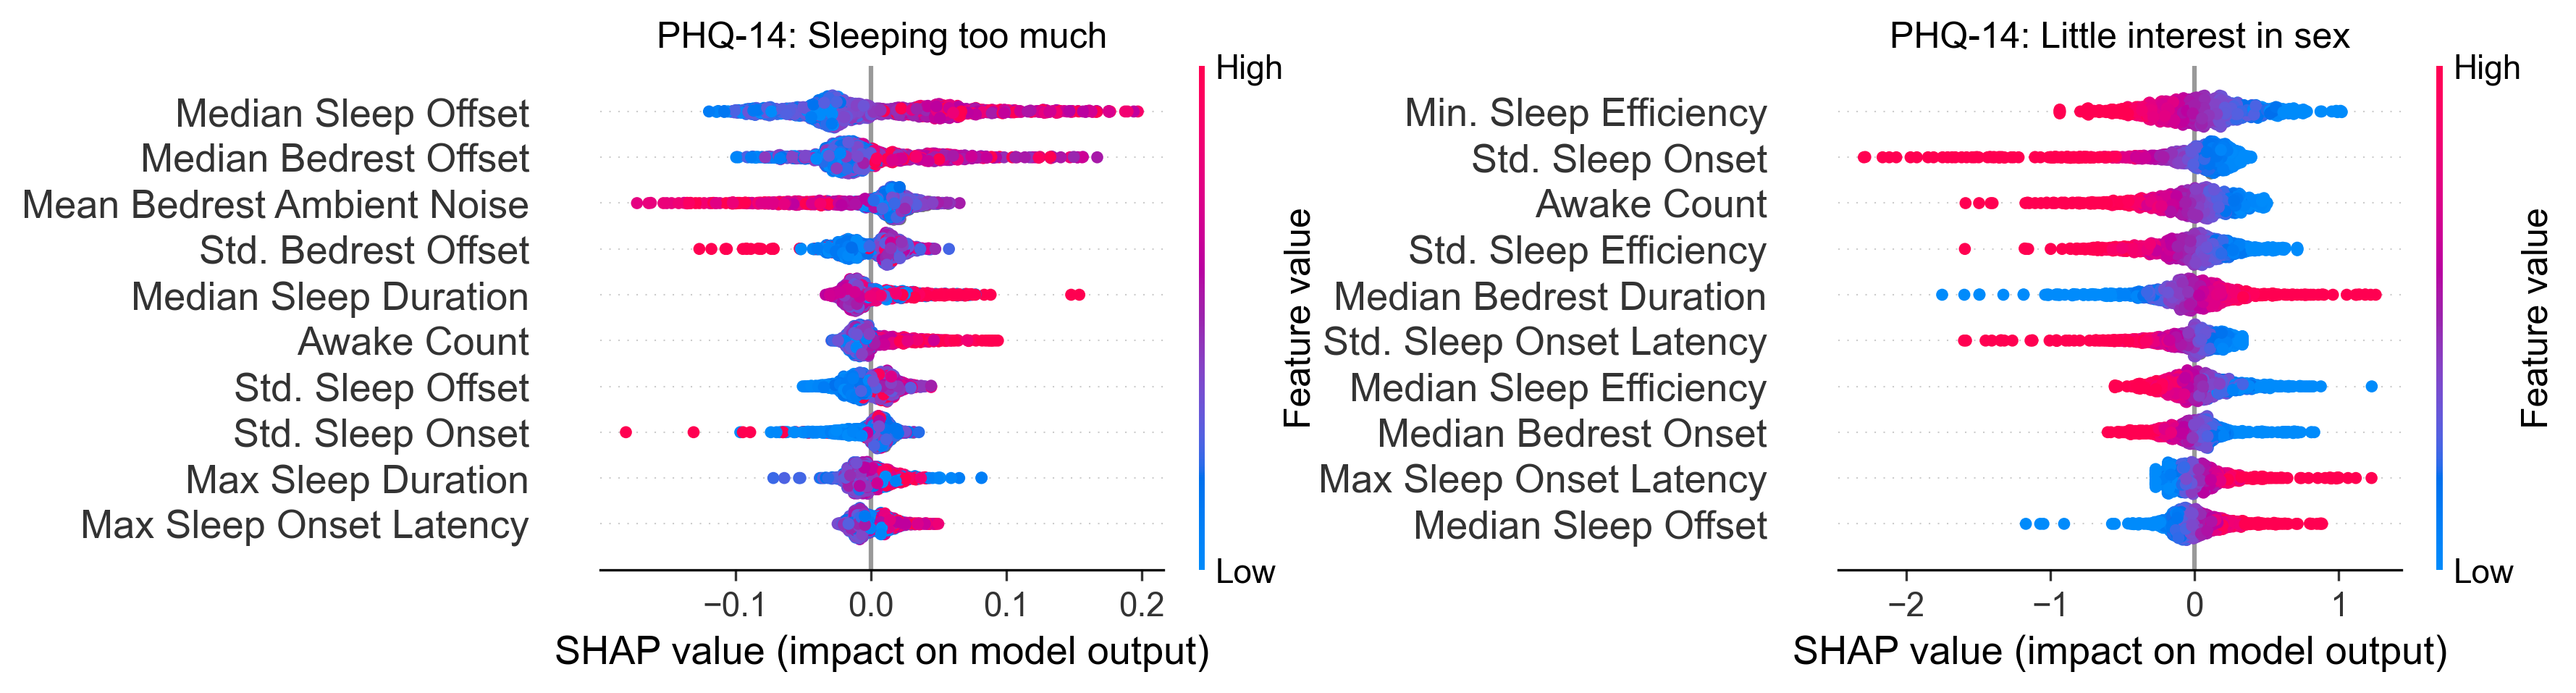

In [79]:
# import robust scaler
fig, axes = plt.subplots(figsize=(25 * 2, 15 * 5), nrows=5, ncols=2)

survey = "phq14"
items = sig_tests_phq.outcome.unique()

for i, item in enumerate(items):
    s_df = best_model_phq_predictions[
        (best_model_phq_predictions.survey == survey)
        & (best_model_phq_predictions.outcome == item)
    ].copy()
    ax = axes.flatten()[i]
    # set active axis to ax
    plt.sca(ax)

    scaler = RobustScaler(quantile_range=(5, 95))
    transf = scaler.fit_transform(s_df[main_features])
    transf_df = pd.DataFrame(
        transf, columns=[main_features_map[c] for c in main_features]
    )
    # Calculate median SHAP values for each feature
    median_shap_values = np.mean(np.abs(np.stack(s_df.SHAP_values.values)), axis=0)

    # Get feature names sorted by median SHAP values
    sort_index = np.argsort(median_shap_values)
    transf_df = transf_df.iloc[:, sort_index]

    # reindex shap values
    s_df.SHAP_values = s_df.SHAP_values.apply(lambda x: x[sort_index])

    shap.summary_plot(
        np.stack(s_df.SHAP_values.values),
        transf_df,
        show=False,
        sort=True,
        max_display=10,
        plot_size=(12, 15),
    )
    # set xlim to -2, 2 if values are outside of this range
    """
    xlim = ax.get_xlim()
    if xlim[0] < -2 or xlim[1] > 2:
        ax.set_xlim(-2, 2)
    """
    if item in item_map.keys():
        title = f"{survey_map[survey]}: {item_map[item]}"
    else:
        title = f"{survey}: {item}"
    plt.title(title, fontsize=12)

# remove any remaining axes
if i < len(axes.flatten()) - 1:
    for ax in axes.flatten()[i + 1 :]:
        ax.remove()

plt.show()